In [3]:
import itertools
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patheffects as pe
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score, precision_recall_curve, precision_score, recall_score
from scipy.interpolate import interp1d

In [42]:
plt.style.use(['science', "retro"])
# print(*list(plt.rcParams.keys()),sep="\n")
plt.rcParams.update({"axes.grid" : False})

In [5]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')

    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)

    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel('Causal Parent Candidates')
    ax.set_ylabel("Masking Value")


def plot_violin(data_df, title, ground_truth, fname=None):

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
    ax.grid(False)
    ax.set_title(title)
    parts = ax.violinplot(
            data_df.to_numpy(),
            # quantiles=[[0.25, 0.75] for _ in data_df.columns],
            showmeans=False,
            showmedians=True,
            showextrema=True)
    labels = [f"${var.split('_')[0]}_" + "{" + f"{var.split('_')[1]}" + "}$" for var in data_df.columns]

    set_axis_style(ax, labels)

    violin_body_color = '#0087BD'
    violin_edge_color = 'white'
    violin_quantilelines_color = "#00416A"
    mean_color = "#ED872D"
    median_color = '#E30022'
    gt_color = "#228B22"
    edge_color = "black"

    whiskers_color_outline = "black"

    for pc in parts['bodies']:
        pc.set_facecolor(violin_body_color)
        pc.set_edgecolor(violin_edge_color)
        pc.set_alpha(0.4)

    quartile1, medians, quartile3 = np.percentile(data_df, [25, 50, 75], axis=0)

    mean = np.mean(data_df, axis=0)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip([np.sort(data_df[var]) for var in data_df], quartile1, quartile3)])
    whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]


    inds = np.arange(1, len(medians) + 1)
    outline_lw = 0.5
    points_alpha = 1
    ax.scatter(inds,
           ground_truth,
           marker='o',
           color=gt_color,
           edgecolors=edge_color,
           linewidth=outline_lw,
           s=80,
           zorder=3,
           label="Ground Truth",
           alpha=points_alpha)
    # ax.scatter(inds,
    #            medians,
    #            marker='X',
    #            color=median_color,
    #            edgecolors=edge_color,
    #            linewidth=outline_lw,
    #            s=30,
    #            zorder=3,
    #            label="Median",
    #            alpha=points_alpha)

    ax.scatter(inds,
               mean,
               marker='o',
               color=mean_color,
               edgecolors=edge_color,
               linewidth=outline_lw,
               s=40,
               zorder=3,
               label="Mean",
               alpha=points_alpha)

    whiskers_alpha = 1
    # ax.vlines(inds, whiskersMin, quartile1, color=whiskers_color_outline, linestyle='-', lw=1.5, linestyles="dashed", alpha=whiskers_alpha)
    # ax.vlines(inds, quartile3, whiskersMax, color=violin_quantilelines_color, linestyle='-', lw=1, linestyles="dashed", alpha=whiskers_alpha)
    # ax.vlines(inds, quartile1, quartile3, color=whiskers_color_outline, linestyle='-', lw=4, linestyles="dashed", alpha=whiskers_alpha)
    ax.vlines(inds, quartile1, quartile3, color=violin_quantilelines_color, linestyle='-', lw=3, linestyles="dashed", alpha=whiskers_alpha)
    lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          ncol=3, fancybox=True, shadow=True)
    # set style for the axes


    plt.subplots_adjust(bottom=0.15, wspace=0.05)
    if fname is not None:
        if not os.path.isdir("plots"):
            os.mkdir("plots")
        plt.savefig(f"plots/{fname}.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [6]:
vars = ["X_0", "X_1", "X_2", "X_3", "X_4", "X_5", "X_6", "X_7", "X_8"]
vars_confounded = ["X_0", "X_1", "X_2", "X_3", "X_4", "X_5", "X_6", "X_7", "X_8", "X_10"]
ground_truth = [0, 1, 1, 1, 0, 0, 0, 0, 0]
ground_truth_confounded = [0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
named_ground_truth = {
    name: val
    for name, val in zip(vars_confounded, ground_truth_confounded)
}
ground_truth_confounded_df = pd.concat([pd.Series(ground_truth_confounded).to_frame().T] * 30, ignore_index=True, axis=0)
ground_truth_confounded_df.columns = vars_confounded
ground_truth_df = pd.concat([pd.Series(ground_truth).to_frame().T] * 30, ignore_index=True, axis=0)
ground_truth_df.columns = vars


In [7]:
experiment = 0
experiments = {k: v for k, v in zip(range(5), ["confounder", "noise", "nonlinear", "interventions", "samples"])}
results_single = dict()
results_multi = dict()
results_density = dict()
results_icp = dict()

res_folder = "/home/michael/Desktop/results"
print(os.getcwd())
for filename in sorted(os.listdir(res_folder)):
    print(filename)
    if "density" in filename:
        results_density[os.path.splitext(filename)[0]] = pd.read_csv(os.path.join(res_folder, filename), index_col=None)
    elif "multi" in filename:
        results_multi[os.path.splitext(filename)[0]] = pd.read_csv(os.path.join(res_folder, filename), index_col=None)
    elif "single" in filename:
        results_single[os.path.splitext(filename)[0]] = pd.read_csv(os.path.join(res_folder, filename), index_col=None)
    elif "icp" in filename:
        results_icp[os.path.splitext(filename)[0]] = pd.read_csv(os.path.join(res_folder, filename), index_col=None)
    else:
        print("DOESNT BELONG TO ANY MODEL")


/home/michael/GitHub/CausalPy/examples
density_confoundertest_scenario-1.csv
density_confoundertest_scenario-2.csv
density_confoundertest_scenario-3.csv
density_interventionstest_scenario-do_step-1.csv
density_interventionstest_scenario-do_step-10.csv
density_interventionstest_scenario-do_step-11.csv
density_interventionstest_scenario-do_step-12.csv
density_interventionstest_scenario-do_step-2.csv
density_interventionstest_scenario-do_step-3.csv
density_interventionstest_scenario-do_step-4.csv
density_interventionstest_scenario-do_step-5.csv
density_interventionstest_scenario-do_step-6.csv
density_interventionstest_scenario-do_step-7.csv
density_interventionstest_scenario-do_step-8.csv
density_interventionstest_scenario-do_step-9.csv
density_interventionstest_scenario-meanshift_step-1.csv
density_interventionstest_scenario-meanshift_step-10.csv
density_interventionstest_scenario-meanshift_step-11.csv
density_interventionstest_scenario-meanshift_step-12.csv
density_interventionstest_sce

density_nonlinearitytest_scenario-children_step-8.csv
density_nonlinearitytest_scenario-children_step-9.csv
density_nonlinearitytest_scenario-parents_step-1.csv
density_nonlinearitytest_scenario-parents_step-10.csv
density_nonlinearitytest_scenario-parents_step-11.csv
density_nonlinearitytest_scenario-parents_step-12.csv
density_nonlinearitytest_scenario-parents_step-13.csv
density_nonlinearitytest_scenario-parents_step-14.csv
density_nonlinearitytest_scenario-parents_step-15.csv
density_nonlinearitytest_scenario-parents_step-16.csv
density_nonlinearitytest_scenario-parents_step-17.csv
density_nonlinearitytest_scenario-parents_step-18.csv
density_nonlinearitytest_scenario-parents_step-19.csv
density_nonlinearitytest_scenario-parents_step-2.csv
density_nonlinearitytest_scenario-parents_step-20.csv
density_nonlinearitytest_scenario-parents_step-3.csv
density_nonlinearitytest_scenario-parents_step-4.csv
density_nonlinearitytest_scenario-parents_step-5.csv
density_nonlinearitytest_scenario

multi_nonlinearitytest_scenario-target_step-16.csv
multi_nonlinearitytest_scenario-target_step-17.csv
multi_nonlinearitytest_scenario-target_step-18.csv
multi_nonlinearitytest_scenario-target_step-19.csv
multi_nonlinearitytest_scenario-target_step-2.csv
multi_nonlinearitytest_scenario-target_step-20.csv
multi_nonlinearitytest_scenario-target_step-3.csv
multi_nonlinearitytest_scenario-target_step-4.csv
multi_nonlinearitytest_scenario-target_step-5.csv
multi_nonlinearitytest_scenario-target_step-6.csv
multi_nonlinearitytest_scenario-target_step-7.csv
multi_nonlinearitytest_scenario-target_step-8.csv
multi_nonlinearitytest_scenario-target_step-9.csv
multi_samplesizetest_scenario-halflinear_step-1_ss_32.csv
multi_samplesizetest_scenario-halflinear_step-2_ss_64.csv
multi_samplesizetest_scenario-halflinear_step-3_ss_128.csv
multi_samplesizetest_scenario-halflinear_step-4_ss_256.csv
multi_samplesizetest_scenario-halflinear_step-5_ss_512.csv
multi_samplesizetest_scenario-halflinear_step-6_ss_1

single_noisetest_dist-normal_args-loc=5,scale=1,source=numpy_scenario-target_step-4.csv
single_nonlinearitytest_scenario-all_step-1.csv
single_nonlinearitytest_scenario-all_step-10.csv
single_nonlinearitytest_scenario-all_step-11.csv
single_nonlinearitytest_scenario-all_step-12.csv
single_nonlinearitytest_scenario-all_step-13.csv
single_nonlinearitytest_scenario-all_step-14.csv
single_nonlinearitytest_scenario-all_step-15.csv
single_nonlinearitytest_scenario-all_step-16.csv
single_nonlinearitytest_scenario-all_step-17.csv
single_nonlinearitytest_scenario-all_step-18.csv
single_nonlinearitytest_scenario-all_step-19.csv
single_nonlinearitytest_scenario-all_step-2.csv
single_nonlinearitytest_scenario-all_step-20.csv
single_nonlinearitytest_scenario-all_step-3.csv
single_nonlinearitytest_scenario-all_step-4.csv
single_nonlinearitytest_scenario-all_step-5.csv
single_nonlinearitytest_scenario-all_step-6.csv
single_nonlinearitytest_scenario-all_step-7.csv
single_nonlinearitytest_scenario-all_

In [8]:
print(len(results_single))
print(len(results_multi))
print(len(results_density))
print(len(results_icp))

202
76
202
163


In [9]:
import re
exp_name_p = re.compile(r"[a-z]+(?=test)")
arg_p = re.compile(r"(?<=args-)[=\-\d.\w,]+(?=,source)")
dist_name_p = re.compile(r"(?<=dist-)[a-z]+")
scenario_p = re.compile(r"(?<=scenario-)[a-z\d]+")
step_p = re.compile(r"(?<=step-)[=\da-zA-Z,]+")
def name_for_noiseexp(fname):
    dist = re.search(dist_name_p, fname).group()
    args = re.search(arg_p, fname).group()
    return dist, args

def full_name_builder(name):
    full_name = r"\textit{Experiment}: "
    model_name = name.split("_")[0]
    exp_name = re.search(exp_name_p, name).group().capitalize()
    full_name += exp_name
    dist, args, step = None, None, None
    scenario = re.search(scenario_p, name).group().capitalize()
    full_name += r" - \textit{Scenario}: " + str(scenario)
    if "step" in name:
        step = re.search(step_p, name).group().capitalize()
        full_name += r" - \textit{Step}: " + str(step)
    if "noise" in name:
        dist, args = name_for_noiseexp(name)
        full_name += r" - \textit{Distribution}: " + str(dist.capitalize()) + f"({args.replace(',', ', ').replace('=', ' = ')})"

    print(model_name, exp_name, scenario, step)
    return full_name, model_name, exp_name, scenario, dist, args, step




We want to compute metrices of accuracy, precision, recall.
To do so the mask value outputs will be rounded to whole numbers by a different scheme:
 1. Any value greater than 0.5 is 1, less is 0, this allows accuracy, precision and recall metrics to be applied.
 2. Any value in [gt - \tau, gt + \tau] are seen as gt, otherwise 1 - gt
 (gt is the ground truth value, 1-gt thus simply means the wrong value).
 This shows the 'correct estimation rate' depending on the threshold \tau.
 What a correct estimation is, is decided by \tau.
 3. Change \tau to see the difference in the metric.

However, the first evaluation is the plotting of the run statistics. These will be violinplots over the results.

single_confoundertest_scenario-1
single Confounder 1 None


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


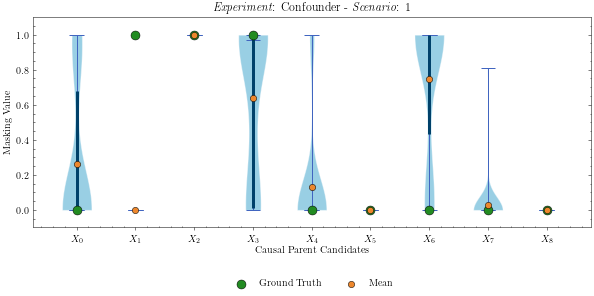

single_confoundertest_scenario-2
single Confounder 2 None


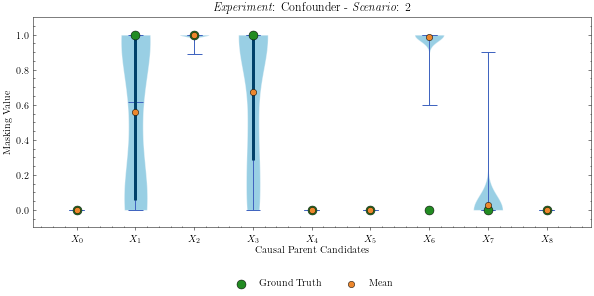

single_confoundertest_scenario-3
single Confounder 3 None


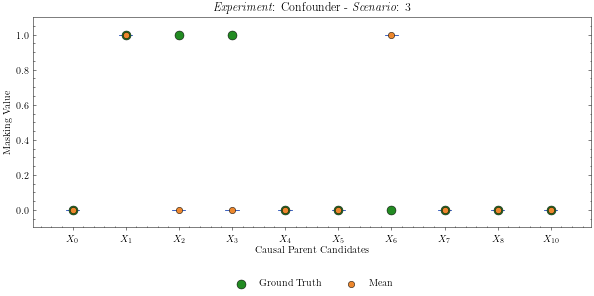

single_interventionstest_scenario-do_step-1
single Interventions Do 1


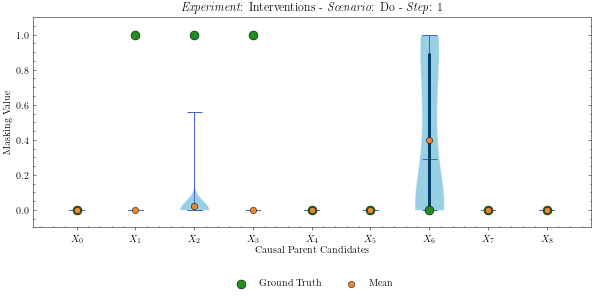

single_interventionstest_scenario-do_step-10
single Interventions Do 10


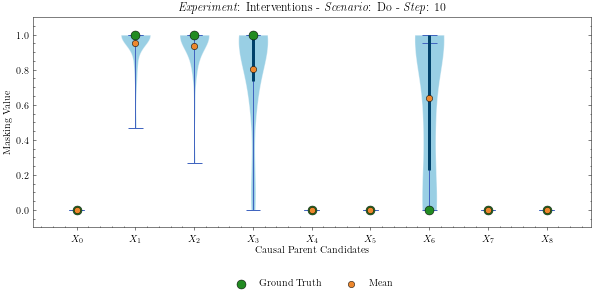

single_interventionstest_scenario-do_step-11
single Interventions Do 11


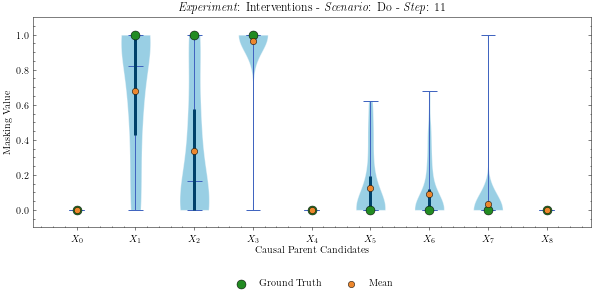

single_interventionstest_scenario-do_step-12
single Interventions Do 12


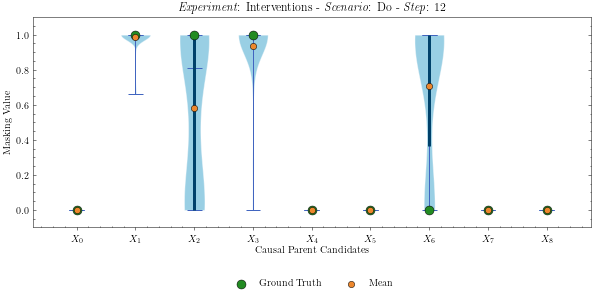

single_interventionstest_scenario-do_step-2
single Interventions Do 2


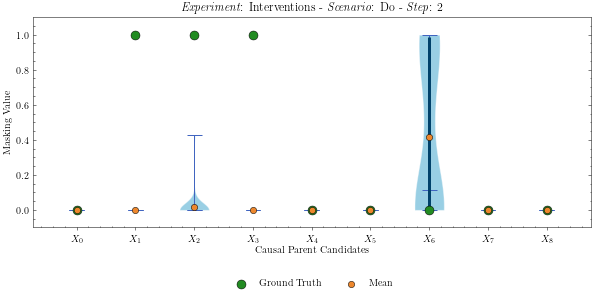

single_interventionstest_scenario-do_step-3
single Interventions Do 3


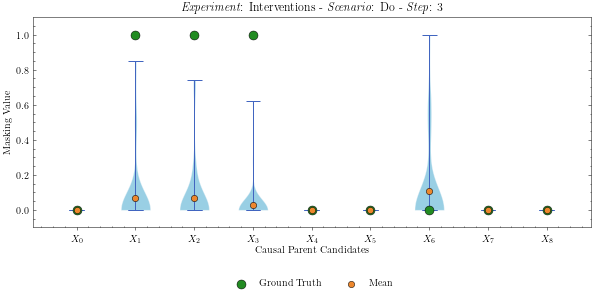

single_interventionstest_scenario-do_step-4
single Interventions Do 4


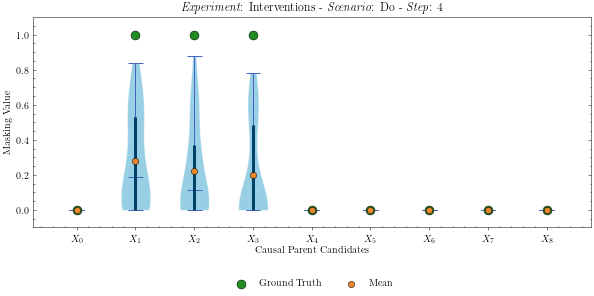

single_interventionstest_scenario-do_step-5
single Interventions Do 5


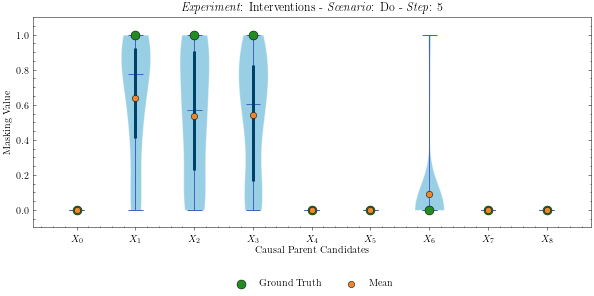

single_interventionstest_scenario-do_step-6
single Interventions Do 6


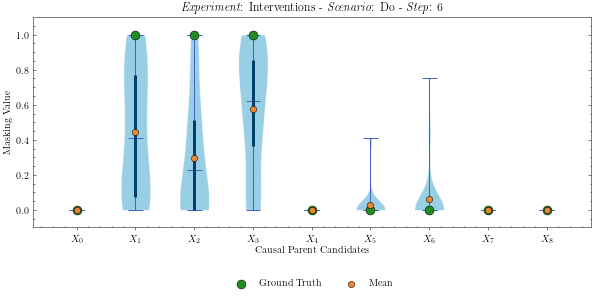

single_interventionstest_scenario-do_step-7
single Interventions Do 7


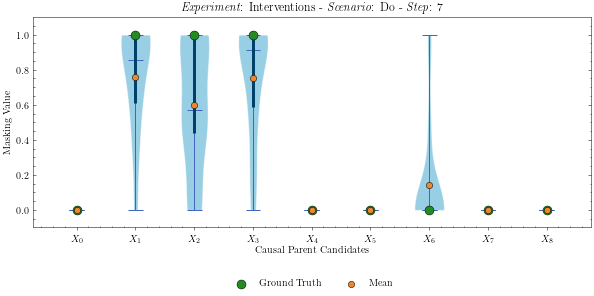

single_interventionstest_scenario-do_step-8
single Interventions Do 8


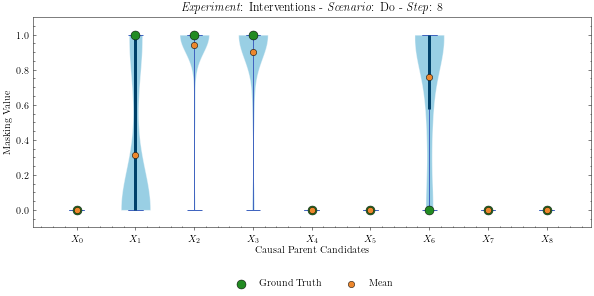

single_interventionstest_scenario-do_step-9
single Interventions Do 9


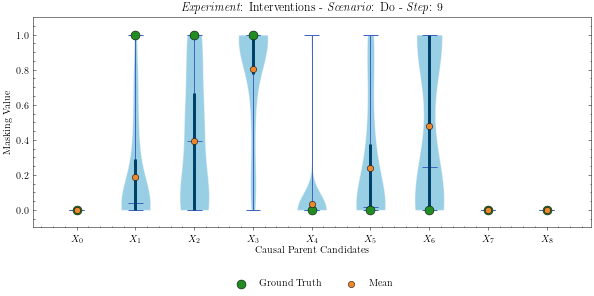

single_interventionstest_scenario-meanshift_step-1
single Interventions Meanshift 1


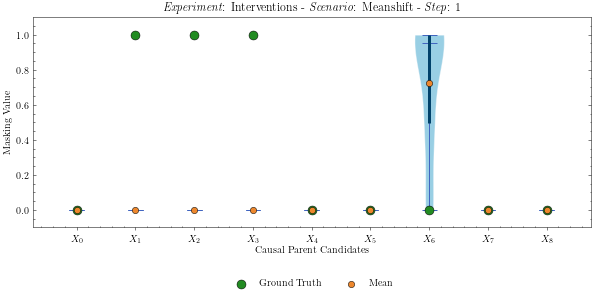

single_interventionstest_scenario-meanshift_step-10
single Interventions Meanshift 10


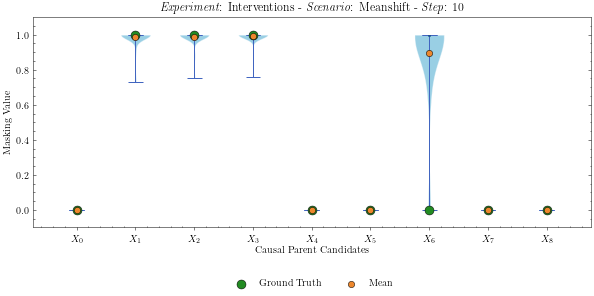

single_interventionstest_scenario-meanshift_step-11
single Interventions Meanshift 11


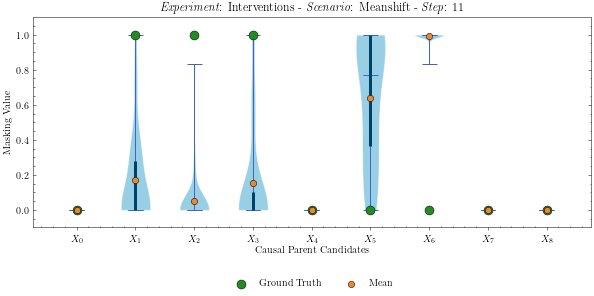

single_interventionstest_scenario-meanshift_step-12
single Interventions Meanshift 12


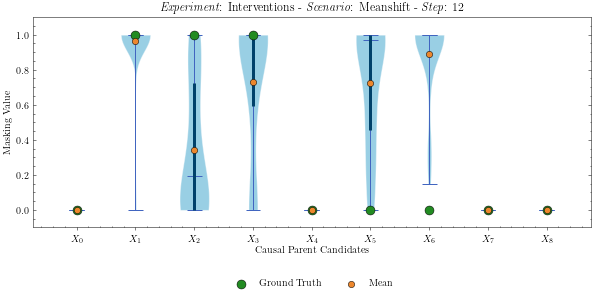

single_interventionstest_scenario-meanshift_step-2
single Interventions Meanshift 2


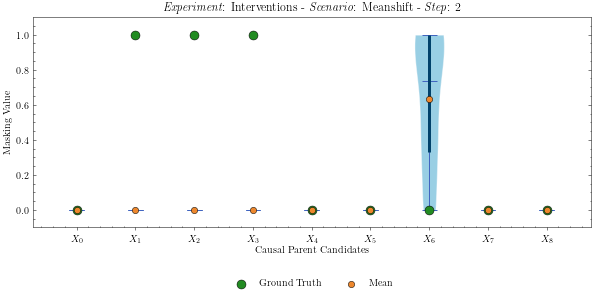

single_interventionstest_scenario-meanshift_step-3
single Interventions Meanshift 3


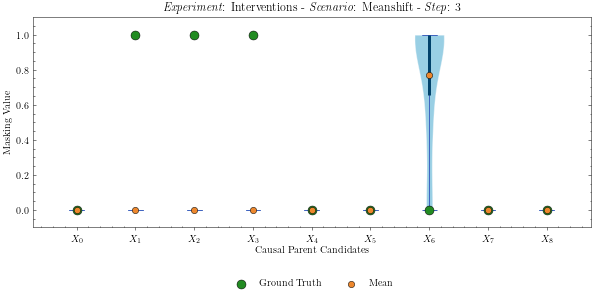

single_interventionstest_scenario-meanshift_step-4
single Interventions Meanshift 4


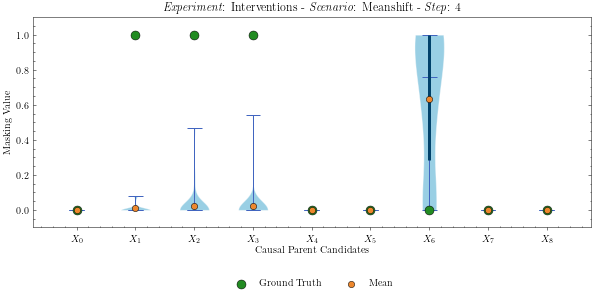

single_interventionstest_scenario-meanshift_step-5
single Interventions Meanshift 5


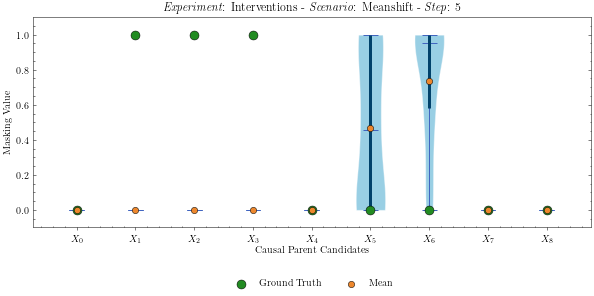

single_interventionstest_scenario-meanshift_step-6
single Interventions Meanshift 6


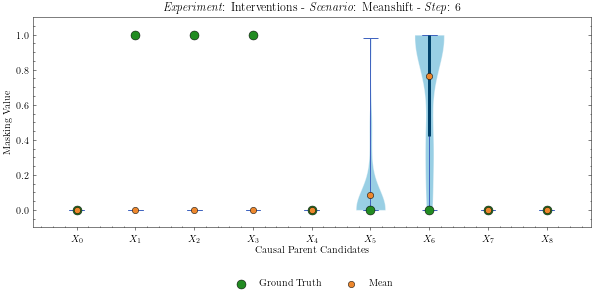

single_interventionstest_scenario-meanshift_step-7
single Interventions Meanshift 7


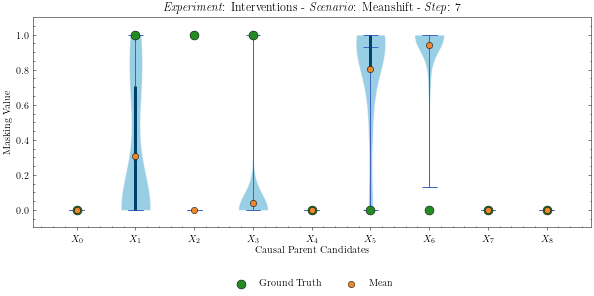

single_interventionstest_scenario-meanshift_step-8
single Interventions Meanshift 8


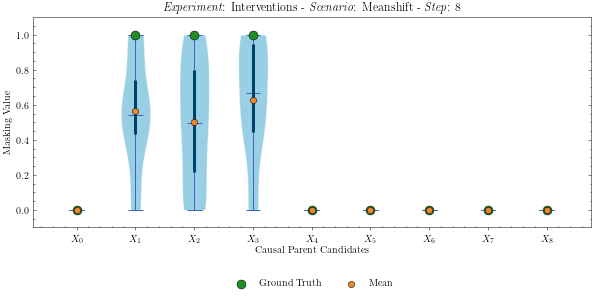

single_interventionstest_scenario-meanshift_step-9
single Interventions Meanshift 9


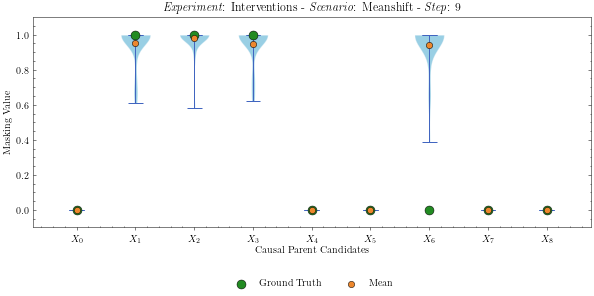

single_interventionstest_scenario-scaling_step-1
single Interventions Scaling 1


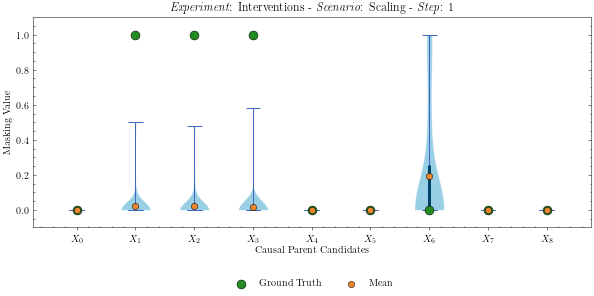

single_interventionstest_scenario-scaling_step-10
single Interventions Scaling 10


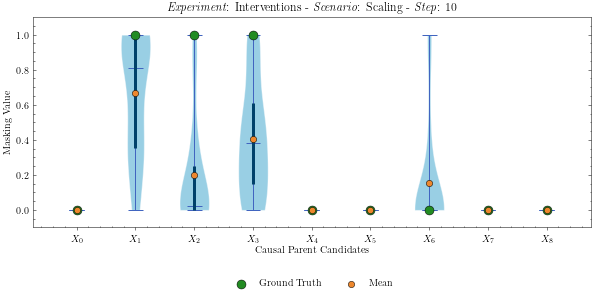

single_interventionstest_scenario-scaling_step-11
single Interventions Scaling 11


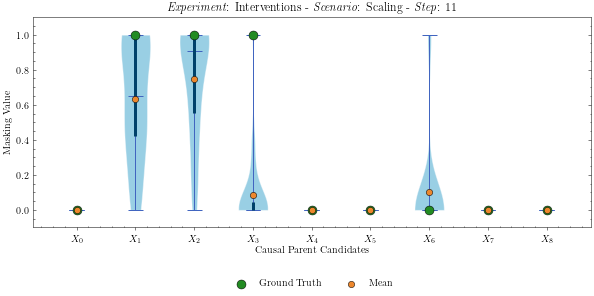

single_interventionstest_scenario-scaling_step-12
single Interventions Scaling 12


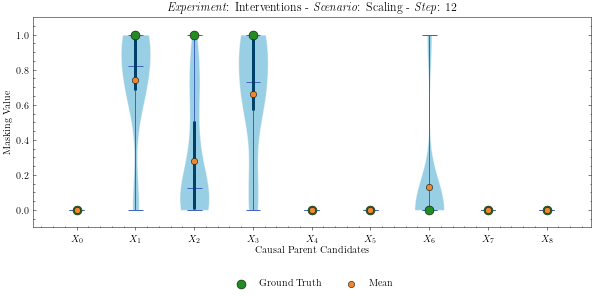

single_interventionstest_scenario-scaling_step-2
single Interventions Scaling 2


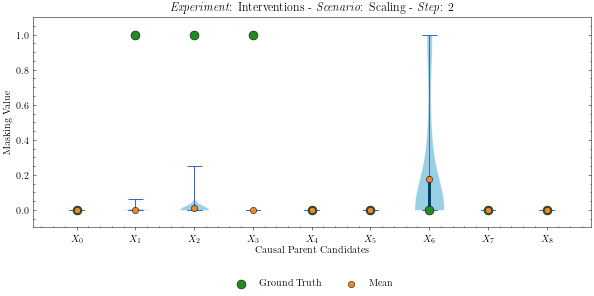

single_interventionstest_scenario-scaling_step-3
single Interventions Scaling 3


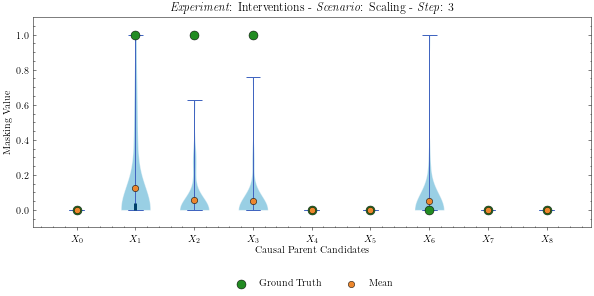

single_interventionstest_scenario-scaling_step-4
single Interventions Scaling 4


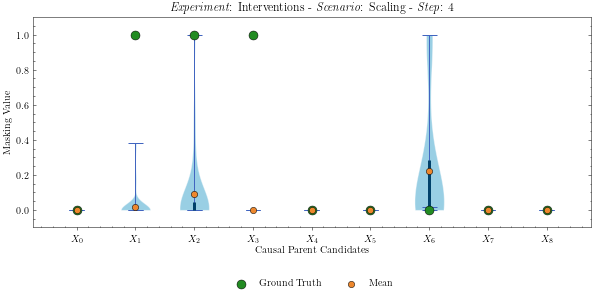

single_interventionstest_scenario-scaling_step-5
single Interventions Scaling 5


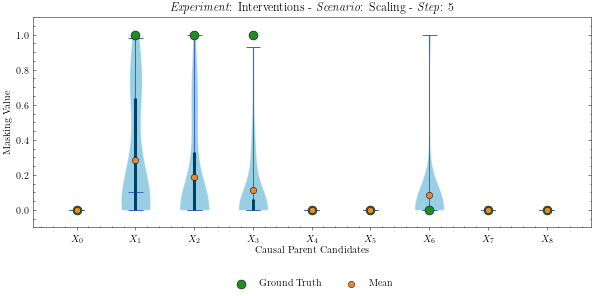

single_interventionstest_scenario-scaling_step-6
single Interventions Scaling 6


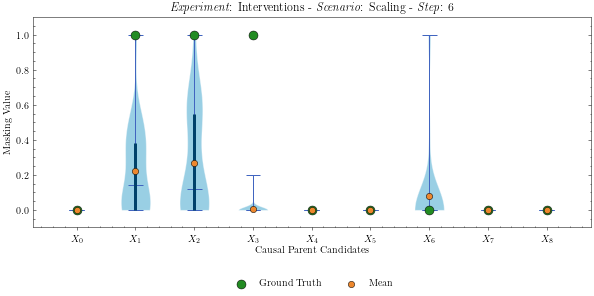

single_interventionstest_scenario-scaling_step-7
single Interventions Scaling 7


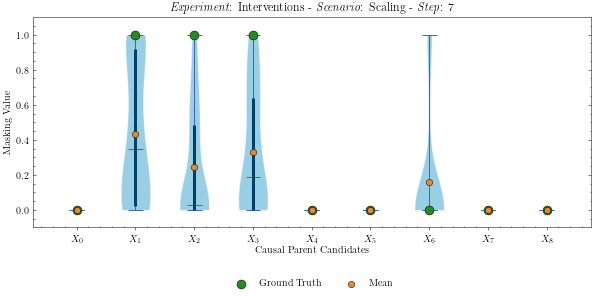

single_interventionstest_scenario-scaling_step-8
single Interventions Scaling 8


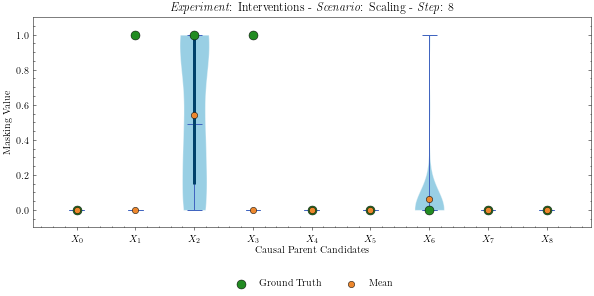

single_interventionstest_scenario-scaling_step-9
single Interventions Scaling 9


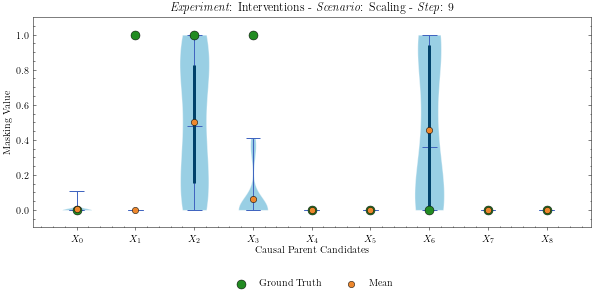

single_noisetest_dist-cauchy_args-loc=-5,scale=1,source=scipy_scenario-all_step-5
single Noise All 5


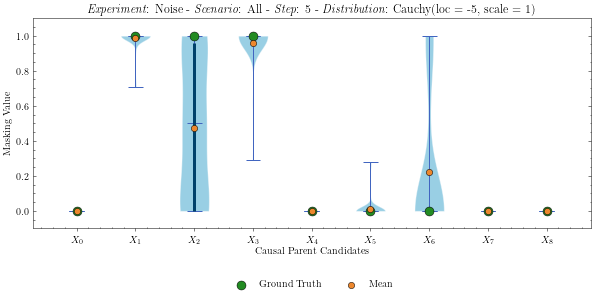

single_noisetest_dist-cauchy_args-loc=-5,scale=1,source=scipy_scenario-children_step-5
single Noise Children 5


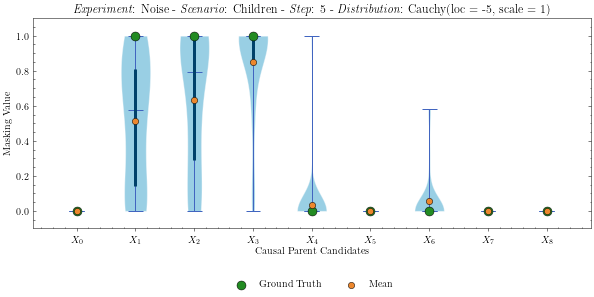

single_noisetest_dist-cauchy_args-loc=-5,scale=1,source=scipy_scenario-parents_step-5
single Noise Parents 5


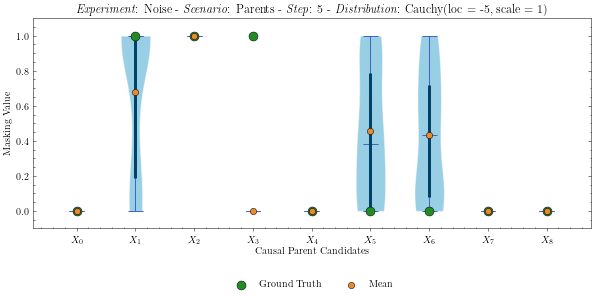

single_noisetest_dist-cauchy_args-loc=-5,scale=1,source=scipy_scenario-target_step-5
single Noise Target 5


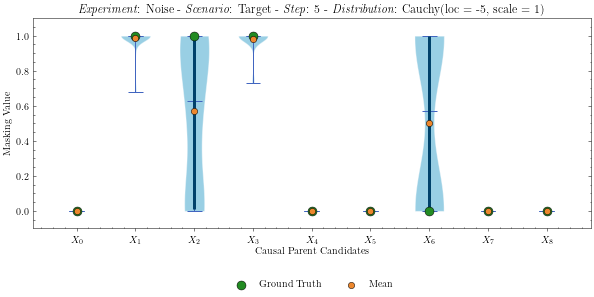

single_noisetest_dist-cauchy_args-loc=0,scale=1,source=scipy_scenario-all_step-1
single Noise All 1


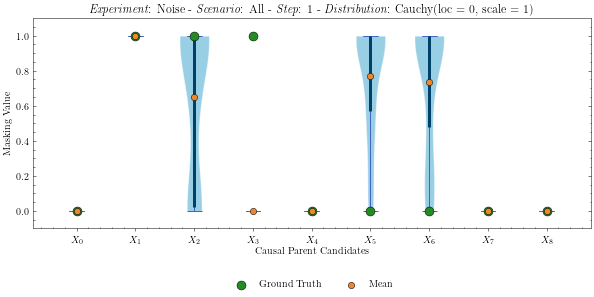

single_noisetest_dist-cauchy_args-loc=0,scale=1,source=scipy_scenario-children_step-1
single Noise Children 1


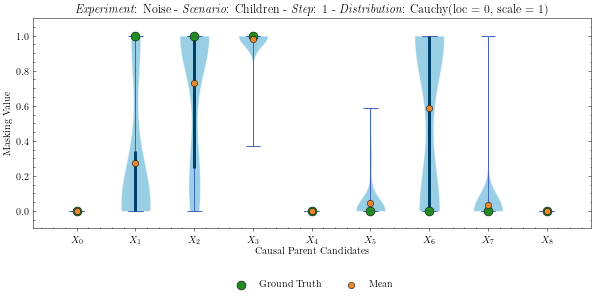

single_noisetest_dist-cauchy_args-loc=0,scale=1,source=scipy_scenario-parents_step-1
single Noise Parents 1


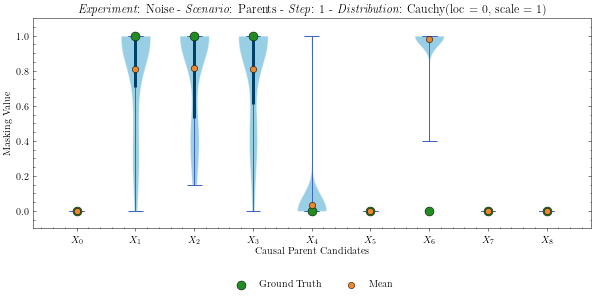

single_noisetest_dist-cauchy_args-loc=0,scale=1,source=scipy_scenario-target_step-1
single Noise Target 1


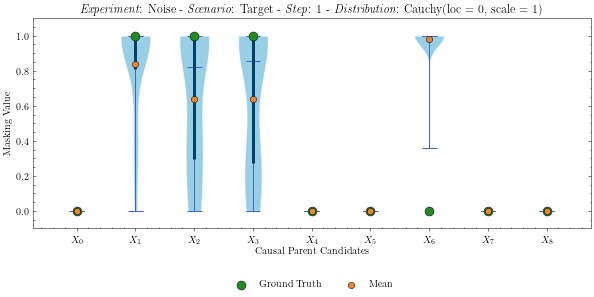

single_noisetest_dist-cauchy_args-loc=0,scale=2,source=scipy_scenario-all_step-2
single Noise All 2


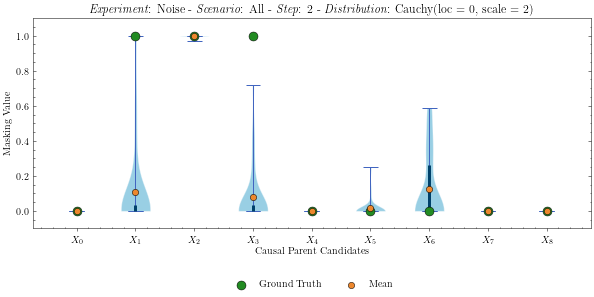

single_noisetest_dist-cauchy_args-loc=0,scale=2,source=scipy_scenario-children_step-2
single Noise Children 2


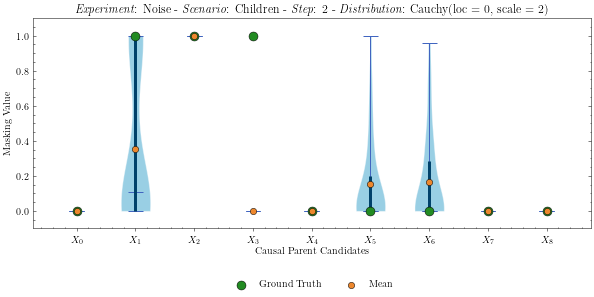

single_noisetest_dist-cauchy_args-loc=0,scale=2,source=scipy_scenario-parents_step-2
single Noise Parents 2


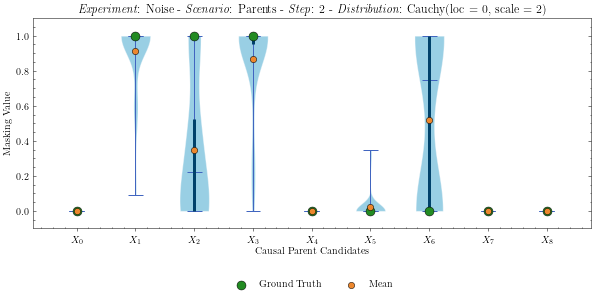

single_noisetest_dist-cauchy_args-loc=0,scale=2,source=scipy_scenario-target_step-2
single Noise Target 2


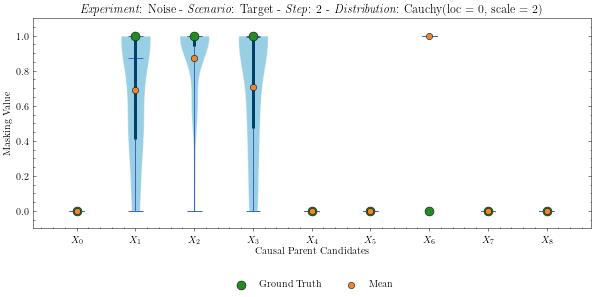

single_noisetest_dist-cauchy_args-loc=0,scale=5,source=scipy_scenario-all_step-3
single Noise All 3


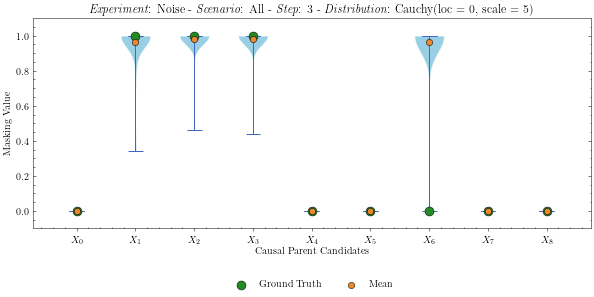

single_noisetest_dist-cauchy_args-loc=0,scale=5,source=scipy_scenario-children_step-3
single Noise Children 3


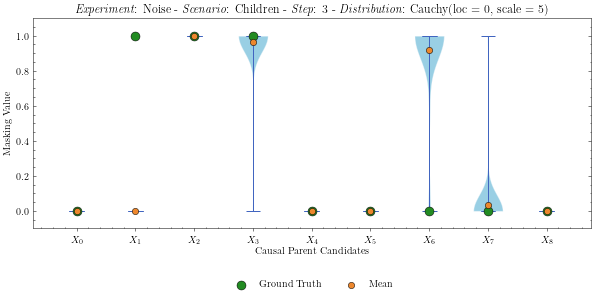

single_noisetest_dist-cauchy_args-loc=0,scale=5,source=scipy_scenario-parents_step-3
single Noise Parents 3


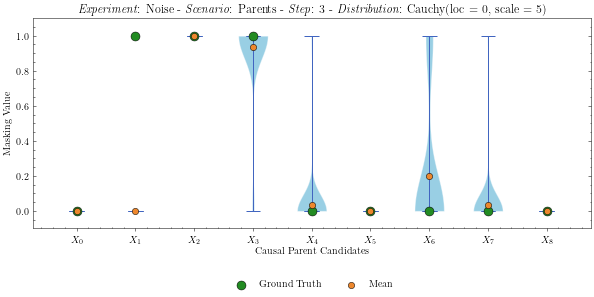

single_noisetest_dist-cauchy_args-loc=0,scale=5,source=scipy_scenario-target_step-3
single Noise Target 3


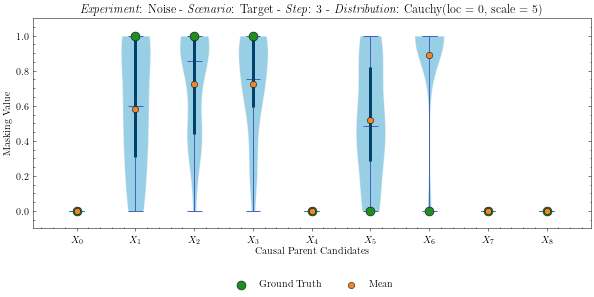

single_noisetest_dist-cauchy_args-loc=5,scale=1,source=scipy_scenario-all_step-4
single Noise All 4


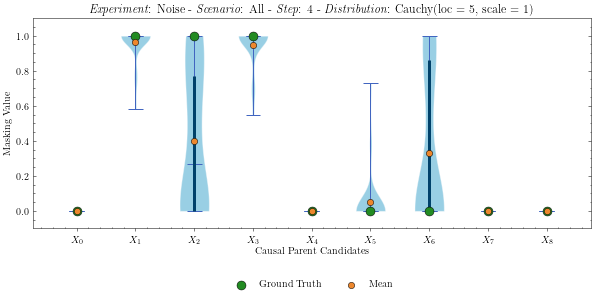

single_noisetest_dist-cauchy_args-loc=5,scale=1,source=scipy_scenario-children_step-4
single Noise Children 4


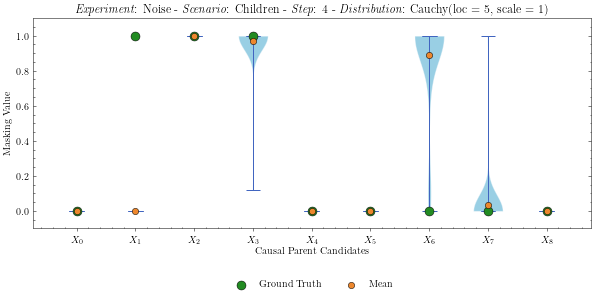

single_noisetest_dist-cauchy_args-loc=5,scale=1,source=scipy_scenario-parents_step-4
single Noise Parents 4


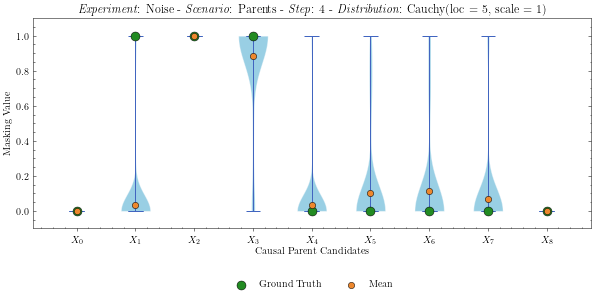

single_noisetest_dist-cauchy_args-loc=5,scale=1,source=scipy_scenario-target_step-4
single Noise Target 4


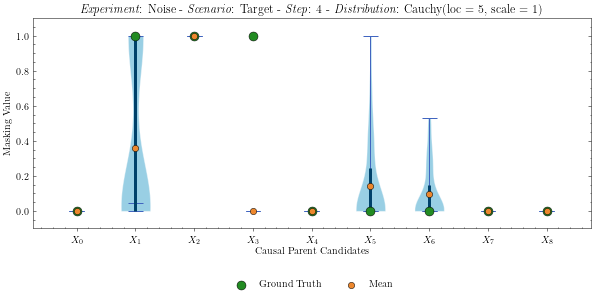

single_noisetest_dist-exponential_args-scale=1,source=numpy_scenario-all_step-1
single Noise All 1


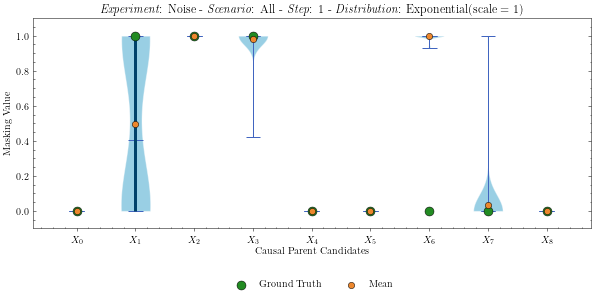

single_noisetest_dist-exponential_args-scale=1,source=numpy_scenario-children_step-1
single Noise Children 1


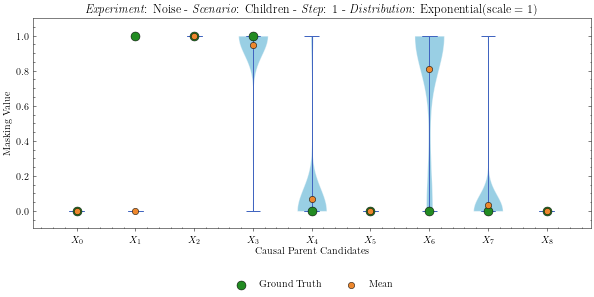

single_noisetest_dist-exponential_args-scale=1,source=numpy_scenario-parents_step-1
single Noise Parents 1


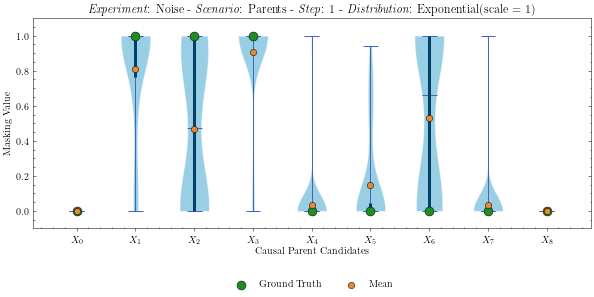

single_noisetest_dist-exponential_args-scale=1,source=numpy_scenario-target_step-1
single Noise Target 1


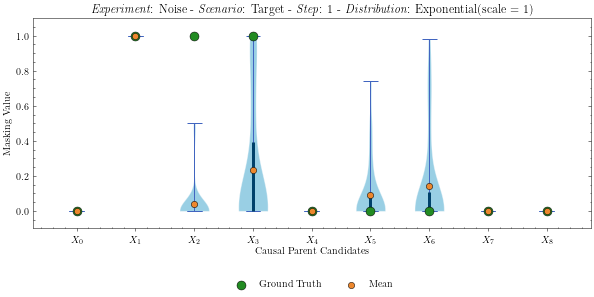

single_noisetest_dist-exponential_args-scale=10,source=numpy_scenario-all_step-3
single Noise All 3


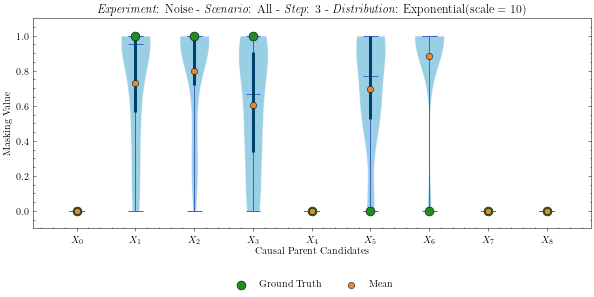

single_noisetest_dist-exponential_args-scale=10,source=numpy_scenario-children_step-3
single Noise Children 3


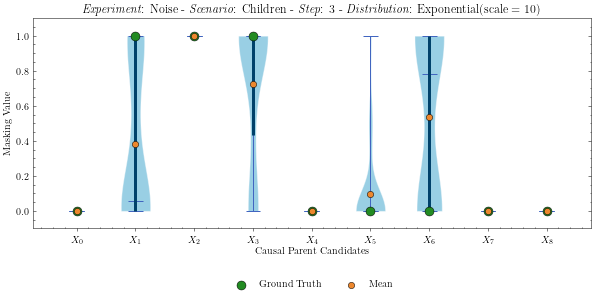

single_noisetest_dist-exponential_args-scale=10,source=numpy_scenario-parents_step-3
single Noise Parents 3


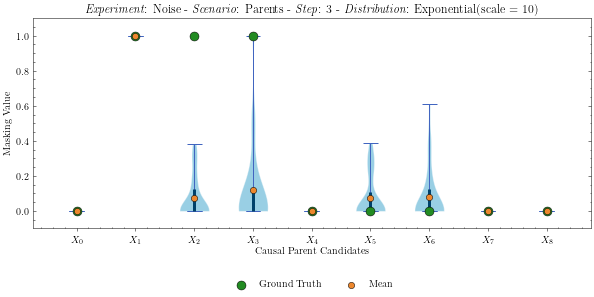

single_noisetest_dist-exponential_args-scale=10,source=numpy_scenario-target_step-3
single Noise Target 3


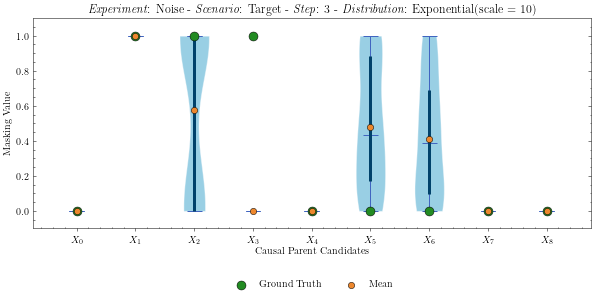

single_noisetest_dist-exponential_args-scale=30,source=numpy_scenario-all_step-4
single Noise All 4


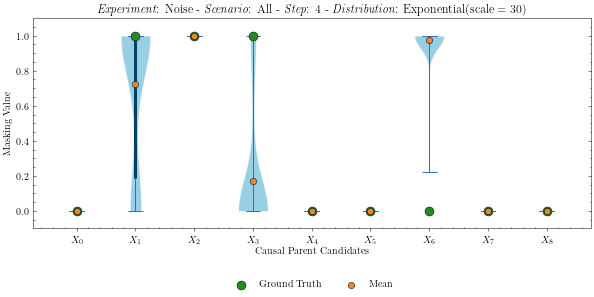

single_noisetest_dist-exponential_args-scale=30,source=numpy_scenario-children_step-4
single Noise Children 4


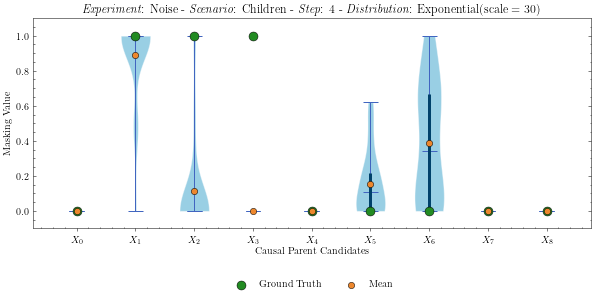

single_noisetest_dist-exponential_args-scale=30,source=numpy_scenario-parents_step-4
single Noise Parents 4


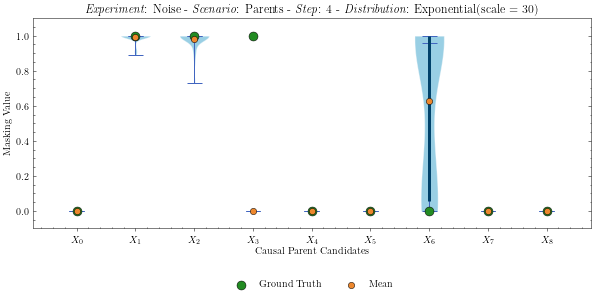

single_noisetest_dist-exponential_args-scale=30,source=numpy_scenario-target_step-4
single Noise Target 4


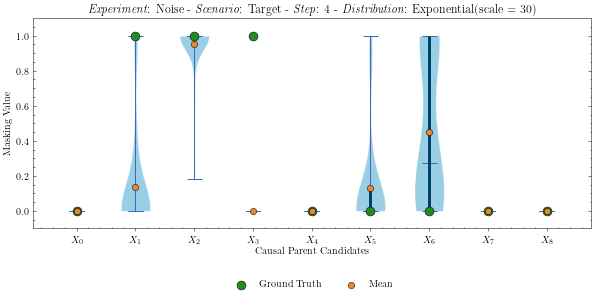

single_noisetest_dist-exponential_args-scale=5,source=numpy_scenario-all_step-2
single Noise All 2


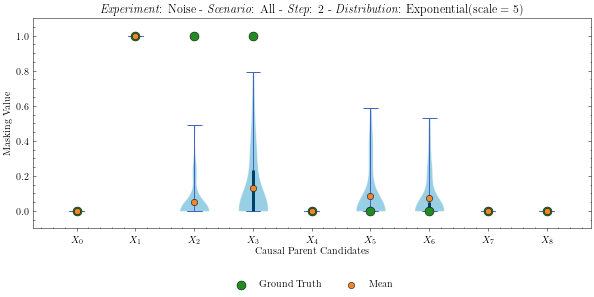

single_noisetest_dist-exponential_args-scale=5,source=numpy_scenario-children_step-2
single Noise Children 2


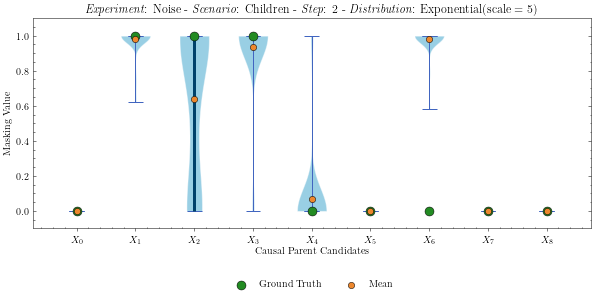

single_noisetest_dist-exponential_args-scale=5,source=numpy_scenario-parents_step-2
single Noise Parents 2


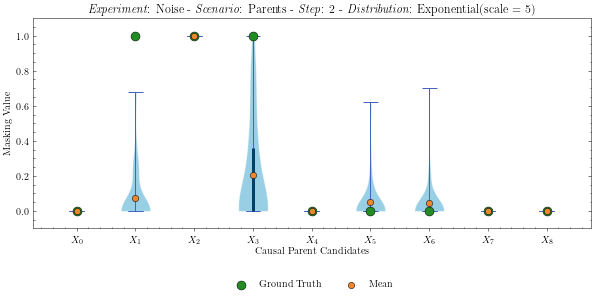

single_noisetest_dist-exponential_args-scale=5,source=numpy_scenario-target_step-2
single Noise Target 2


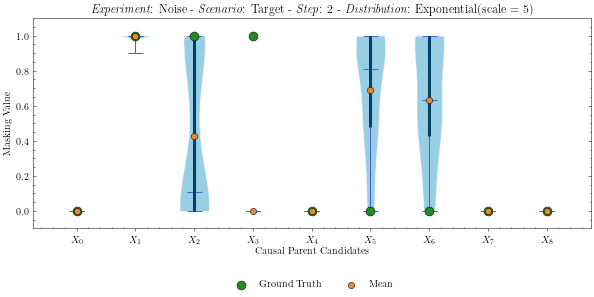

single_noisetest_dist-normal_args-loc=-5,scale=1,source=numpy_scenario-all_step-5
single Noise All 5


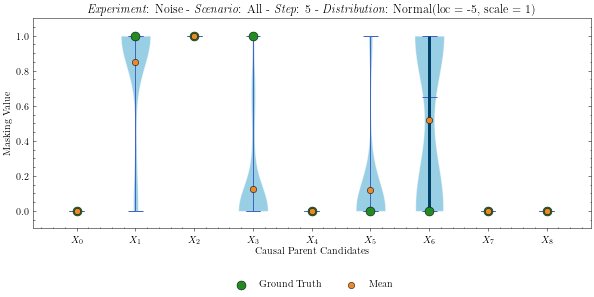

single_noisetest_dist-normal_args-loc=-5,scale=1,source=numpy_scenario-children_step-5
single Noise Children 5


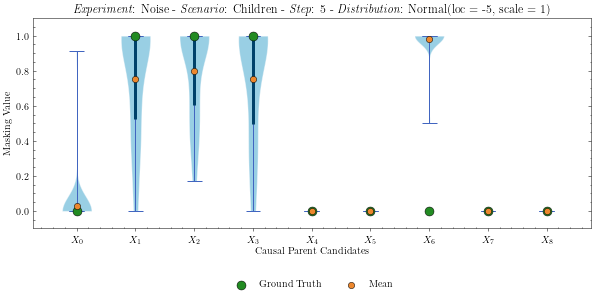

single_noisetest_dist-normal_args-loc=-5,scale=1,source=numpy_scenario-parents_step-5
single Noise Parents 5


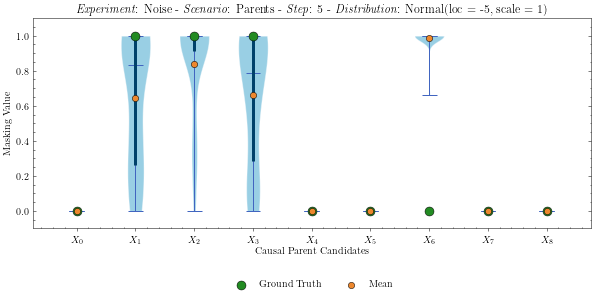

single_noisetest_dist-normal_args-loc=-5,scale=1,source=numpy_scenario-target_step-5
single Noise Target 5


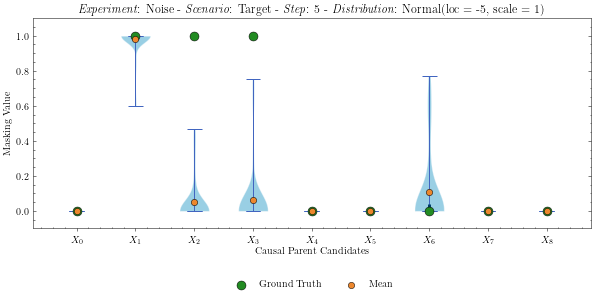

single_noisetest_dist-normal_args-loc=0,scale=1,source=numpy_scenario-all_step-1
single Noise All 1


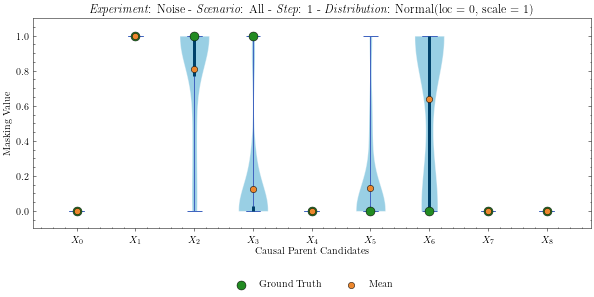

single_noisetest_dist-normal_args-loc=0,scale=1,source=numpy_scenario-children_step-1
single Noise Children 1


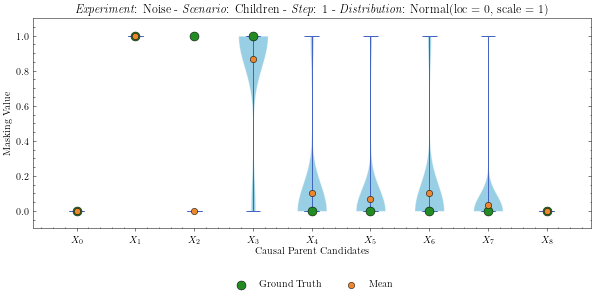

single_noisetest_dist-normal_args-loc=0,scale=1,source=numpy_scenario-parents_step-1
single Noise Parents 1


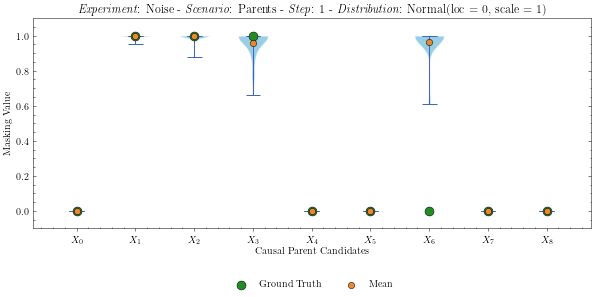

single_noisetest_dist-normal_args-loc=0,scale=1,source=numpy_scenario-target_step-1
single Noise Target 1


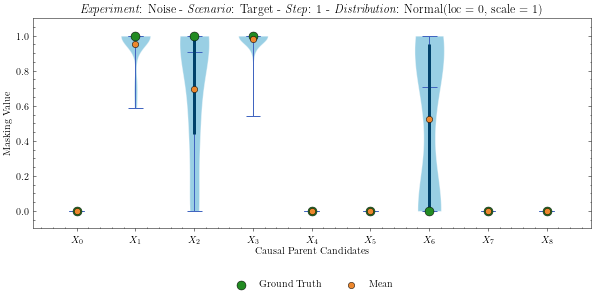

single_noisetest_dist-normal_args-loc=0,scale=2,source=numpy_scenario-all_step-2
single Noise All 2


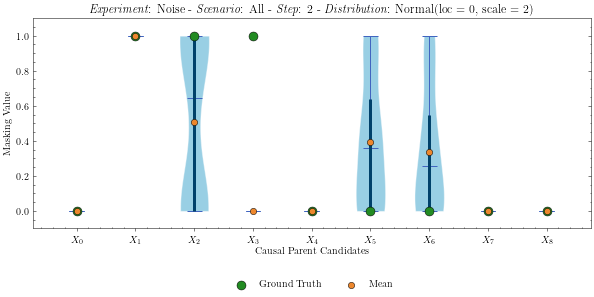

single_noisetest_dist-normal_args-loc=0,scale=2,source=numpy_scenario-children_step-2
single Noise Children 2


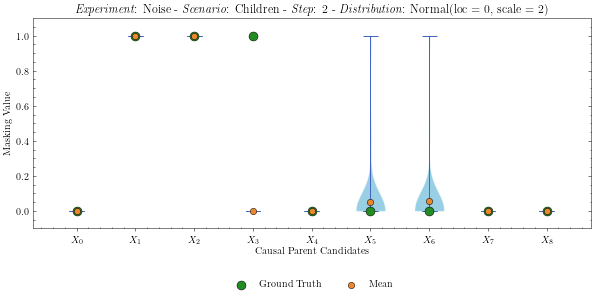

single_noisetest_dist-normal_args-loc=0,scale=2,source=numpy_scenario-parents_step-2
single Noise Parents 2


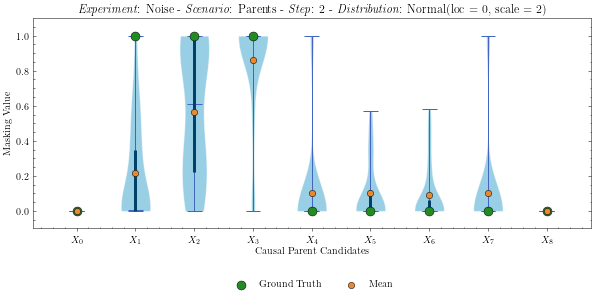

single_noisetest_dist-normal_args-loc=0,scale=2,source=numpy_scenario-target_step-2
single Noise Target 2


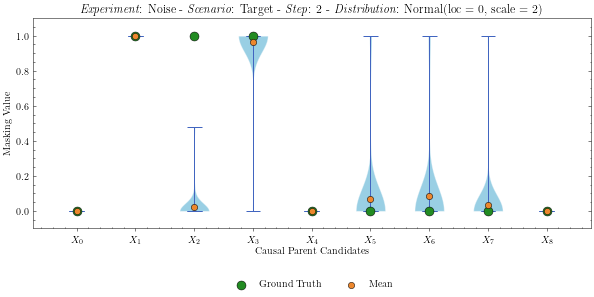

single_noisetest_dist-normal_args-loc=0,scale=5,source=numpy_scenario-all_step-3
single Noise All 3


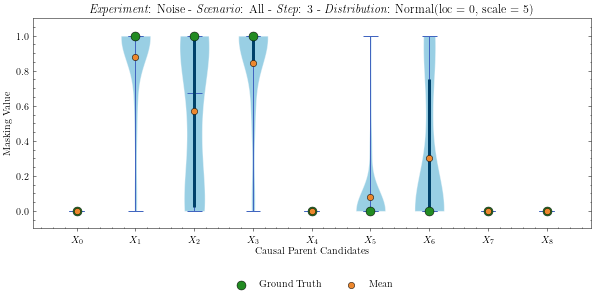

single_noisetest_dist-normal_args-loc=0,scale=5,source=numpy_scenario-children_step-3
single Noise Children 3


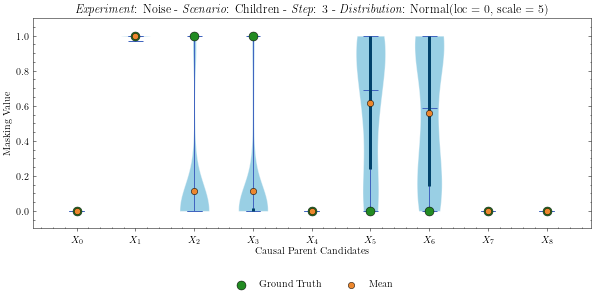

single_noisetest_dist-normal_args-loc=0,scale=5,source=numpy_scenario-parents_step-3
single Noise Parents 3


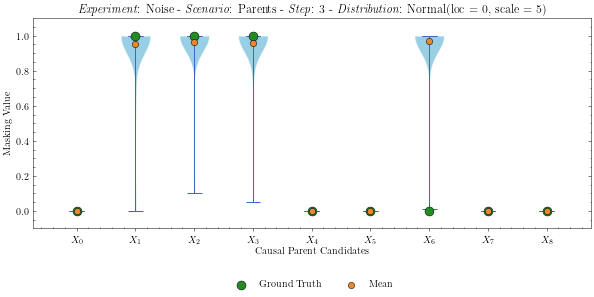

single_noisetest_dist-normal_args-loc=0,scale=5,source=numpy_scenario-target_step-3
single Noise Target 3


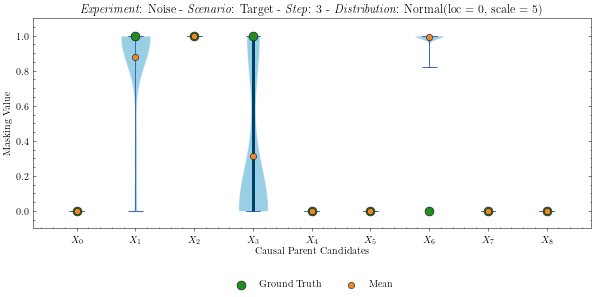

single_noisetest_dist-normal_args-loc=5,scale=1,source=numpy_scenario-all_step-4
single Noise All 4


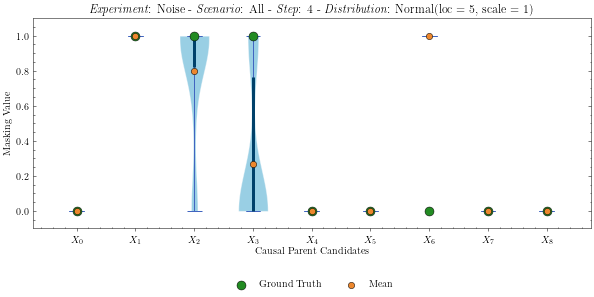

single_noisetest_dist-normal_args-loc=5,scale=1,source=numpy_scenario-children_step-4
single Noise Children 4


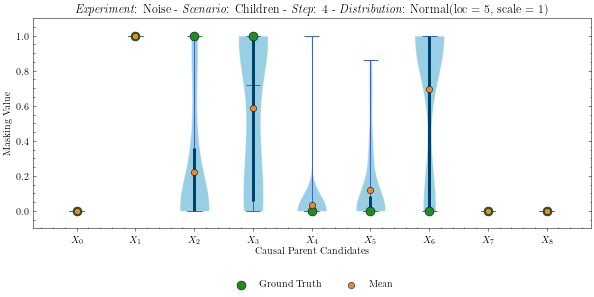

single_noisetest_dist-normal_args-loc=5,scale=1,source=numpy_scenario-parents_step-4
single Noise Parents 4


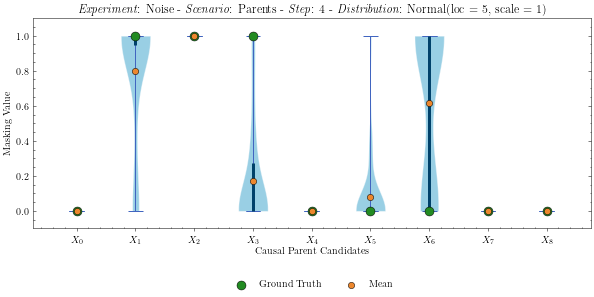

single_noisetest_dist-normal_args-loc=5,scale=1,source=numpy_scenario-target_step-4
single Noise Target 4


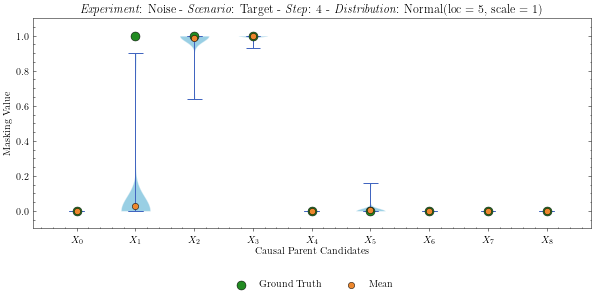

single_nonlinearitytest_scenario-all_step-1
single Nonlinearity All 1


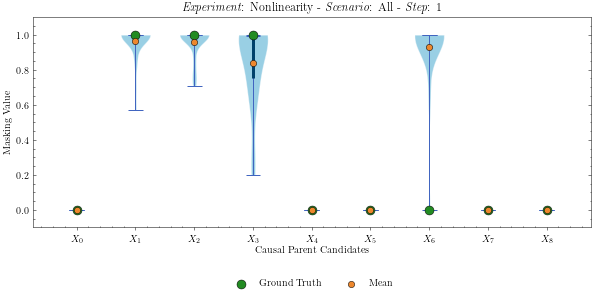

single_nonlinearitytest_scenario-all_step-10
single Nonlinearity All 10


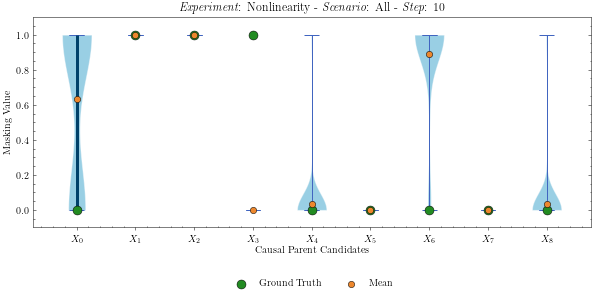

single_nonlinearitytest_scenario-all_step-11
single Nonlinearity All 11


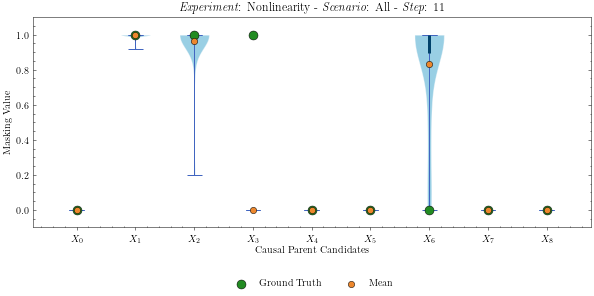

single_nonlinearitytest_scenario-all_step-12
single Nonlinearity All 12


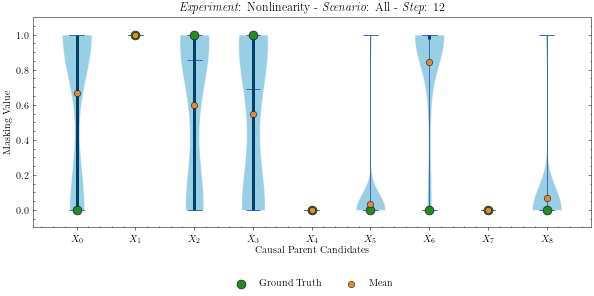

single_nonlinearitytest_scenario-all_step-13
single Nonlinearity All 13


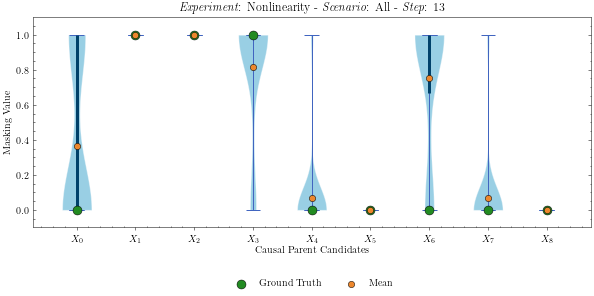

single_nonlinearitytest_scenario-all_step-14
single Nonlinearity All 14


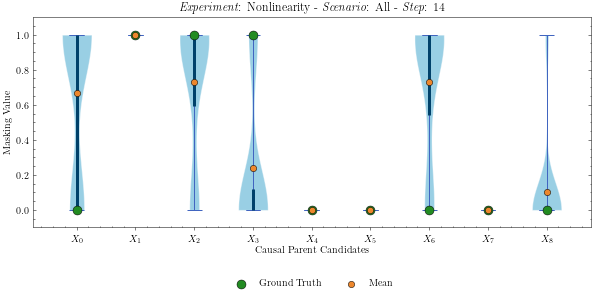

single_nonlinearitytest_scenario-all_step-15
single Nonlinearity All 15


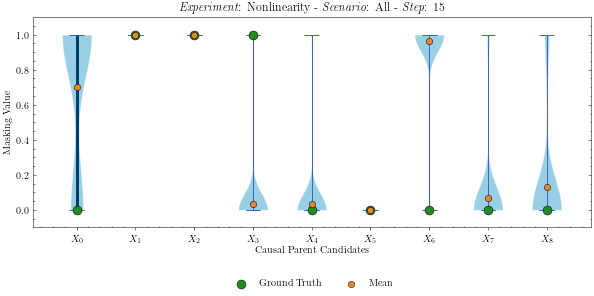

single_nonlinearitytest_scenario-all_step-16
single Nonlinearity All 16


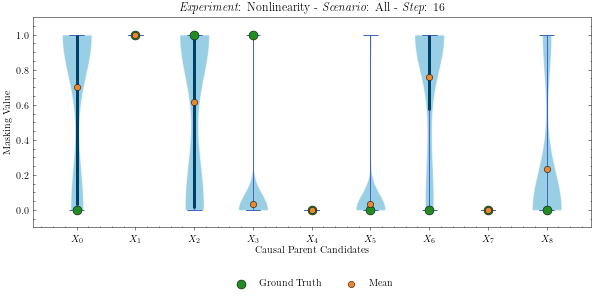

single_nonlinearitytest_scenario-all_step-17
single Nonlinearity All 17


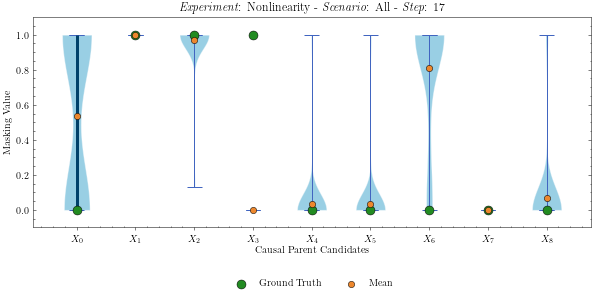

single_nonlinearitytest_scenario-all_step-18
single Nonlinearity All 18


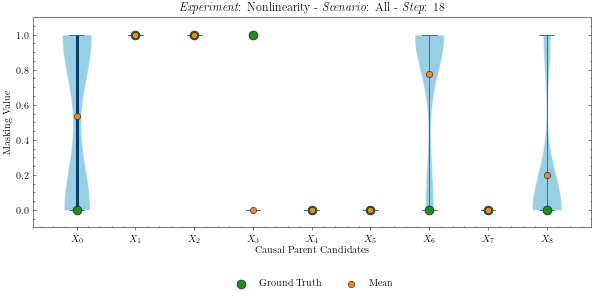

single_nonlinearitytest_scenario-all_step-19
single Nonlinearity All 19


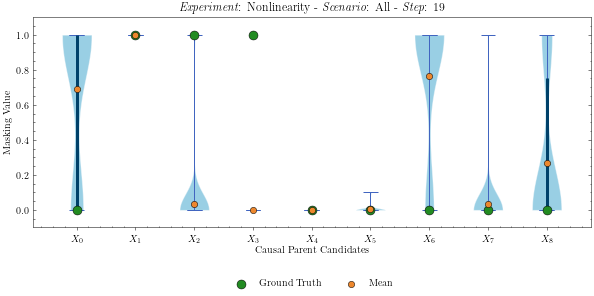

single_nonlinearitytest_scenario-all_step-2
single Nonlinearity All 2


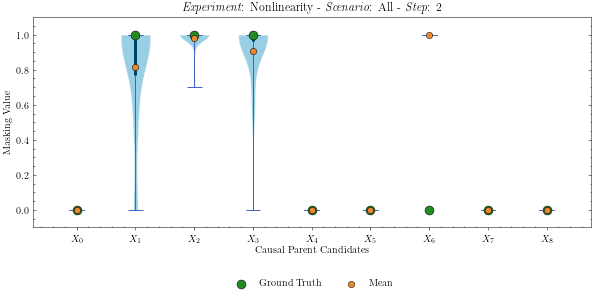

single_nonlinearitytest_scenario-all_step-20
single Nonlinearity All 20


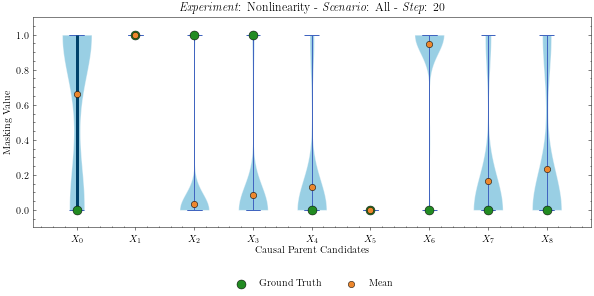

single_nonlinearitytest_scenario-all_step-3
single Nonlinearity All 3


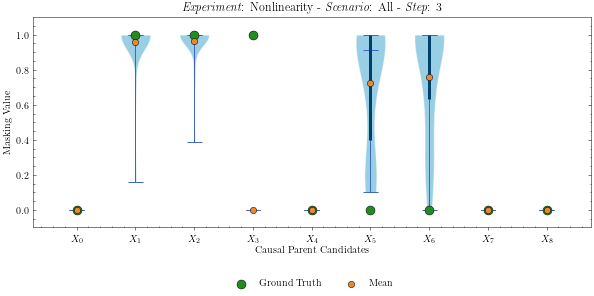

single_nonlinearitytest_scenario-all_step-4
single Nonlinearity All 4


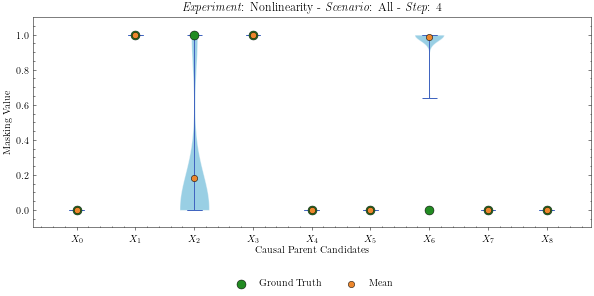

single_nonlinearitytest_scenario-all_step-5
single Nonlinearity All 5


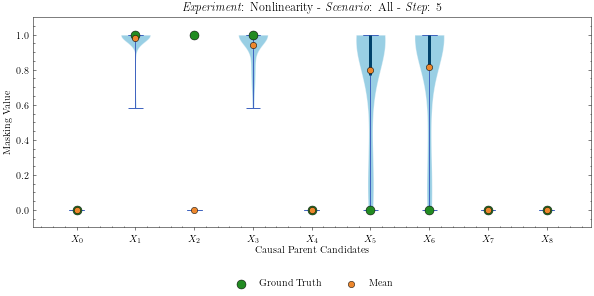

single_nonlinearitytest_scenario-all_step-6
single Nonlinearity All 6


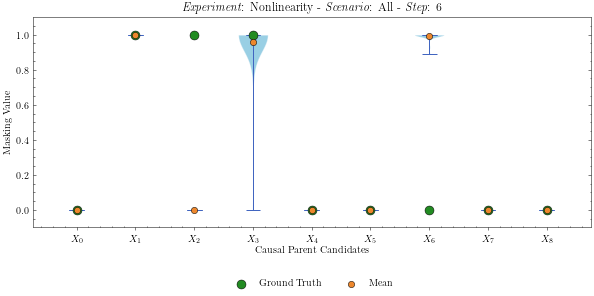

single_nonlinearitytest_scenario-all_step-7
single Nonlinearity All 7


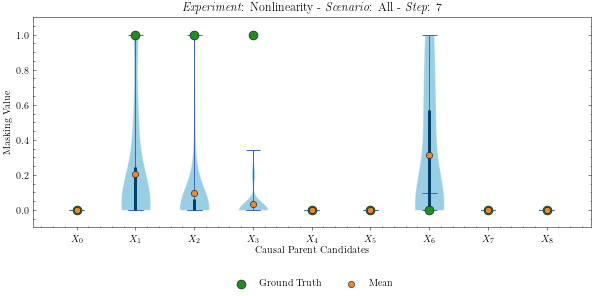

single_nonlinearitytest_scenario-all_step-8
single Nonlinearity All 8


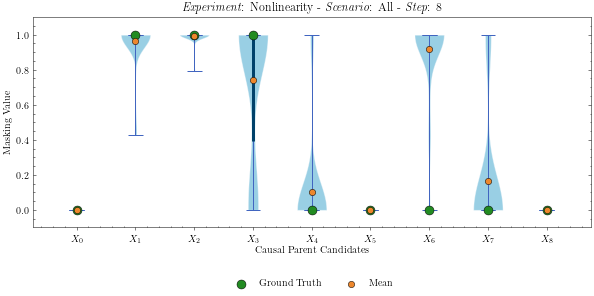

single_nonlinearitytest_scenario-all_step-9
single Nonlinearity All 9


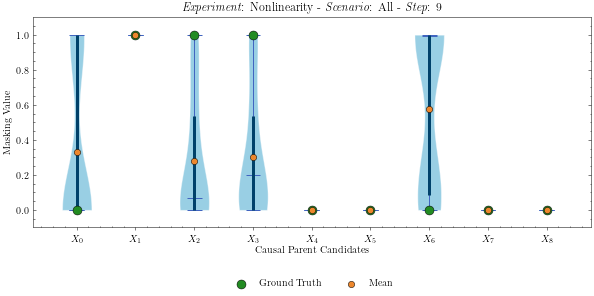

single_nonlinearitytest_scenario-children_step-1
single Nonlinearity Children 1


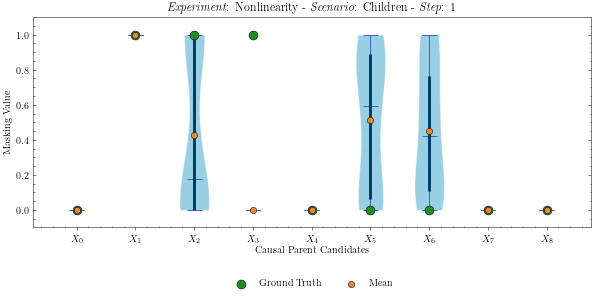

single_nonlinearitytest_scenario-children_step-10
single Nonlinearity Children 10


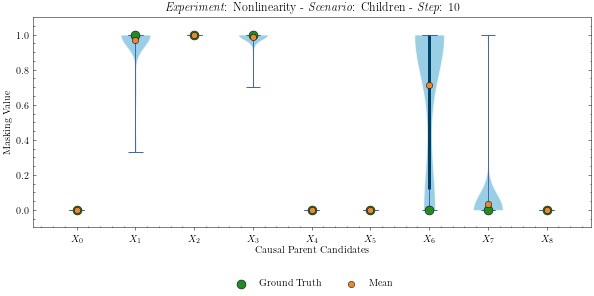

single_nonlinearitytest_scenario-children_step-11
single Nonlinearity Children 11


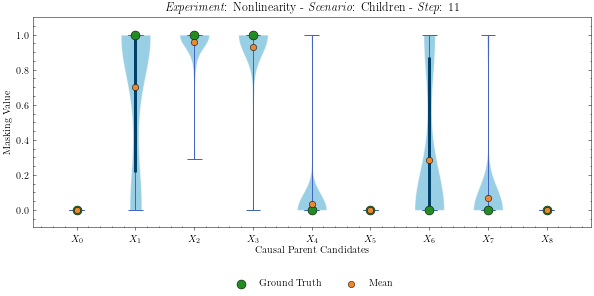

single_nonlinearitytest_scenario-children_step-12
single Nonlinearity Children 12


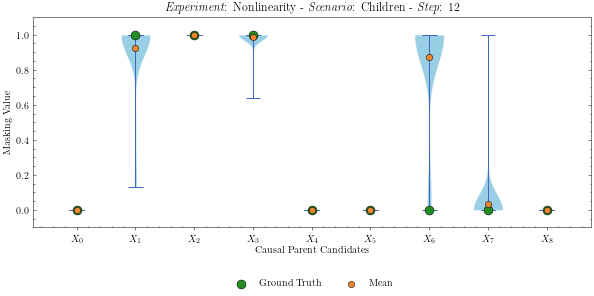

single_nonlinearitytest_scenario-children_step-13
single Nonlinearity Children 13


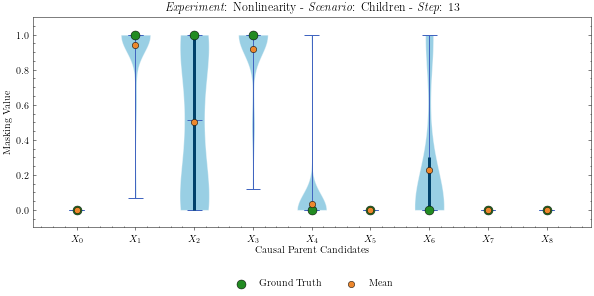

single_nonlinearitytest_scenario-children_step-14
single Nonlinearity Children 14


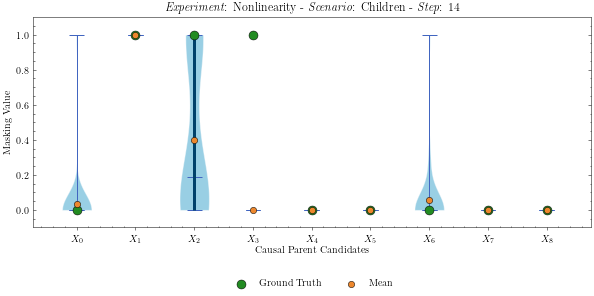

single_nonlinearitytest_scenario-children_step-15
single Nonlinearity Children 15


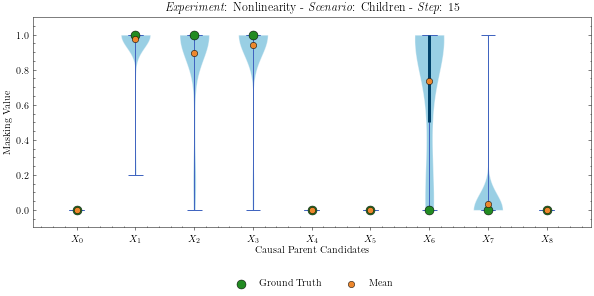

single_nonlinearitytest_scenario-children_step-16
single Nonlinearity Children 16


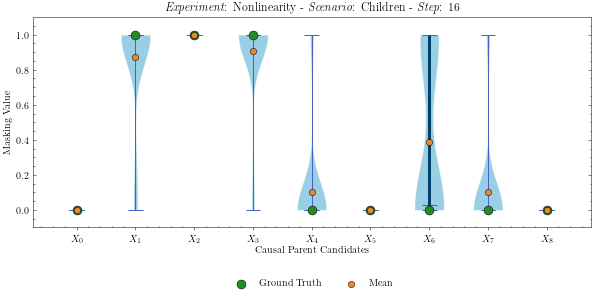

single_nonlinearitytest_scenario-children_step-17
single Nonlinearity Children 17


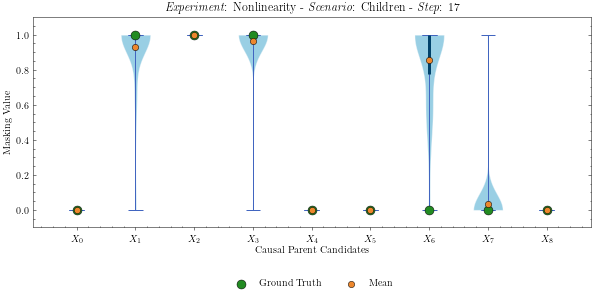

single_nonlinearitytest_scenario-children_step-18
single Nonlinearity Children 18


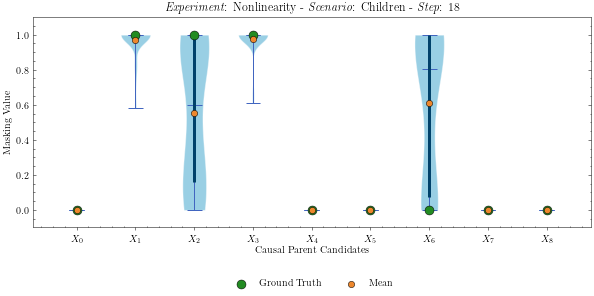

single_nonlinearitytest_scenario-children_step-19
single Nonlinearity Children 19


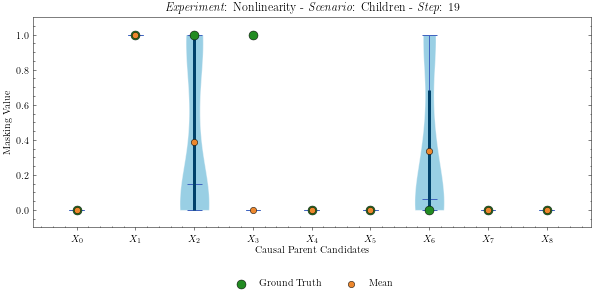

single_nonlinearitytest_scenario-children_step-2
single Nonlinearity Children 2


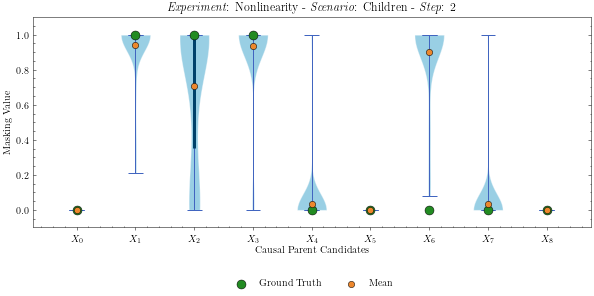

single_nonlinearitytest_scenario-children_step-20
single Nonlinearity Children 20


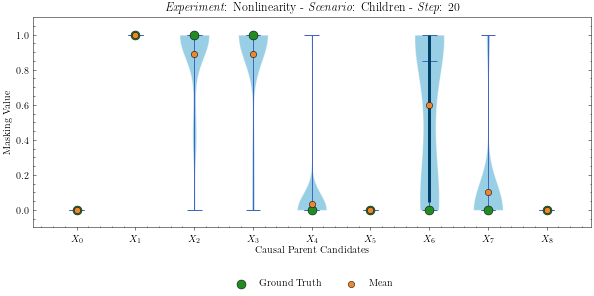

single_nonlinearitytest_scenario-children_step-3
single Nonlinearity Children 3


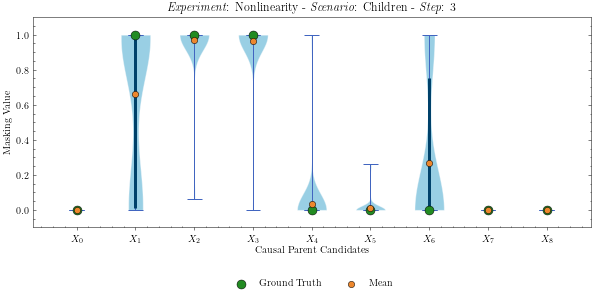

single_nonlinearitytest_scenario-children_step-4
single Nonlinearity Children 4


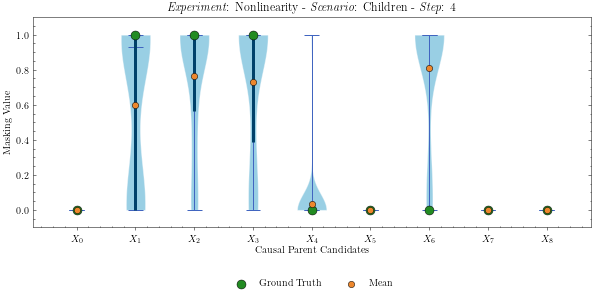

single_nonlinearitytest_scenario-children_step-5
single Nonlinearity Children 5


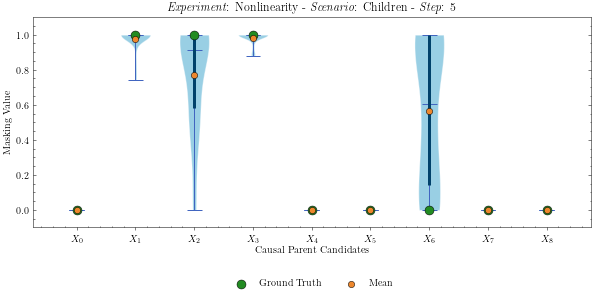

single_nonlinearitytest_scenario-children_step-6
single Nonlinearity Children 6


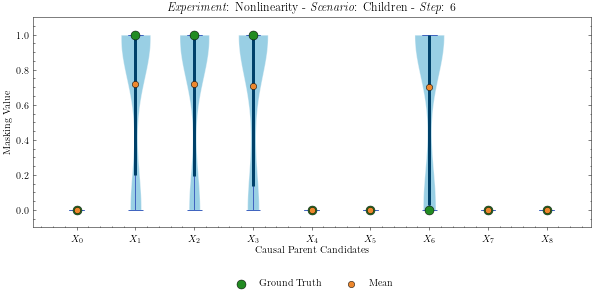

single_nonlinearitytest_scenario-children_step-7
single Nonlinearity Children 7


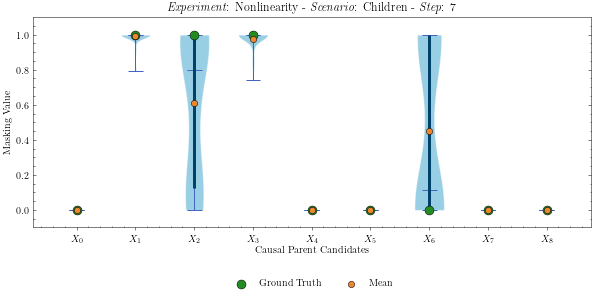

single_nonlinearitytest_scenario-children_step-8
single Nonlinearity Children 8


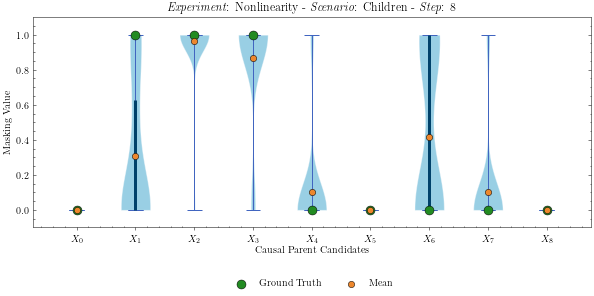

single_nonlinearitytest_scenario-children_step-9
single Nonlinearity Children 9


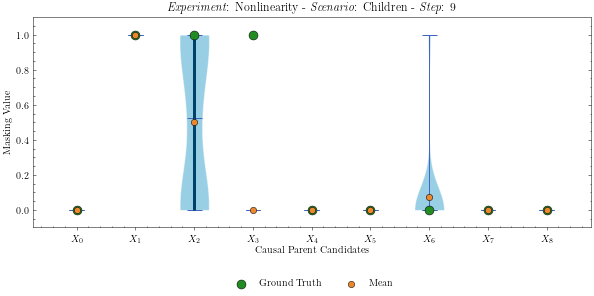

single_nonlinearitytest_scenario-parents_step-1
single Nonlinearity Parents 1


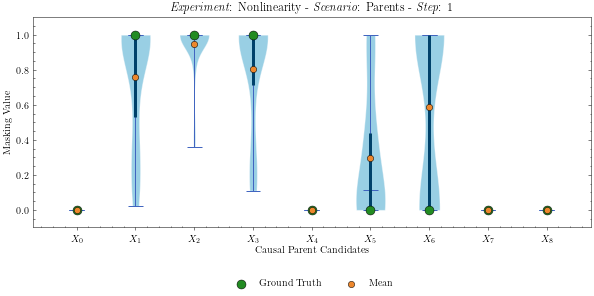

single_nonlinearitytest_scenario-parents_step-10
single Nonlinearity Parents 10


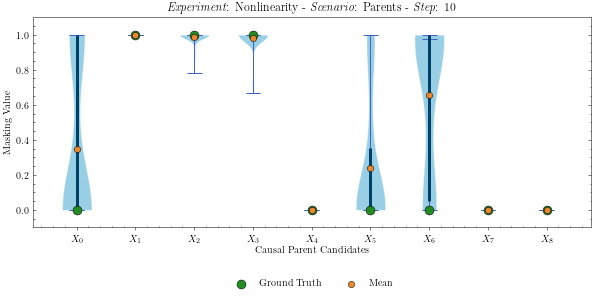

single_nonlinearitytest_scenario-parents_step-11
single Nonlinearity Parents 11


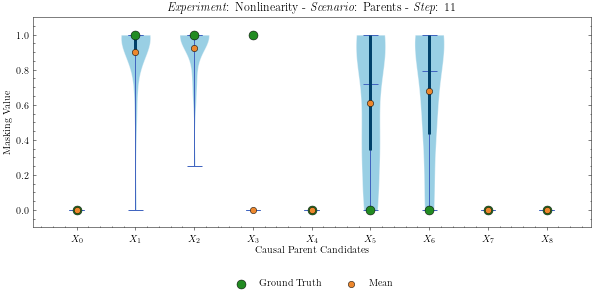

single_nonlinearitytest_scenario-parents_step-12
single Nonlinearity Parents 12


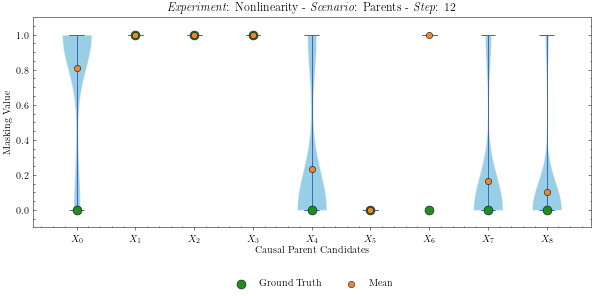

single_nonlinearitytest_scenario-parents_step-13
single Nonlinearity Parents 13


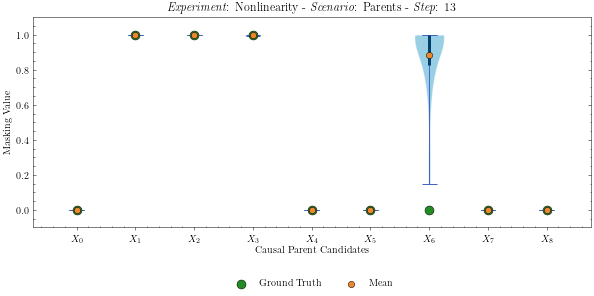

single_nonlinearitytest_scenario-parents_step-14
single Nonlinearity Parents 14


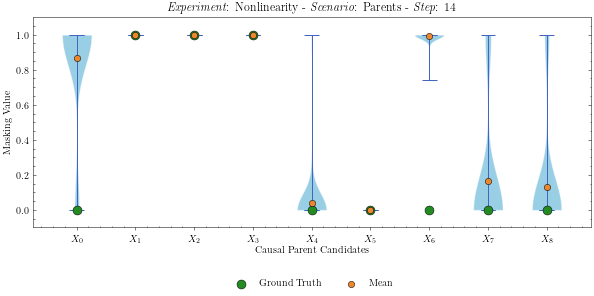

single_nonlinearitytest_scenario-parents_step-15
single Nonlinearity Parents 15


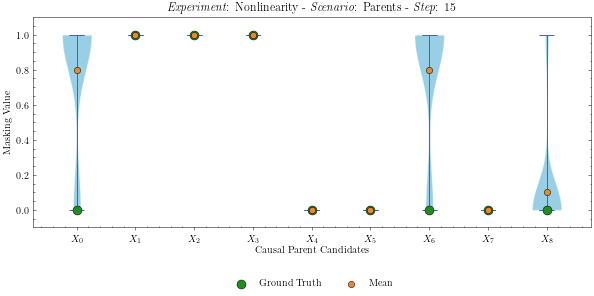

single_nonlinearitytest_scenario-parents_step-16
single Nonlinearity Parents 16


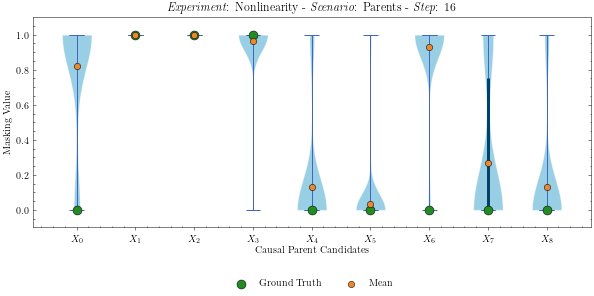

single_nonlinearitytest_scenario-parents_step-17
single Nonlinearity Parents 17


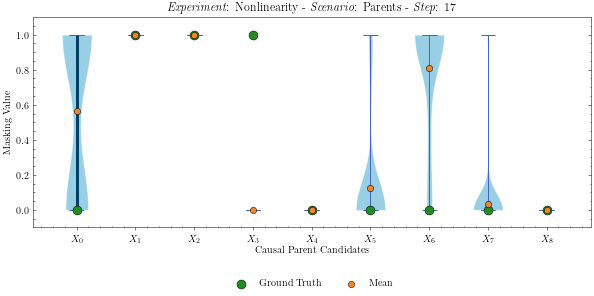

single_nonlinearitytest_scenario-parents_step-18
single Nonlinearity Parents 18


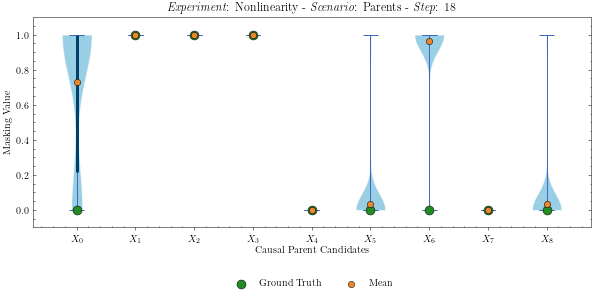

single_nonlinearitytest_scenario-parents_step-19
single Nonlinearity Parents 19


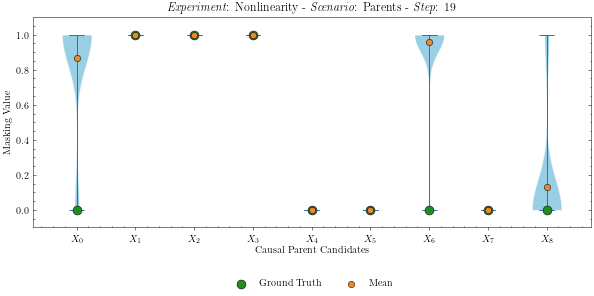

single_nonlinearitytest_scenario-parents_step-2
single Nonlinearity Parents 2


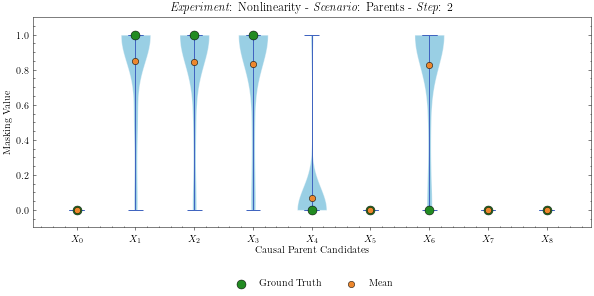

single_nonlinearitytest_scenario-parents_step-20
single Nonlinearity Parents 20


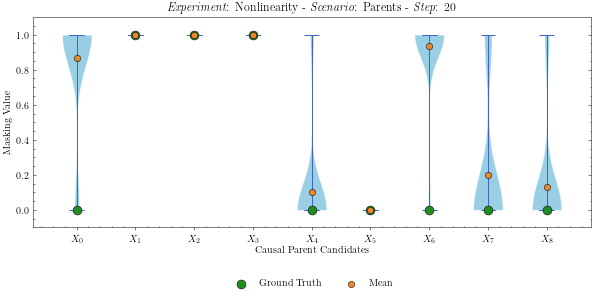

single_nonlinearitytest_scenario-parents_step-3
single Nonlinearity Parents 3


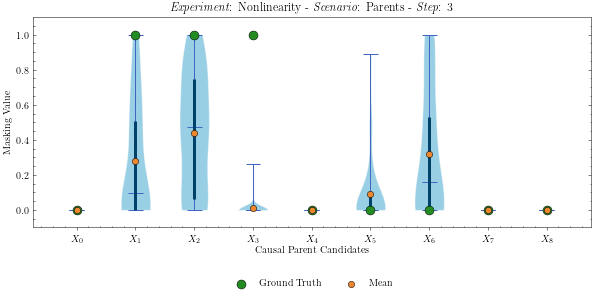

single_nonlinearitytest_scenario-parents_step-4
single Nonlinearity Parents 4


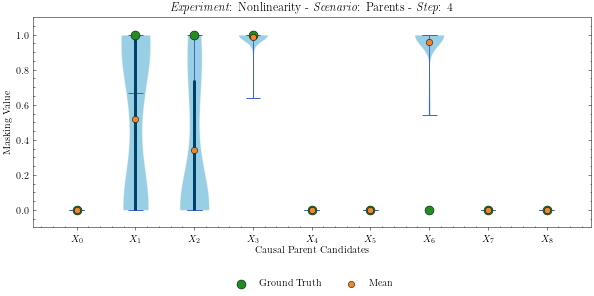

single_nonlinearitytest_scenario-parents_step-5
single Nonlinearity Parents 5


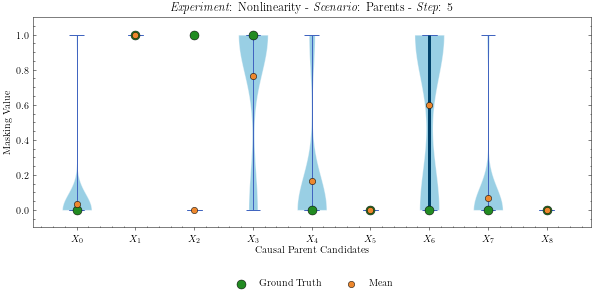

single_nonlinearitytest_scenario-parents_step-6
single Nonlinearity Parents 6


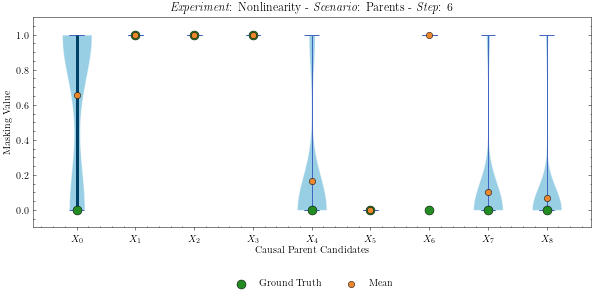

single_nonlinearitytest_scenario-parents_step-7
single Nonlinearity Parents 7


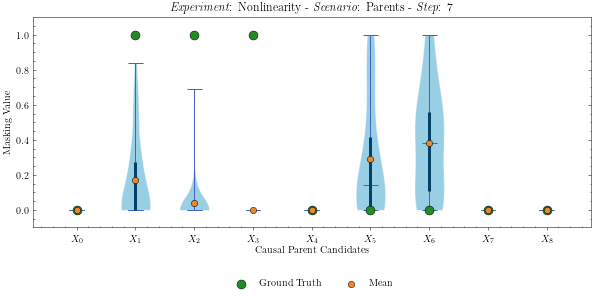

single_nonlinearitytest_scenario-parents_step-8
single Nonlinearity Parents 8


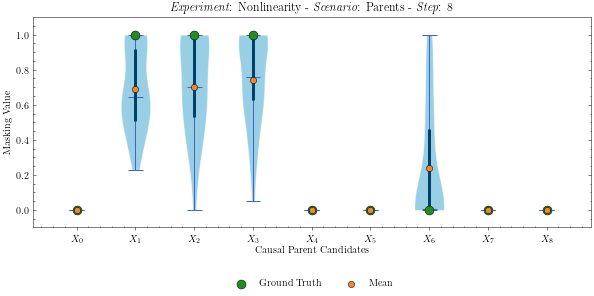

single_nonlinearitytest_scenario-parents_step-9
single Nonlinearity Parents 9


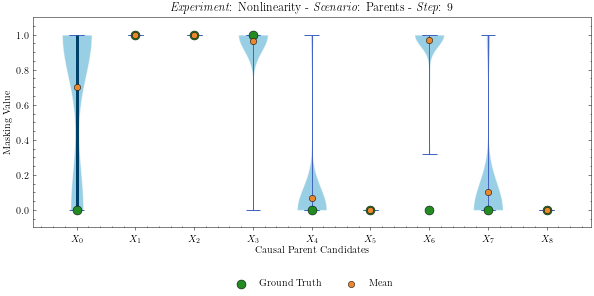

single_nonlinearitytest_scenario-target_step-1
single Nonlinearity Target 1


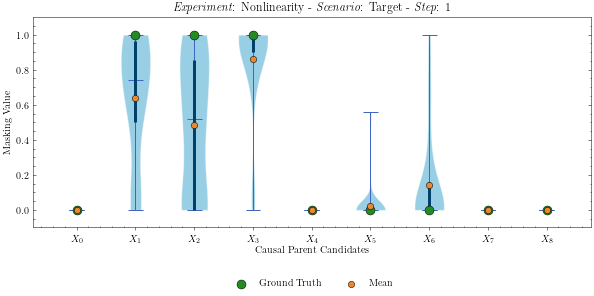

single_nonlinearitytest_scenario-target_step-10
single Nonlinearity Target 10


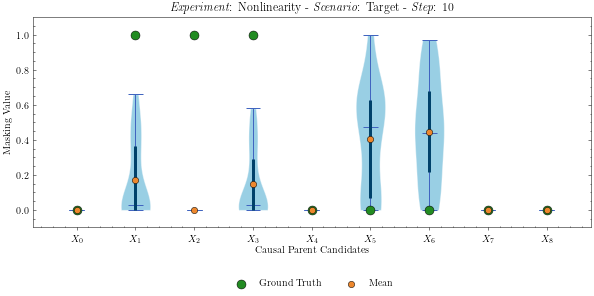

single_nonlinearitytest_scenario-target_step-11
single Nonlinearity Target 11


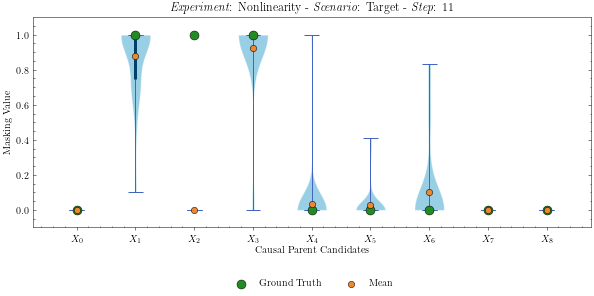

single_nonlinearitytest_scenario-target_step-12
single Nonlinearity Target 12


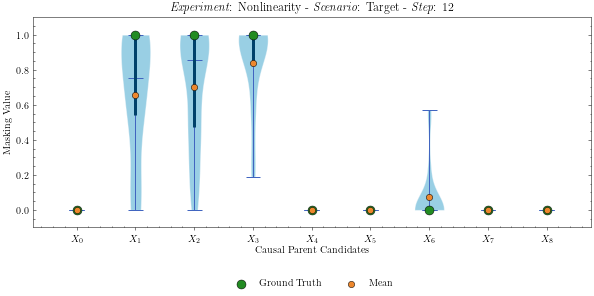

single_nonlinearitytest_scenario-target_step-13
single Nonlinearity Target 13


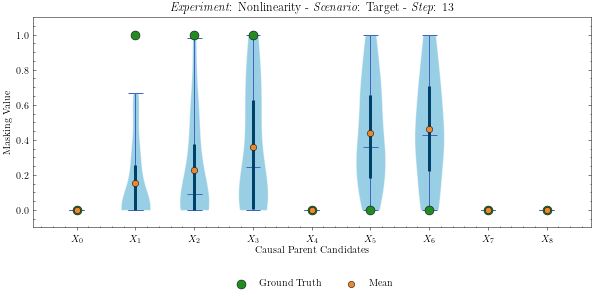

single_nonlinearitytest_scenario-target_step-14
single Nonlinearity Target 14


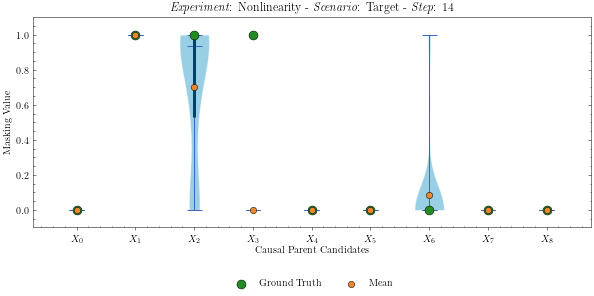

single_nonlinearitytest_scenario-target_step-15
single Nonlinearity Target 15


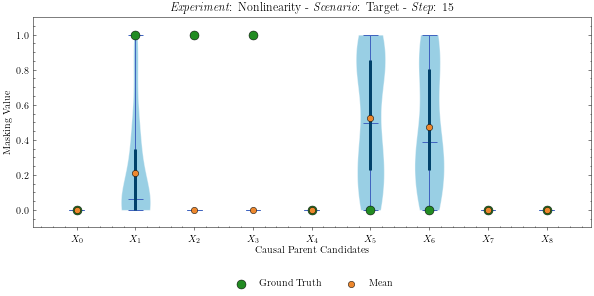

single_nonlinearitytest_scenario-target_step-16
single Nonlinearity Target 16


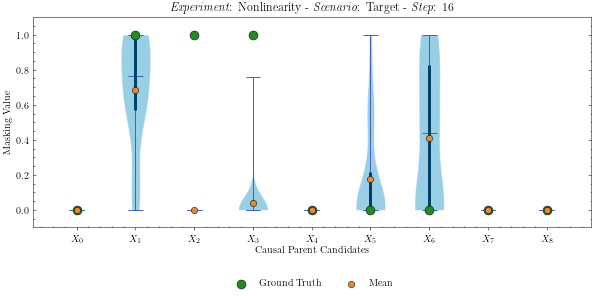

single_nonlinearitytest_scenario-target_step-17
single Nonlinearity Target 17


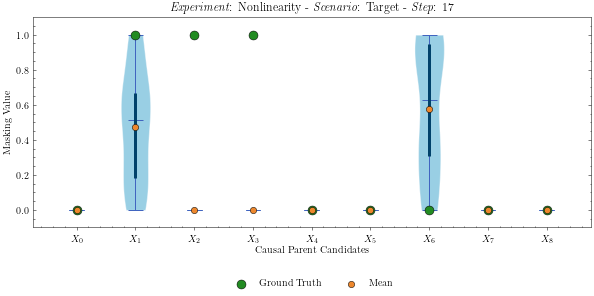

single_nonlinearitytest_scenario-target_step-18
single Nonlinearity Target 18


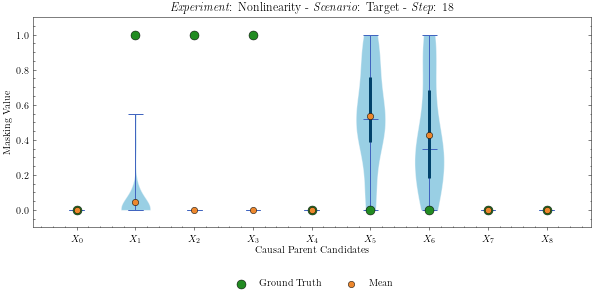

single_nonlinearitytest_scenario-target_step-19
single Nonlinearity Target 19


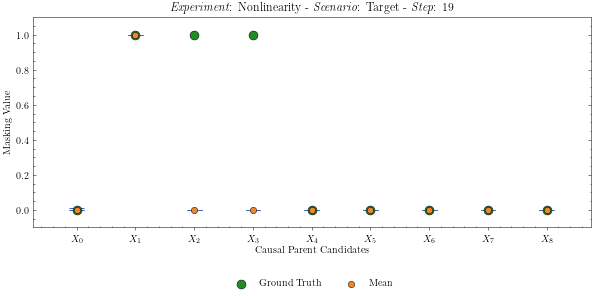

single_nonlinearitytest_scenario-target_step-2
single Nonlinearity Target 2


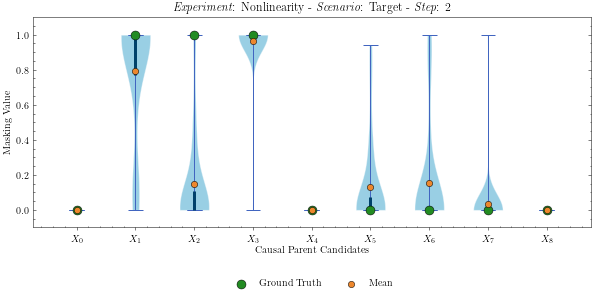

single_nonlinearitytest_scenario-target_step-20
single Nonlinearity Target 20


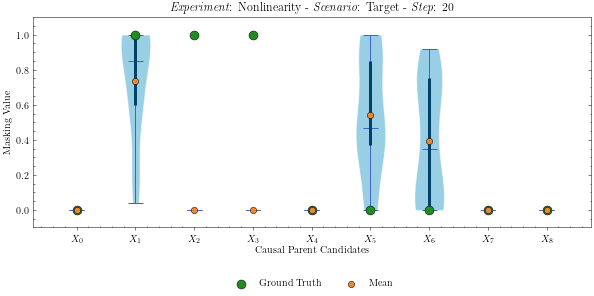

single_nonlinearitytest_scenario-target_step-3
single Nonlinearity Target 3


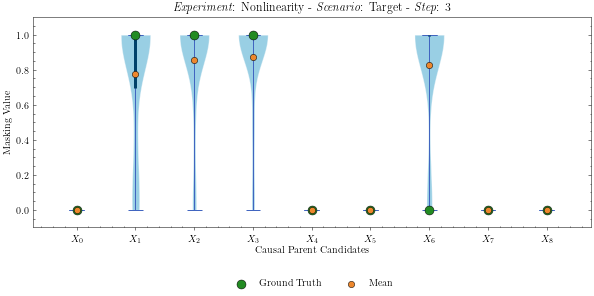

single_nonlinearitytest_scenario-target_step-4
single Nonlinearity Target 4


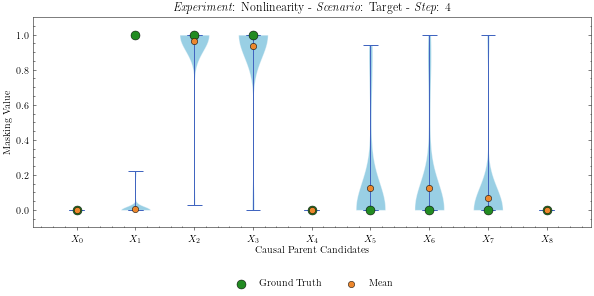

single_nonlinearitytest_scenario-target_step-5
single Nonlinearity Target 5


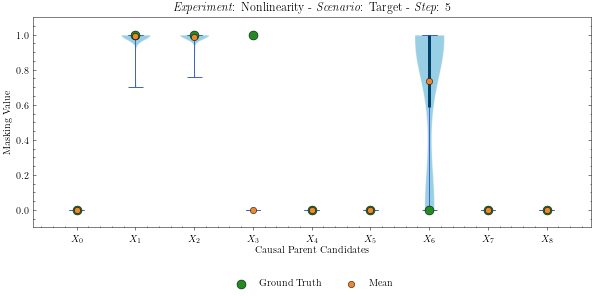

single_nonlinearitytest_scenario-target_step-6
single Nonlinearity Target 6


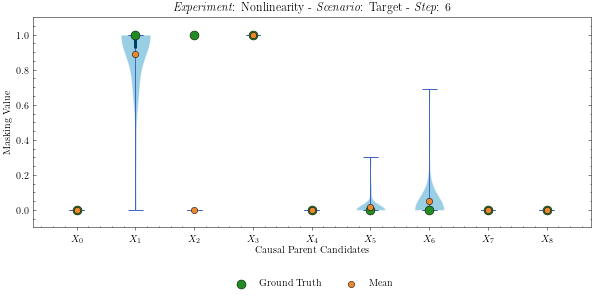

single_nonlinearitytest_scenario-target_step-7
single Nonlinearity Target 7


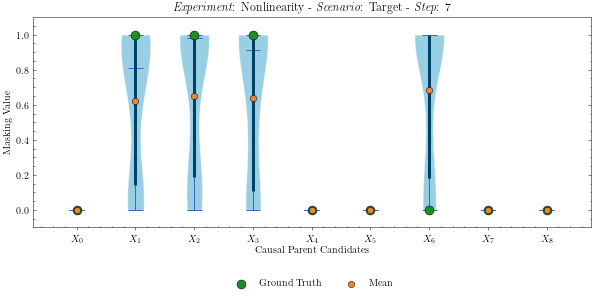

single_nonlinearitytest_scenario-target_step-8
single Nonlinearity Target 8


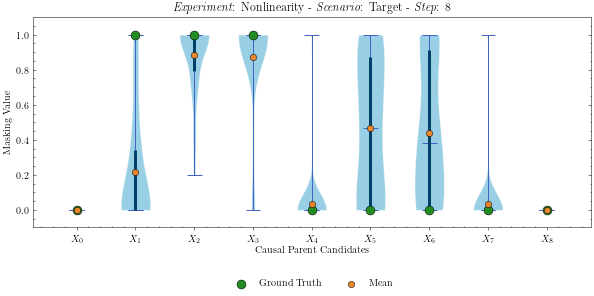

single_nonlinearitytest_scenario-target_step-9
single Nonlinearity Target 9


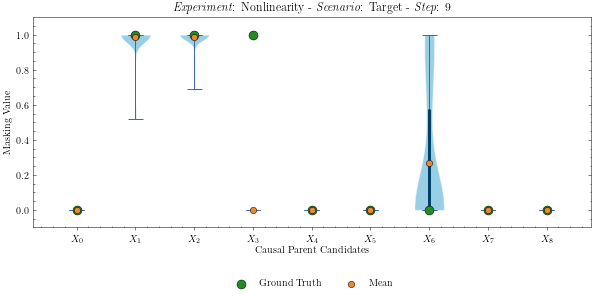

single_samplesizetest_scenario-halflinear_step-1_ss_32
single Samplesize Halflinear 1


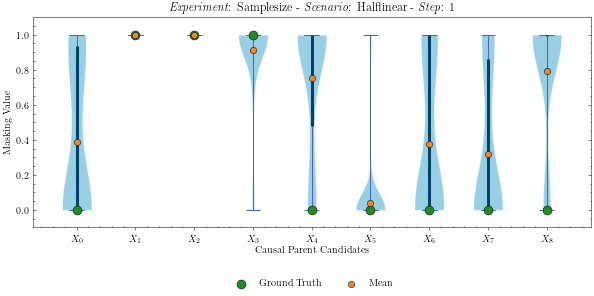

single_samplesizetest_scenario-halflinear_step-2_ss_64
single Samplesize Halflinear 2


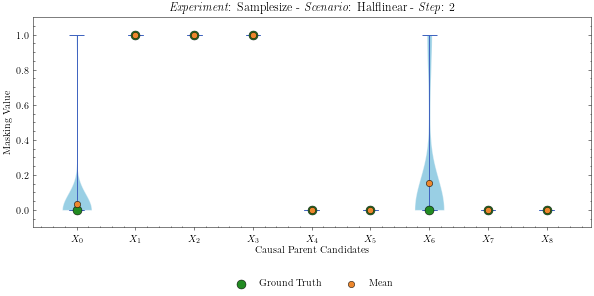

single_samplesizetest_scenario-halflinear_step-3_ss_128
single Samplesize Halflinear 3


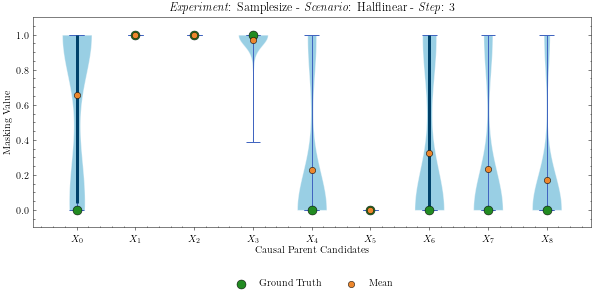

single_samplesizetest_scenario-halflinear_step-4_ss_256
single Samplesize Halflinear 4


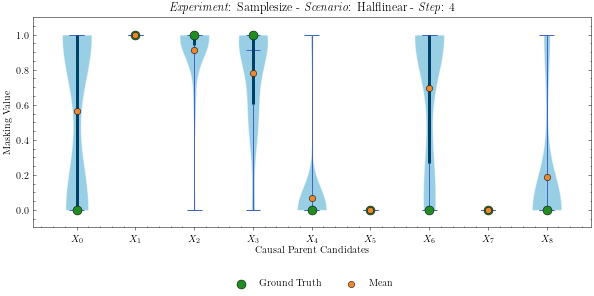

single_samplesizetest_scenario-halflinear_step-5_ss_512
single Samplesize Halflinear 5


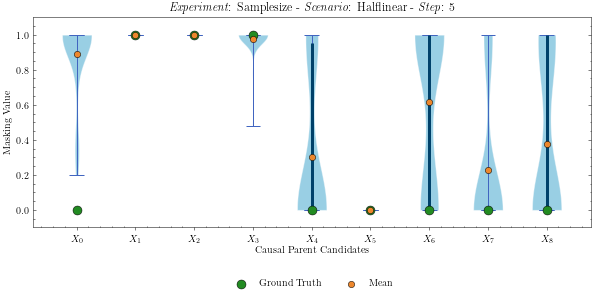

single_samplesizetest_scenario-halflinear_step-6_ss_1024
single Samplesize Halflinear 6


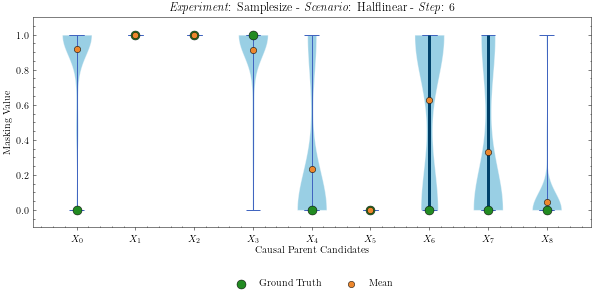

single_samplesizetest_scenario-halflinear_step-7_ss_2048
single Samplesize Halflinear 7


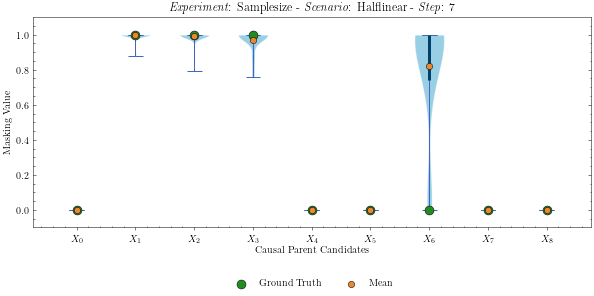

single_samplesizetest_scenario-halflinear_step-8_ss_4096
single Samplesize Halflinear 8


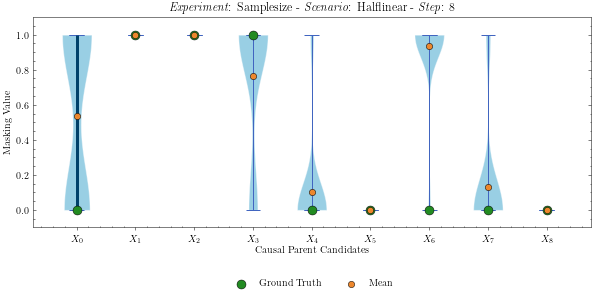

single_samplesizetest_scenario-halflinear_step-9_ss_8192
single Samplesize Halflinear 9


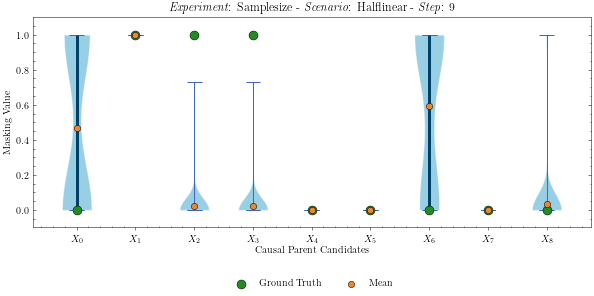

single_samplesizetest_scenario-linear_step-1_ss_32
single Samplesize Linear 1


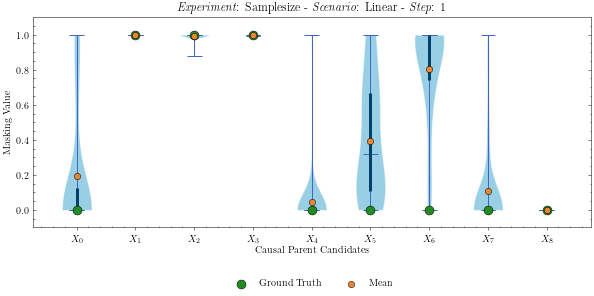

single_samplesizetest_scenario-linear_step-2_ss_64
single Samplesize Linear 2


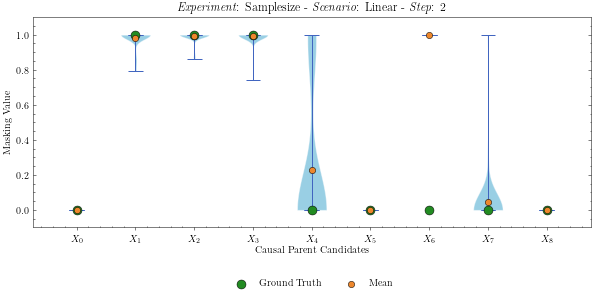

single_samplesizetest_scenario-linear_step-3_ss_128
single Samplesize Linear 3


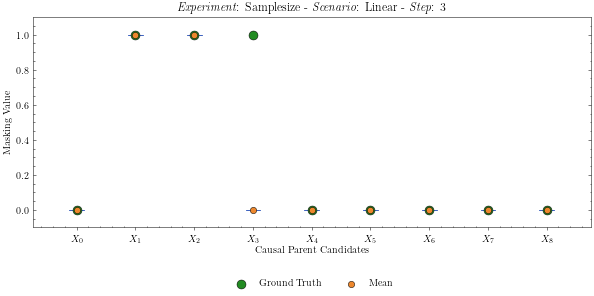

single_samplesizetest_scenario-linear_step-4_ss_256
single Samplesize Linear 4


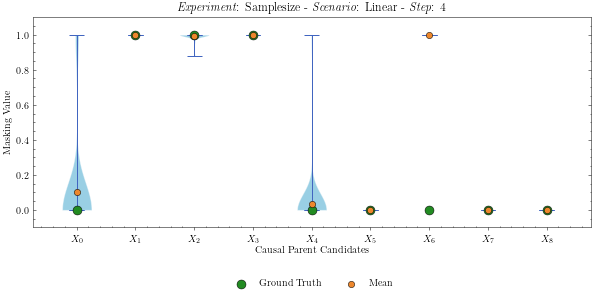

single_samplesizetest_scenario-linear_step-5_ss_512
single Samplesize Linear 5


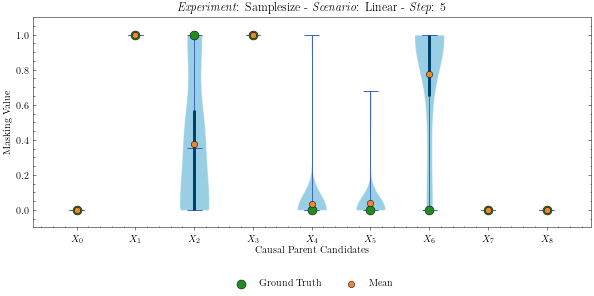

single_samplesizetest_scenario-linear_step-6_ss_1024
single Samplesize Linear 6


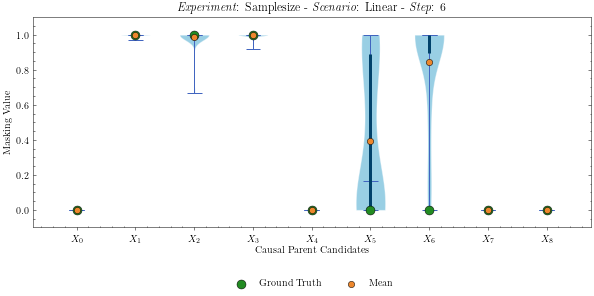

single_samplesizetest_scenario-linear_step-7_ss_2048
single Samplesize Linear 7


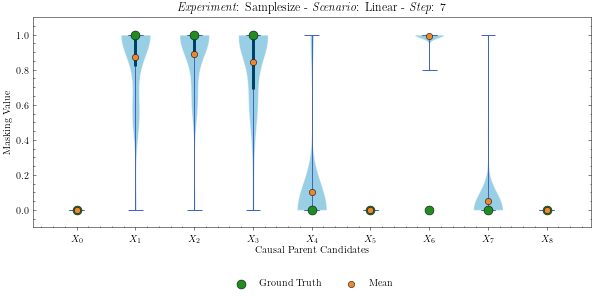

single_samplesizetest_scenario-linear_step-8_ss_4096
single Samplesize Linear 8


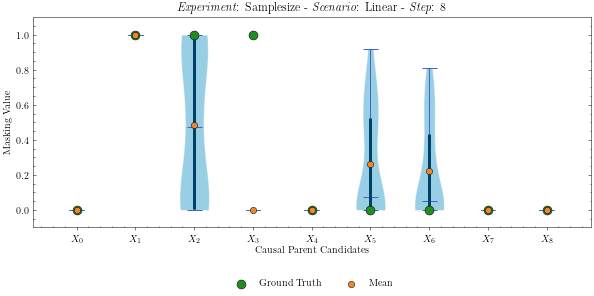

single_samplesizetest_scenario-linear_step-9_ss_8192
single Samplesize Linear 9


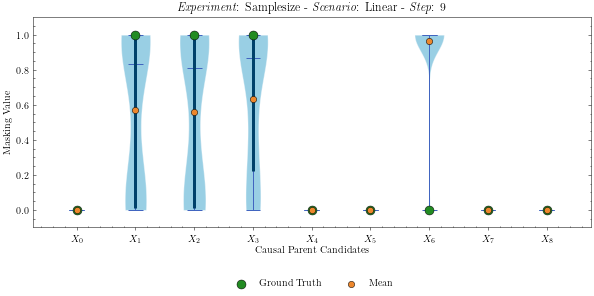

single_samplesizetest_scenario-nonlinear_step-1_ss_32
single Samplesize Nonlinear 1


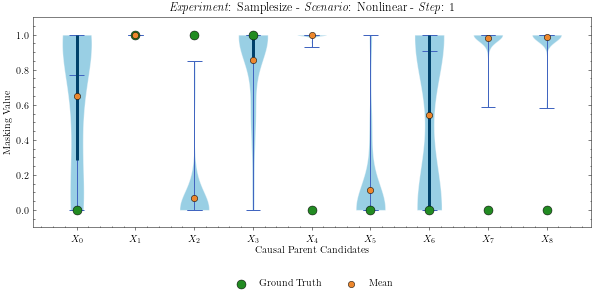

single_samplesizetest_scenario-nonlinear_step-2_ss_64
single Samplesize Nonlinear 2


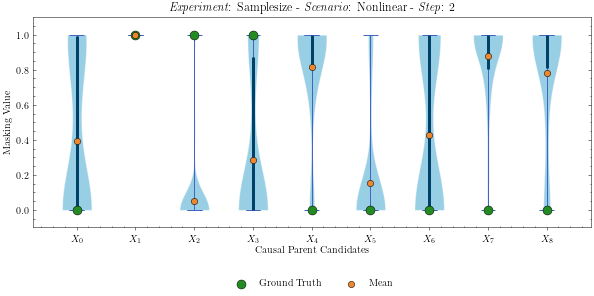

single_samplesizetest_scenario-nonlinear_step-3_ss_128
single Samplesize Nonlinear 3


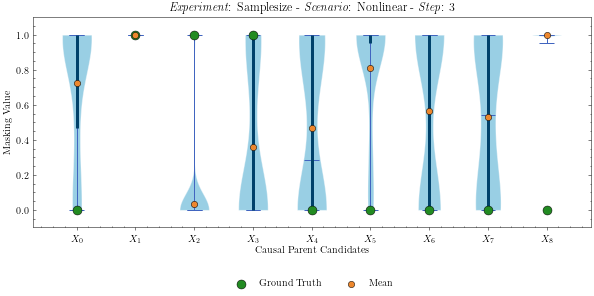

single_samplesizetest_scenario-nonlinear_step-4_ss_256
single Samplesize Nonlinear 4


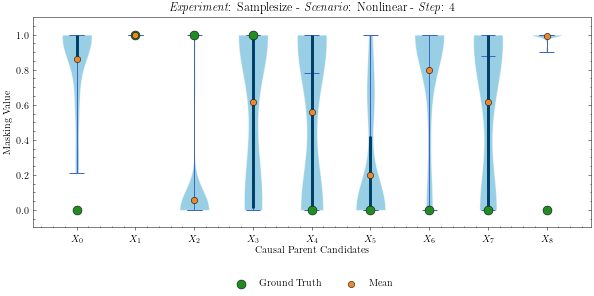

single_samplesizetest_scenario-nonlinear_step-5_ss_512
single Samplesize Nonlinear 5


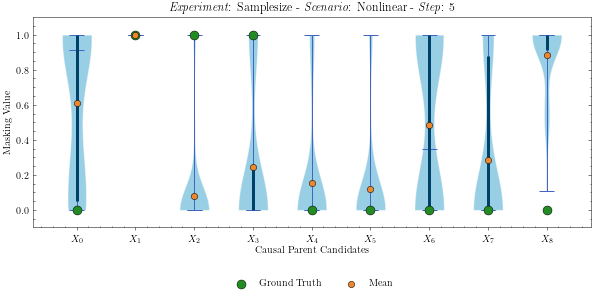

single_samplesizetest_scenario-nonlinear_step-6_ss_1024
single Samplesize Nonlinear 6


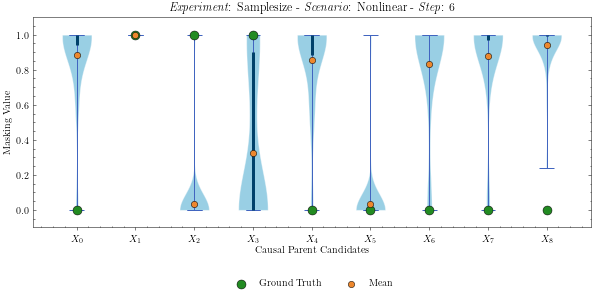

single_samplesizetest_scenario-nonlinear_step-7_ss_2048
single Samplesize Nonlinear 7


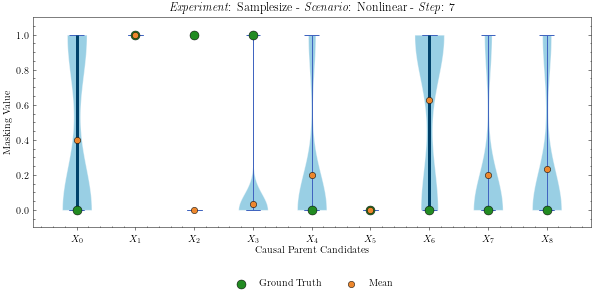

single_samplesizetest_scenario-nonlinear_step-8_ss_4096
single Samplesize Nonlinear 8


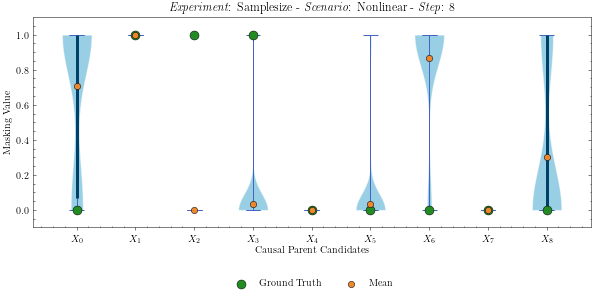

single_samplesizetest_scenario-nonlinear_step-9_ss_8192
single Samplesize Nonlinear 9


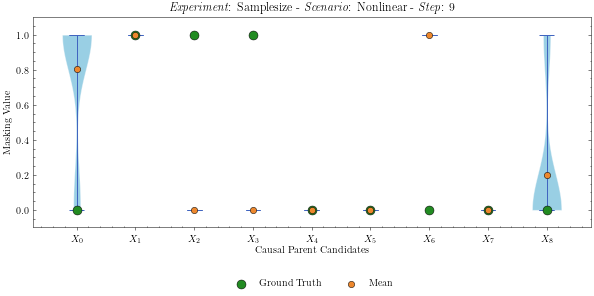

multi_confoundertest_scenario-1
multi Confounder 1 None


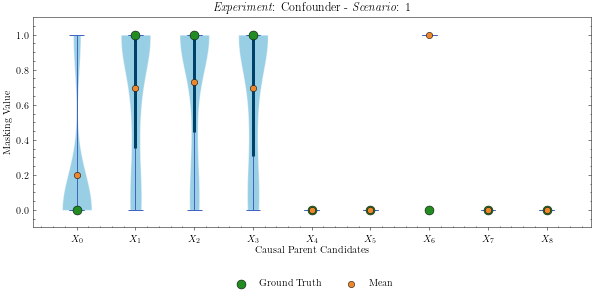

multi_confoundertest_scenario-2
multi Confounder 2 None


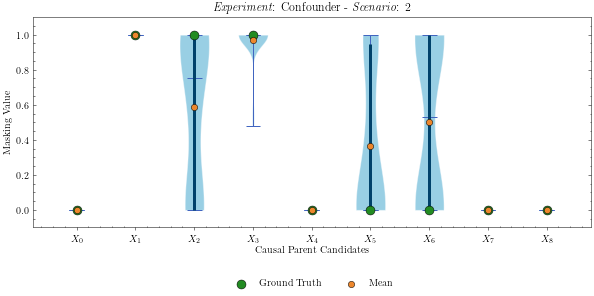

multi_confoundertest_scenario-3
multi Confounder 3 None


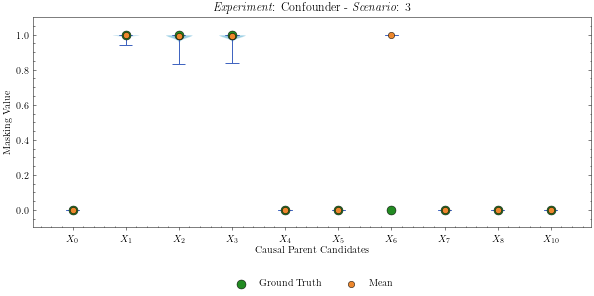

multi_interventionstest_scenario-do_step-1
multi Interventions Do 1


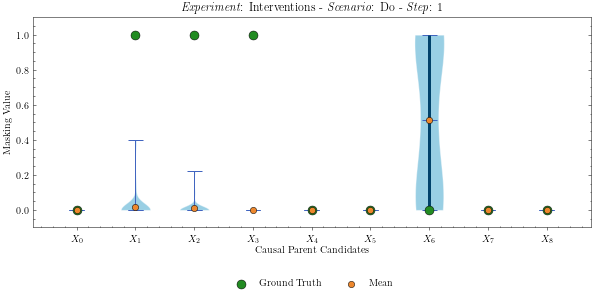

multi_interventionstest_scenario-do_step-10
multi Interventions Do 10


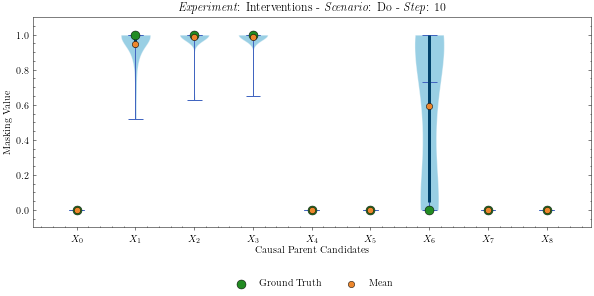

multi_interventionstest_scenario-do_step-11
multi Interventions Do 11


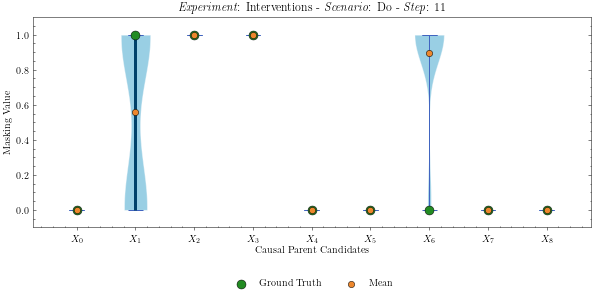

multi_interventionstest_scenario-do_step-12
multi Interventions Do 12


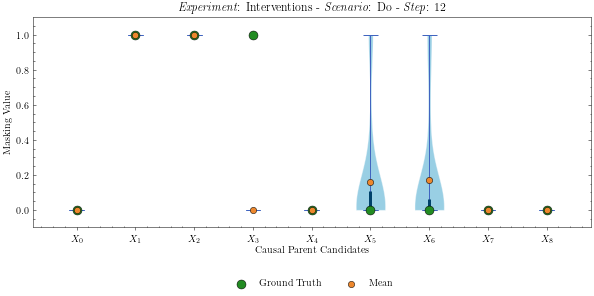

multi_interventionstest_scenario-do_step-2
multi Interventions Do 2


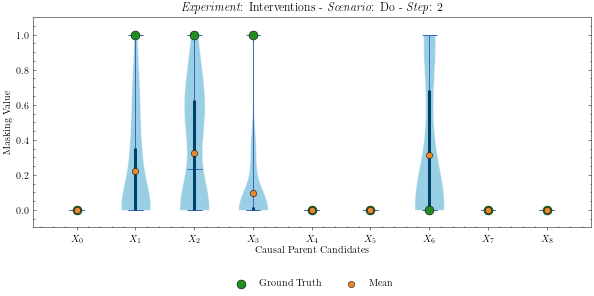

multi_interventionstest_scenario-do_step-3
multi Interventions Do 3


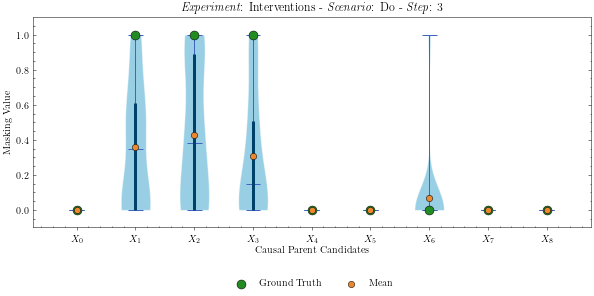

multi_interventionstest_scenario-do_step-4
multi Interventions Do 4


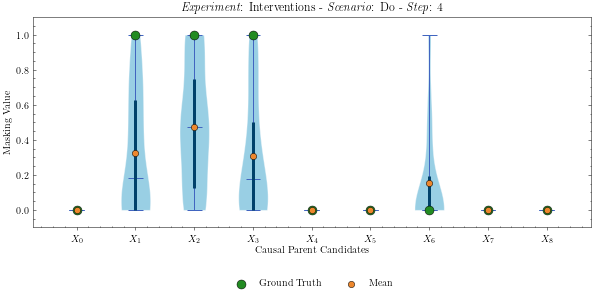

multi_interventionstest_scenario-do_step-5
multi Interventions Do 5


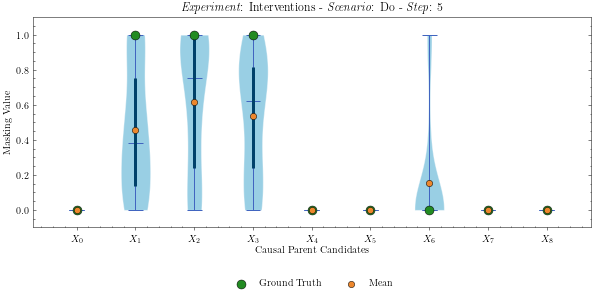

multi_interventionstest_scenario-do_step-6
multi Interventions Do 6


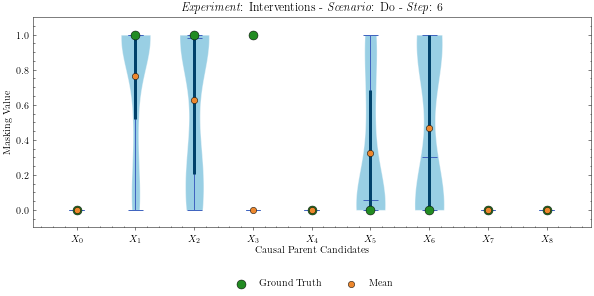

multi_interventionstest_scenario-do_step-7
multi Interventions Do 7


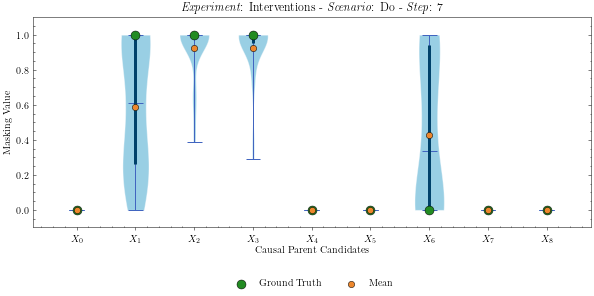

multi_interventionstest_scenario-do_step-8
multi Interventions Do 8


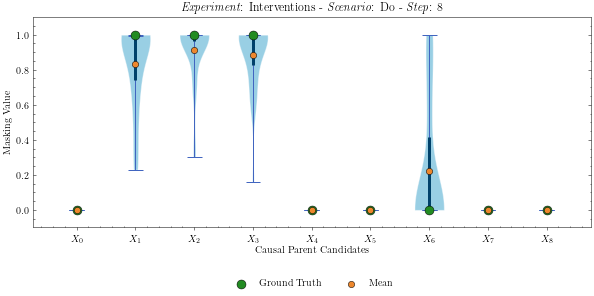

multi_interventionstest_scenario-do_step-9
multi Interventions Do 9


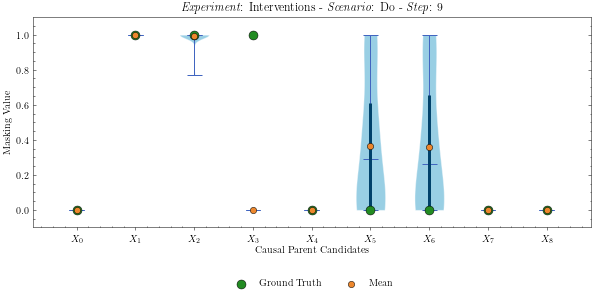

multi_noisetest_dist-cauchy_args-loc=-5,scale=1,source=scipy_scenario-parents_step-5
multi Noise Parents 5


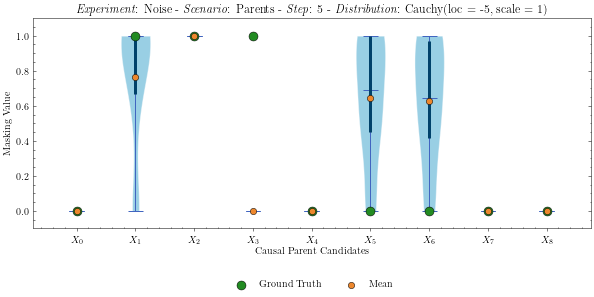

multi_noisetest_dist-cauchy_args-loc=0,scale=1,source=scipy_scenario-parents_step-1
multi Noise Parents 1


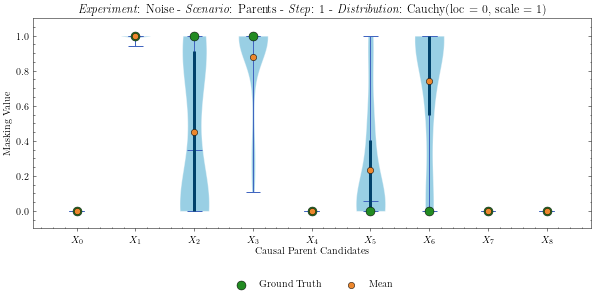

multi_noisetest_dist-cauchy_args-loc=0,scale=2,source=scipy_scenario-parents_step-2
multi Noise Parents 2


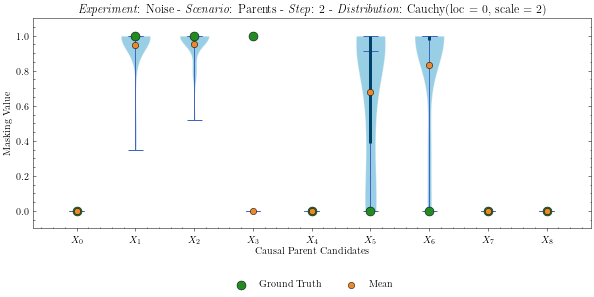

multi_noisetest_dist-cauchy_args-loc=0,scale=5,source=scipy_scenario-parents_step-3
multi Noise Parents 3


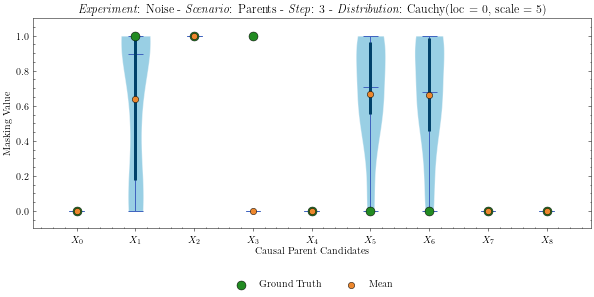

multi_noisetest_dist-cauchy_args-loc=5,scale=1,source=scipy_scenario-parents_step-4
multi Noise Parents 4


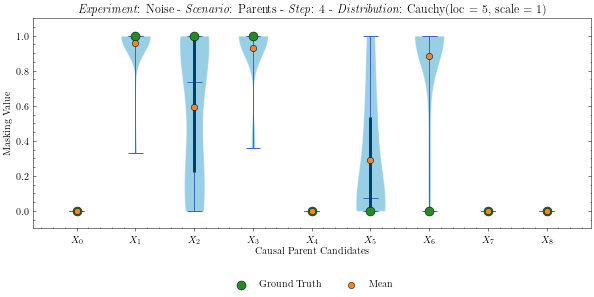

multi_noisetest_dist-exponential_args-scale=1,source=numpy_scenario-parents_step-1
multi Noise Parents 1


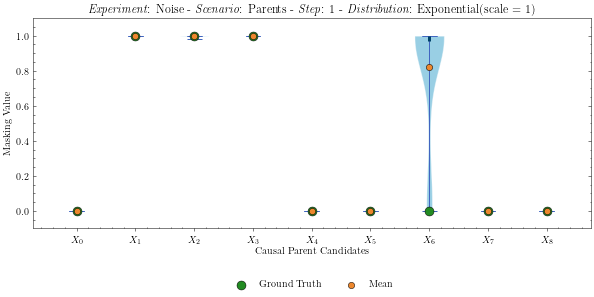

multi_noisetest_dist-exponential_args-scale=10,source=numpy_scenario-parents_step-3
multi Noise Parents 3


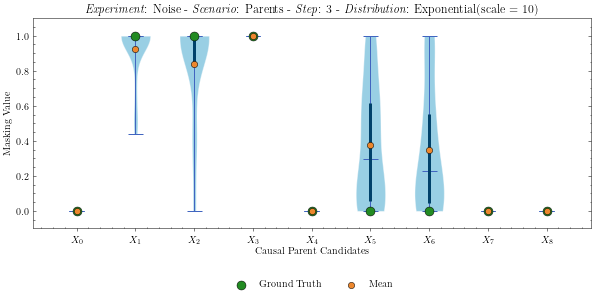

multi_noisetest_dist-exponential_args-scale=30,source=numpy_scenario-parents_step-4
multi Noise Parents 4


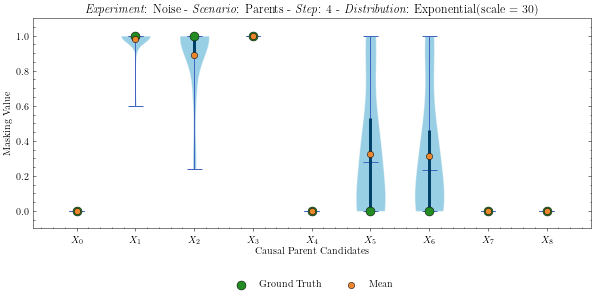

multi_noisetest_dist-exponential_args-scale=5,source=numpy_scenario-parents_step-2
multi Noise Parents 2


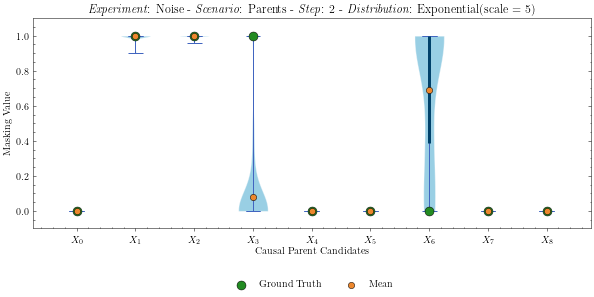

multi_noisetest_dist-normal_args-loc=-5,scale=1,source=numpy_scenario-parents_step-5
multi Noise Parents 5


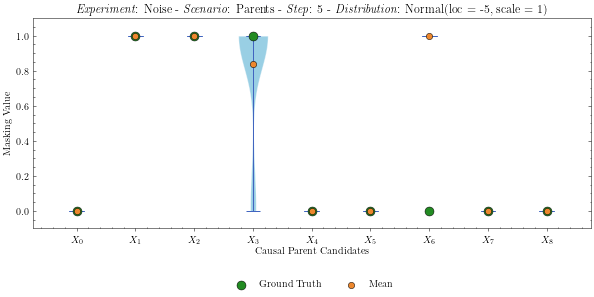

multi_noisetest_dist-normal_args-loc=0,scale=1,source=numpy_scenario-parents_step-1
multi Noise Parents 1


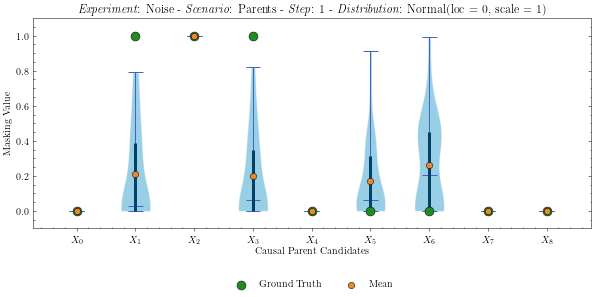

multi_noisetest_dist-normal_args-loc=0,scale=2,source=numpy_scenario-parents_step-2
multi Noise Parents 2


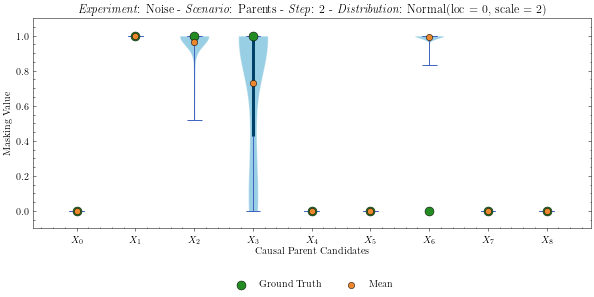

multi_noisetest_dist-normal_args-loc=0,scale=5,source=numpy_scenario-parents_step-3
multi Noise Parents 3


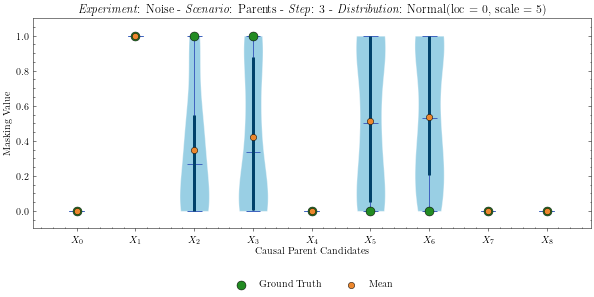

multi_noisetest_dist-normal_args-loc=5,scale=1,source=numpy_scenario-parents_step-4
multi Noise Parents 4


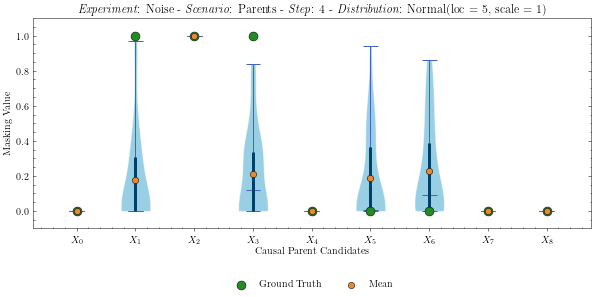

multi_nonlinearitytest_scenario-target_step-1
multi Nonlinearity Target 1


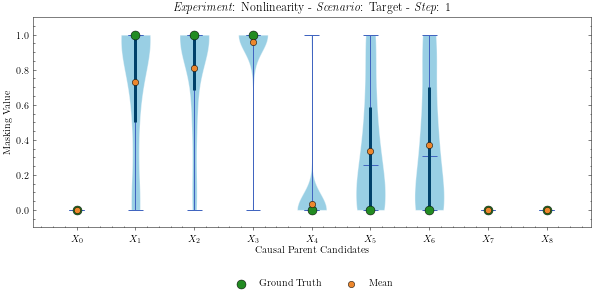

multi_nonlinearitytest_scenario-target_step-10
multi Nonlinearity Target 10


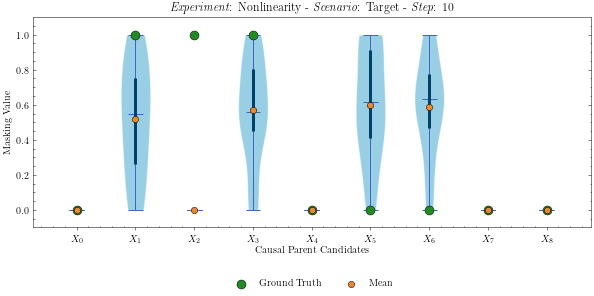

multi_nonlinearitytest_scenario-target_step-11
multi Nonlinearity Target 11


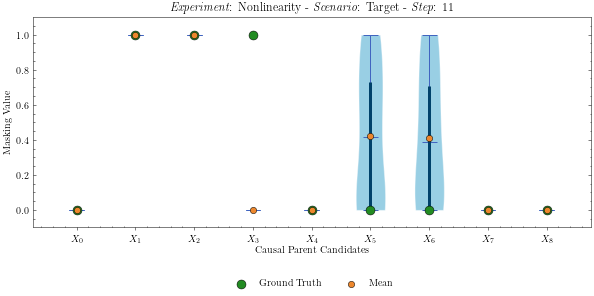

multi_nonlinearitytest_scenario-target_step-12
multi Nonlinearity Target 12


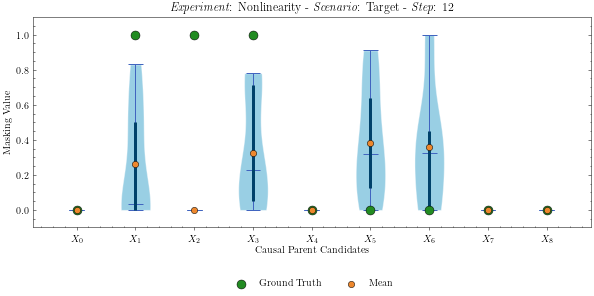

multi_nonlinearitytest_scenario-target_step-13
multi Nonlinearity Target 13


ValueError: zero-size array to reduction operation minimum which has no identity

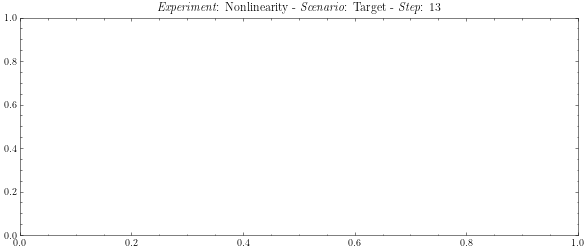

In [10]:
x=3
for i, (name, df) in enumerate(itertools.chain(
    results_single.items(),
    results_multi.items(),
    results_density.items()
)):
    # if i > 1:
    #     break
    print(name)
    gt = ground_truth
    if "confounder" in name and "scenario-3" in name:
        gt = ground_truth_confounded
    plot_violin(df, full_name_builder(name)[0], gt, fname=name)

0.5 rule metrics

In [12]:
def comp_avg_metric(data, metric=accuracy_score):
    avg = 0

    gt = ground_truth
    gt_df = ground_truth_df
    vals = []
    if len(data.columns) == 10:
        gt = ground_truth_confounded
        gt_df = ground_truth_confounded_df
    for i, row in data.iterrows():
        # print(row)
        vals.append(metric(gt, row))
    mean = np.mean(vals)
    std = np.std(vals)
    
    return {"mean": mean, "std": std}

Compute the values for every evaluation

In [13]:
def cer_but_n(df, gt_df, n):
    return ((rounded_df - ground_truth_df).abs().sum(axis=1) <= n).mean()
    

In [14]:

model_names = ["Single", "Multi", "Density"]
experiment_names = ["Interventions", "Nonlinearity", "Confounder", "Samplesize", "Noise"]
long_metric_names = {"acc": "Accuracy", "prec": "Precision", "rec": "Recall", "aupr": "AuPR"}
metrics_names = ["acc",  "aupr"]
metric_to_func = {"acc": accuracy_score, "prec": precision_score, "rec": recall_score, "aupr": average_precision_score}

In [15]:
metrics = {
    experiment: {} for experiment in experiment_names 
}
icp_metrics = {
    experiment: {} for experiment in experiment_names 
}


In [16]:
taus = [str(50)]
exp_results = list(
        # results_density.items(),
#         results_multi.items(),
        results_single.items()
)
nr_res = len(exp_results)
threshold_results = {n: {} for n, v in exp_results}



for name, df in itertools.chain(exp_results):
    _, model, exp_name, scenario_name, dist, args, step = full_name_builder(name)
    model = model.capitalize()

    
    
        
    if exp_name == "Confounder":
        # exp - sce - model - metric -> VALUE
        if scenario_name not in metrics[exp_name]:
            metrics[exp_name][scenario_name] = {}
            
        if model not in metrics[exp_name][scenario_name]:
            metrics[exp_name][scenario_name][model] = {tau: {} for tau in taus}
            
            
    elif exp_name == "Noise":
        # exp - sce - dist - arg - model - metric -> VALUE
        
        if scenario_name not in metrics[exp_name]:
            metrics[exp_name][scenario_name] = {}
            
        if dist not in metrics[exp_name][scenario_name]:
            metrics[exp_name][scenario_name][dist] = {}
            
        if args not in metrics[exp_name][scenario_name][dist]:
            metrics[exp_name][scenario_name][dist][args] = {}
            
        if model not in metrics[exp_name][scenario_name]:
            metrics[exp_name][scenario_name][dist][args][model] = {tau: {} for tau in taus}
        
    else:
        # exp - sce - step - model - metric -> VALUE
        
        if scenario_name not in metrics[exp_name]:
            metrics[exp_name][scenario_name] = {}
            
        if step not in metrics[exp_name][scenario_name]:
            metrics[exp_name][scenario_name][step] = {}
            
        if model not in metrics[exp_name][scenario_name][step]:
            metrics[exp_name][scenario_name][step][model] = {tau: {} for tau in taus}

    
    for tau in taus:
        tau_float = int(tau) / 100
        rounded_df = pd.DataFrame(np.ones_like(df.to_numpy(), dtype=int), columns=df.columns)
        rounded_df[df < tau_float] = 0
#         for var in df:
#             gt = named_ground_truth[var]
#             if gt == 0:
#                 rounded_df.loc[(df.loc[:, var] < gt + tau_float) | (df.loc[:, var] == 0), var] = 0
#             else:
#                 rounded_df.loc[(df.loc[:, var] < gt - tau_float) | (df.loc[:, var] == 0), var] = 0
        threshold_results[name][tau] = rounded_df
        
        
        if exp_name == "Confounder":
            metrics[exp_name][scenario_name][model][tau]["acc"] = comp_avg_metric(rounded_df, accuracy_score)
            metrics[exp_name][scenario_name][model][tau]["prec"] = comp_avg_metric(rounded_df, precision_score)
            metrics[exp_name][scenario_name][model][tau]["rec"] = comp_avg_metric(rounded_df, recall_score)
            metrics[exp_name][scenario_name][model][tau]["aupr"] = comp_avg_metric(rounded_df, average_precision_score)
#             metrics[exp_name][scenario_name][model][tau]["cer1"] = cer_but_n(rounded_df,ground_truth_df, 1)
#             metrics[exp_name][scenario_name][model][tau]["cer2"] = cer_but_n(rounded_df,ground_truth_df, 2)
        
        elif exp_name == "Noise":
            metrics[exp_name][scenario_name][dist][args][model][tau]["acc"] = comp_avg_metric(rounded_df, accuracy_score)
            metrics[exp_name][scenario_name][dist][args][model][tau]["prec"] = comp_avg_metric(rounded_df, precision_score)
            metrics[exp_name][scenario_name][dist][args][model][tau]["rec"] = comp_avg_metric(rounded_df, recall_score)
            metrics[exp_name][scenario_name][dist][args][model][tau]["aupr"] = comp_avg_metric(rounded_df, average_precision_score)
#             metrics[exp_name][scenario_name][dist][args][model][tau]["cer1"] = cer_but_n(rounded_df,ground_truth_df, 1)
#             metrics[exp_name][scenario_name][dist][args][model][tau]["cer2"] = cer_but_n(rounded_df,ground_truth_df, 2)
        else:
        
            metrics[exp_name][scenario_name][step][model][tau]["acc"] = comp_avg_metric(rounded_df, accuracy_score)
            metrics[exp_name][scenario_name][step][model][tau]["prec"] = comp_avg_metric(rounded_df, precision_score)
            metrics[exp_name][scenario_name][step][model][tau]["rec"] = comp_avg_metric(rounded_df, recall_score)
            metrics[exp_name][scenario_name][step][model][tau]["aupr"] = comp_avg_metric(rounded_df, average_precision_score)
#             metrics[exp_name][scenario_name][step][model][tau]["cer1"] = cer_but_n(rounded_df,ground_truth_df, 1)
#             metrics[exp_name][scenario_name][step][model][tau]["cer2"] = cer_but_n(rounded_df,ground_truth_df, 2)
        

single Confounder 1 None
single Confounder 2 None
single Confounder 3 None
single Interventions Do 1


/home/michael/anaconda3/envs/causalpy/lib/python3.7/site-packages/scikit_learn-0.22.1-py3.7-linux-x86_64.egg/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


single Interventions Do 10
single Interventions Do 11
single Interventions Do 12
single Interventions Do 2
single Interventions Do 3
single Interventions Do 4
single Interventions Do 5
single Interventions Do 6
single Interventions Do 7
single Interventions Do 8
single Interventions Do 9
single Interventions Meanshift 1
single Interventions Meanshift 10
single Interventions Meanshift 11
single Interventions Meanshift 12
single Interventions Meanshift 2
single Interventions Meanshift 3
single Interventions Meanshift 4
single Interventions Meanshift 5
single Interventions Meanshift 6
single Interventions Meanshift 7
single Interventions Meanshift 8
single Interventions Meanshift 9
single Interventions Scaling 1
single Interventions Scaling 10
single Interventions Scaling 11
single Interventions Scaling 12
single Interventions Scaling 2
single Interventions Scaling 3
single Interventions Scaling 4
single Interventions Scaling 5
single Interventions Scaling 6
single Interventions Scaling 7

In [17]:
zero_baseline = {}
zeros = pd.DataFrame(np.zeros_like(df), columns=df.columns)
for i, metric in enumerate(metrics_names):
    zero_baseline[metric] = comp_avg_metric(zeros, metric_to_func[metric])

In [18]:
zero_baseline

{'acc': {'mean': 0.6666666666666669, 'std': 2.220446049250313e-16},
 'aupr': {'mean': 0.3333333333333334, 'std': 1.1102230246251565e-16}}

In [19]:
# print(named_ground_truth)
# ref_confounded = pd.DataFrame.from_dict([named_ground_truth])
# print(ref)
# precision_score(results_icp[list(results_icp.keys())[0]].loc[0], .loc[0])


taus = [str(50)]
exp_results = list(
        results_icp.items()
)
nr_res = len(exp_results)

for name, df in itertools.chain(exp_results):
    _, model, exp_name, scenario_name, dist, args, step = full_name_builder(name)
    model = model.capitalize()

    if exp_name == "Confounder":
        # exp - sce - model - metric -> VALUE
        if scenario_name not in icp_metrics[exp_name]:
            icp_metrics[exp_name][scenario_name] = {}
            
        if model not in icp_metrics[exp_name][scenario_name]:
            icp_metrics[exp_name][scenario_name][model] = {tau: {} for tau in taus}
            
    elif exp_name == "Noise":
        # exp - sce - dist - arg - model - metric -> VALUE
        
        if scenario_name not in icp_metrics[exp_name]:
            icp_metrics[exp_name][scenario_name] = {}
            
        if dist not in icp_metrics[exp_name][scenario_name]:
            icp_metrics[exp_name][scenario_name][dist] = {}
            
        if args not in icp_metrics[exp_name][scenario_name][dist]:
            icp_metrics[exp_name][scenario_name][dist][args] = {}
            
        if model not in icp_metrics[exp_name][scenario_name]:
            icp_metrics[exp_name][scenario_name][dist][args][model] = {tau: {} for tau in taus}
        
    else:
        # exp - sce - step - model - metric -> VALUE
        
        if scenario_name not in icp_metrics[exp_name]:
            icp_metrics[exp_name][scenario_name] = {}
            
        if step not in icp_metrics[exp_name][scenario_name]:
            icp_metrics[exp_name][scenario_name][step] = {}
            
        if model not in icp_metrics[exp_name][scenario_name][step]:
            icp_metrics[exp_name][scenario_name][step][model] = {tau: {} for tau in taus}

    for tau in taus:
        tau_float = int(tau) / 100
        rounded_df = pd.DataFrame(np.ones_like(df.to_numpy(), dtype=int), columns=df.columns)
        rounded_df[df < tau_float] = 0
        
        
        if exp_name == "Confounder":
            icp_metrics[exp_name][scenario_name][model][tau]["acc"] = comp_avg_metric(rounded_df, accuracy_score)
            icp_metrics[exp_name][scenario_name][model][tau]["prec"] = comp_avg_metric(rounded_df, precision_score)
            icp_metrics[exp_name][scenario_name][model][tau]["rec"] = comp_avg_metric(rounded_df, recall_score)
            icp_metrics[exp_name][scenario_name][model][tau]["aupr"] = comp_avg_metric(rounded_df, average_precision_score)
        
        elif exp_name == "Noise":
            icp_metrics[exp_name][scenario_name][dist][args][model][tau]["acc"] = comp_avg_metric(rounded_df, accuracy_score)
            icp_metrics[exp_name][scenario_name][dist][args][model][tau]["prec"] = comp_avg_metric(rounded_df, precision_score)
            icp_metrics[exp_name][scenario_name][dist][args][model][tau]["rec"] = comp_avg_metric(rounded_df, recall_score)
            icp_metrics[exp_name][scenario_name][dist][args][model][tau]["aupr"] = comp_avg_metric(rounded_df, average_precision_score)
        else:
            icp_metrics[exp_name][scenario_name][step][model][tau]["acc"] = comp_avg_metric(rounded_df, accuracy_score)
            icp_metrics[exp_name][scenario_name][step][model][tau]["prec"] = comp_avg_metric(rounded_df, precision_score)
            icp_metrics[exp_name][scenario_name][step][model][tau]["rec"] = comp_avg_metric(rounded_df, recall_score)
            icp_metrics[exp_name][scenario_name][step][model][tau]["aupr"] = comp_avg_metric(rounded_df, average_precision_score)
        

icp Confounder 1 None
icp Confounder 2 None
icp Confounder 3 None
icp Interventions Do 0
icp Interventions Do 1
icp Interventions Do 10
icp Interventions Do 2
icp Interventions Do 3
icp Interventions Do 4
icp Interventions Do 5
icp Interventions Do 6
icp Interventions Do 7
icp Interventions Do 8
icp Interventions Do 9
icp Interventions Meanshift 0
icp Interventions Meanshift 1
icp Interventions Meanshift 10
icp Interventions Meanshift 2
icp Interventions Meanshift 3
icp Interventions Meanshift 4
icp Interventions Meanshift 5
icp Interventions Meanshift 6
icp Interventions Meanshift 7
icp Interventions Meanshift 8
icp Interventions Meanshift 9
icp Interventions Scaling 0
icp Interventions Scaling 1
icp Interventions Scaling 10
icp Interventions Scaling 2
icp Interventions Scaling 3
icp Interventions Scaling 4
icp Interventions Scaling 5
icp Interventions Scaling 6
icp Interventions Scaling 7
icp Interventions Scaling 8
icp Interventions Scaling 9
icp Noise All 1
icp Noise Target 1
icp N

In [ ]:
icp_metrics[exp]

In [20]:
def step_to_name(experiment, step_name):
    if experiment == "Samplesize":
        return str(2**(int(step_name)+4))
    else:
        return step_name
    
    

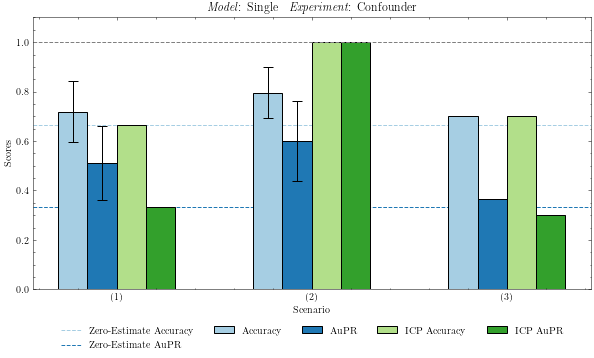

KeyError: 'Multi'

In [46]:
exp = "Confounder"
scenarios = list(metrics[exp].keys())
for model in model_names:
    for tau in taus:
        data = {}
        icp = {}
        for metric in metrics_names:
            data[metric] = [metrics[exp][scenario][model][tau][metric] for scenario in scenarios]
        for metric in metrics_names:
            icp[metric] = [icp_metrics[exp][scenario]["Icp"][tau][metric] for scenario in scenarios]

        x = np.arange(len(scenarios))  # the label locations
        width = 0.15  # the width of the bars
        
        fig, ax = plt.subplots(figsize=(10, 5))

        prop_cycler = ax._get_lines.prop_cycler
        colors = plt.get_cmap("Paired").colors
        
#         colors = [next(cmap)["color"] for _ in range(2 * len(metrics_names))]
        plt.gca().set_prop_cycle(None)

        nr_metrics = 2 * len(metrics_names)

        if nr_metrics % 2 == 0:
            offset = nr_metrics - 1
            div = 2
            dist = 2
        else:
            div = 1
            dist = 1
            offset = nr_metrics // 2

        rects = []
        for i, metric in enumerate(metrics_names):
        
            rects.append(
                ax.bar(
                    x + (i * dist - offset) * width / div, 
                    [e["mean"] for e in data[metric]], 
                    width, 
                    color=colors[i],
                    yerr=[e["std"] for e in data[metric]],
                    label=long_metric_names[metric], 
                    edgecolor="black",
                    capsize=5
                )
            )
            if zero_baseline[metric]["mean"] > 0:
                ax.axhline(y=zero_baseline[metric]["mean"], color=colors[i], linestyle='--', label=f"Zero-Estimate {long_metric_names[metric]}", zorder=0)
        
        for i, metric in enumerate(metrics_names, nr_metrics // 2):
        
            rects.append(
                ax.bar(
                    x + (i * dist - offset) * width / div, 
                    [e["mean"] for e in icp[metric]], 
                    width, 
                    color=colors[i],
                    label=f"ICP {long_metric_names[metric]}", 
                    edgecolor="black",
                    capsize=5
                )
            )
        horiz_line = ax.axhline(y=1, color='grey', linestyle='--')
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Scores')
        ax.set_xlabel('Scenario')
        ax.set_ylim(0, 1.1)
        ax.set_title(r"\textit{Model}: " + model + r"\quad \textit{Experiment}: " + exp)
        ax.set_xticks(x)
        ax.set_xticklabels([f"({s})" for s in scenarios])
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          ncol=5, fancybox=True, shadow=True)
        plt.savefig(f"/home/michael/Desktop/nonsense/{model}_{exp}_{tau}.pdf")
        plt.show()




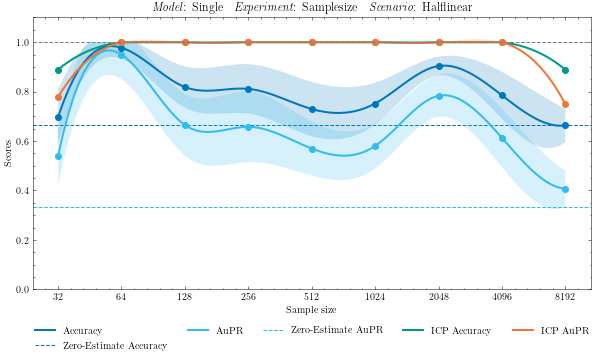

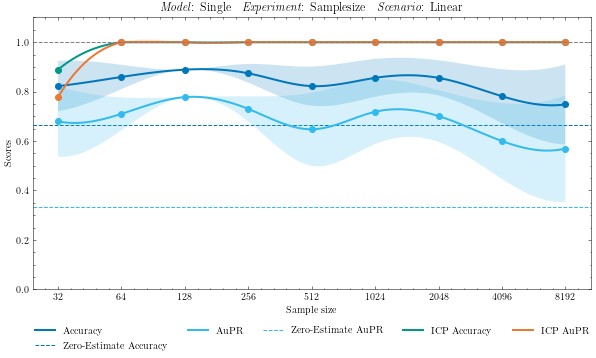

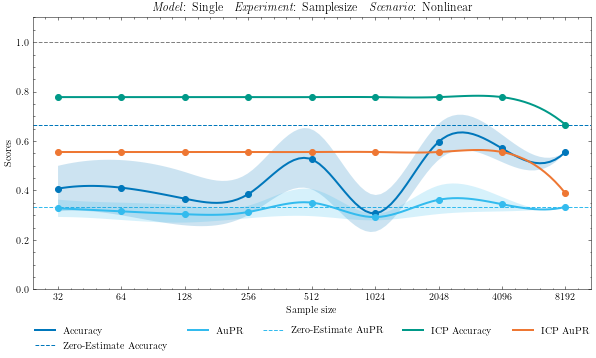

KeyError: 'Multi'

In [41]:
exp = "Samplesize"
scenarios = list(metrics[exp].keys())

for model in model_names:
    for model in model_names:
        for scenario in scenarios:
            for tau in taus:
                data = {}
                icp = {}
                for metric in metrics_names:
                    data[metric] = {
                        step: metrics[exp][scenario][step][model][tau][metric]
                        for step in metrics[exp][scenario].keys()
                    }
                    icp[metric] = {
                        step: icp_metrics[exp][scenario][step]["Icp"][tau][metric]
                        for step in icp_metrics[exp][scenario].keys()
                    }
                
                    
                nr_metrics = len(metrics_names)
                labels = [step_to_name(exp, step) for step in data[metric]]
                
                x = np.arange(len([int(label) for label in labels]))
                
                fig, ax = plt.subplots(figsize=(10, 5))
                
                prop_cycler = ax._get_lines.prop_cycler
                colors = [next(prop_cycler)["color"] for _ in range(2*len(metrics_names))]
                plt.gca().set_prop_cycle(None)
                
                for i, metric in enumerate(metrics_names):
                    means = np.array([v["mean"] for v in data[metric].values()])
                    stds = np.array([v["std"] for v in data[metric].values()])
                    
                              
                    xnew = np.linspace(np.min(x), np.max(x), 100, endpoint=True)
                    means_interp = interp1d(x, means, "cubic")(xnew)
                    stds_interp = interp1d(x, stds, "cubic")(xnew)
                    
                    ax.plot(
                        x, 
                        means,
                        "o",
                        color=colors[i],
                        lw=2,
                        alpha=1,
                    )
                    ax.plot(
                        xnew, 
                        means_interp,
                        "-",
                        color=colors[i],
                        label=long_metric_names[metric],
                        lw=2,
                        alpha=1,
                    )
                    ax.fill_between(
                        xnew,
                        means_interp-stds_interp,
                        np.min([means_interp+stds_interp, np.ones_like(means_interp)], axis=0),
                        alpha=0.2,
                        facecolor=colors[i]
                    )
                    
                    
                    if zero_baseline[metric]["mean"] > 0:
                        ax.axhline(y=zero_baseline[metric]["mean"], color=colors[i], linestyle='--', label=f"Zero-Estimate {long_metric_names[metric]}", zorder=0)
                        
                for i, metric in enumerate(metrics_names, nr_metrics):
                    means = np.array([v["mean"] for v in icp[metric].values()])
                    stds = np.array([v["std"] for v in icp[metric].values()])
                    
                              
                    xnew = np.linspace(np.min(x), np.max(x), 100, endpoint=True)
                    means_interp = interp1d(x, means, "cubic")(xnew)
                    stds_interp = interp1d(x, stds, "cubic")(xnew)
                    
                    ax.plot(
                        x, 
                        np.min([means, np.ones_like(means)], axis=0),
                        "o",
                        color=colors[i],
                        lw=2,
                        alpha=1,
                    )
                    ax.plot(
                        xnew, 
                        np.min([means_interp, np.ones_like(means_interp)], axis=0),
                        "-",
                        color=colors[i],
                        label=f"ICP {long_metric_names[metric]}",
                        lw=2,
                        alpha=1,
                    )
                    ax.fill_between(
                        xnew,
                        means_interp-stds_interp,
                        np.min([means_interp+stds_interp, np.ones_like(means_interp)], axis=0),
                        alpha=0.2,
                        facecolor=colors[i]
                    )
                    
                horiz_line = ax.axhline(y=1, color='grey', linestyle='--')
                # Add some text for labels, title and custom x-axis tick labels, etc.
#                 ax.set_xscale('log', basex=2)
                ax.set_ylabel('Scores')
                ax.set_xlabel('Sample size')
                ax.set_ylim(0, 1.1)
                ax.set_title(r"\textit{Model}: " + model
                             + r"\quad \textit{Experiment}: " + exp + 
                             r"\quad \textit{Scenario}: " + scenario)
                ax.set_xticks(x)
                ax.set_xticklabels(labels)
                ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                  ncol=5, fancybox=True, shadow=True)
                plt.savefig(f"/home/michael/Desktop/nonsense/{model}_{exp}_{scenario}_{tau}.pdf")
                plt.show()



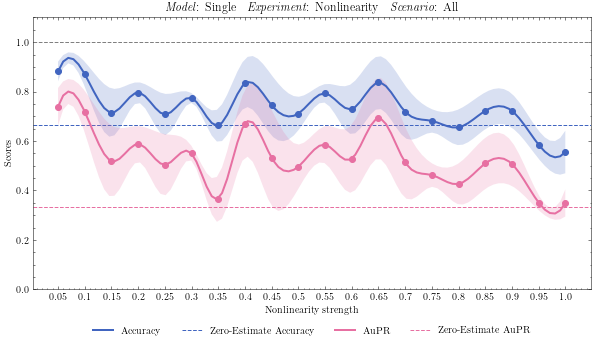

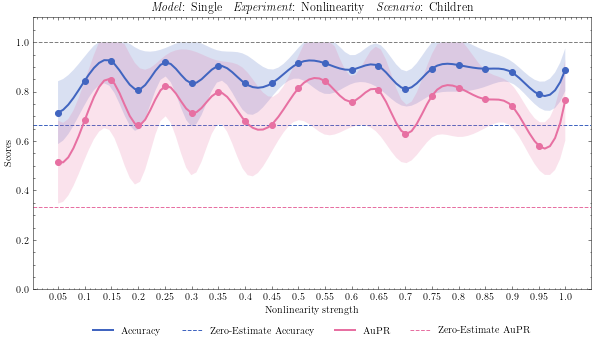

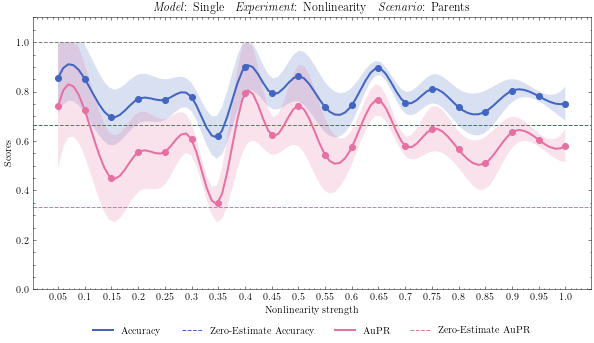

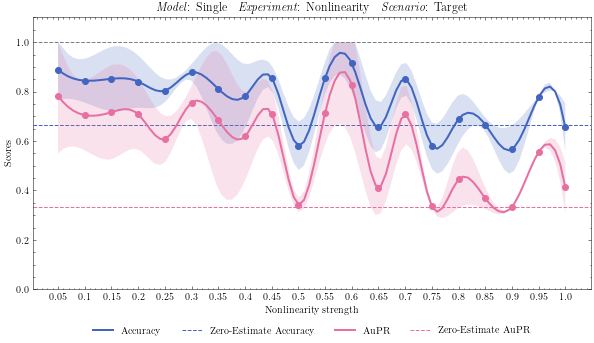

KeyError: 'Multi'

In [63]:
exp = "Nonlinearity"
scenarios = list(metrics[exp].keys())
for model in model_names:
    for scenario in scenarios:
        for tau in taus:
            data = {}
            for metric in metrics_names:
                data[metric] = {
                    step: metrics[exp][scenario][step][model][tau][metric]
                    for step in metrics[exp][scenario].keys()
                }

            steps = [int(v) for v in data[metric].keys()]
            sort = np.argsort(steps)
            sorted_steps = np.array(steps)[sort]
            labels = np.array([int(step_to_name(exp, step)) / np.max(steps) for step in data[metric]])[sort]

            x = np.arange(len([int(label) for label in labels]))

            fig, ax = plt.subplots(figsize=(10, 5))

            prop_cycler = ax._get_lines.prop_cycler
            colors = [next(prop_cycler)["color"] for _ in range(len(metrics_names))]
            plt.gca().set_prop_cycle(None)

            for i, metric in enumerate(metrics_names):
                means = np.array([data[metric][str(step)]["mean"] for step in sorted_steps])
                stds = np.array([data[metric][str(step)]["std"] for step in sorted_steps])

                xnew = np.linspace(np.min(x), np.max(x), 100, endpoint=True)
                means_interp = interp1d(x, means, "cubic")(xnew)
                stds_interp = interp1d(x, stds, "cubic")(xnew)

                ax.plot(
                    x, 
                    means,
                    "o",
                    color=colors[i],
                    lw=2,
                    alpha=1,
                )
                ax.plot(
                    xnew, 
                    means_interp,
                    "-",
                    color=colors[i],
                    label=long_metric_names[metric],
                    lw=2,
                    alpha=1,
                )
                ax.fill_between(
                    xnew,
                    means_interp-stds_interp,
                    np.min([means_interp+stds_interp, np.ones_like(means_interp)], axis=0),
                    alpha=0.2,
                    facecolor=colors[i]
                )


                if zero_baseline[metric]["mean"] > 0:
                    ax.axhline(y=zero_baseline[metric]["mean"], color=colors[i], linestyle='--', label=f"Zero-Estimate {long_metric_names[metric]}", zorder=0)
            horiz_line = ax.axhline(y=1, color='grey', linestyle='--')
            # Add some text for labels, title and custom x-axis tick labels, etc.
#                 ax.set_xscale('log', basex=2)
            ax.set_ylabel('Scores')
            ax.set_xlabel('Nonlinearity strength')
            ax.set_ylim(0, 1.1)
            ax.set_title(r"\textit{Model}: " + model
                         + r"\quad \textit{Experiment}: " + exp + 
                         r"\quad \textit{Scenario}: " + scenario)
            ax.set_xticks(x)
            ax.set_xticklabels(labels)
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              ncol=5, fancybox=True, shadow=True)
            plt.savefig(f"/home/michael/Desktop/nonsense/{model}_{exp}_{scenario}_{tau}.pdf")
            plt.show()



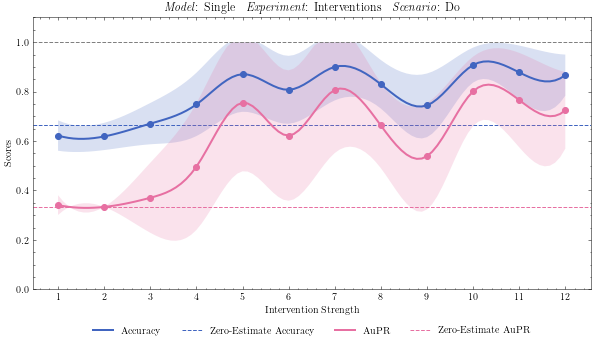

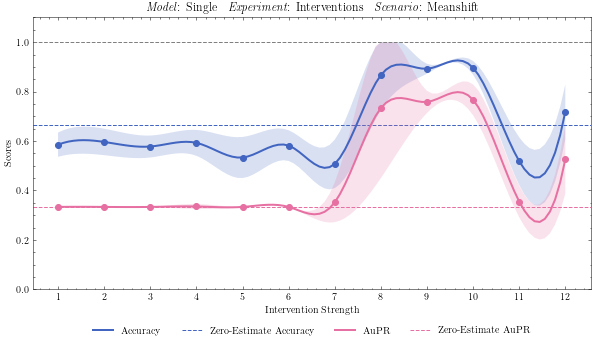

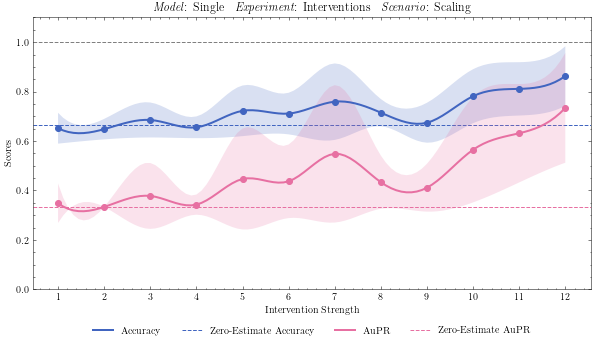

KeyError: 'Multi'

In [31]:
exp = "Interventions"
scenarios = list(metrics[exp].keys())
for model in model_names:
    for scenario in scenarios:
        for tau in taus:
            data = {}
            for metric in metrics_names:
                data[metric] = {
                    step: metrics[exp][scenario][step][model][tau][metric]
                    for step in metrics[exp][scenario].keys()
                }

            steps = [int(v) for v in data[metric].keys()]
            sort = np.argsort(steps)
            sorted_steps = np.array(steps)[sort]
            labels = np.array([step_to_name(exp, step) for step in data[metric]])[sort]

            x = np.arange(len([int(label) for label in labels]))

            fig, ax = plt.subplots(figsize=(10, 5))

            prop_cycler = ax._get_lines.prop_cycler
            colors = [next(prop_cycler)["color"] for _ in range(len(metrics_names))]
            plt.gca().set_prop_cycle(None)

            for i, metric in enumerate(metrics_names):
                means = np.array([data[metric][str(step)]["mean"] for step in sorted_steps])
                stds = np.array([data[metric][str(step)]["std"] for step in sorted_steps])

                xnew = np.linspace(np.min(x), np.max(x), 100, endpoint=True)
                means_interp = interp1d(x, means, "cubic")(xnew)
                stds_interp = interp1d(x, stds, "cubic")(xnew)

                ax.plot(
                    x, 
                    means,
                    "o",
                    color=colors[i],
                    lw=2,
                    alpha=1,
                )
                ax.plot(
                    xnew, 
                    means_interp,
                    "-",
                    color=colors[i],
                    label=long_metric_names[metric],
                    lw=2,
                    alpha=1,
                )
                ax.fill_between(
                    xnew,
                    means_interp-stds_interp,
                    np.min([means_interp+stds_interp, np.ones_like(means_interp)], axis=0),
                    alpha=0.2,
                    facecolor=colors[i]
                )


                if zero_baseline[metric]["mean"] > 0:
                    ax.axhline(y=zero_baseline[metric]["mean"], color=colors[i], linestyle='--', label=f"Zero-Estimate {long_metric_names[metric]}", zorder=0)
            horiz_line = ax.axhline(y=1, color='grey', linestyle='--')
            # Add some text for labels, title and custom x-axis tick labels, etc.

            ax.set_ylabel('Scores')
            ax.set_xlabel('Intervention Strength')
            ax.set_ylim(0, 1.1)
            ax.set_title(r"\textit{Model}: " + model + r"\quad \textit{Experiment}: " + exp + r"\quad \textit{Scenario}: " + scenario)
            ax.set_xticks(x)
            ax.set_xticklabels(labels)
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              ncol=5, fancybox=True, shadow=True)
            plt.savefig(f"/home/michael/Desktop/nonsense/{model}_{exp}_{scenario}_{tau}.pdf")
            plt.show()


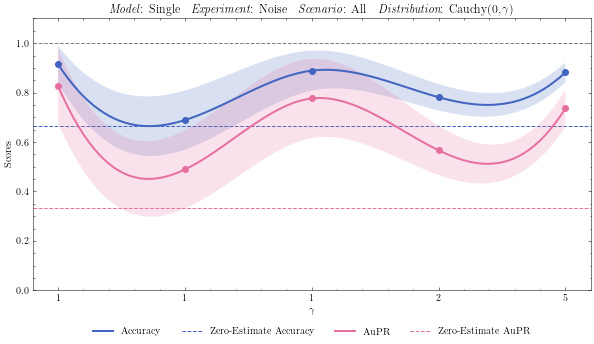

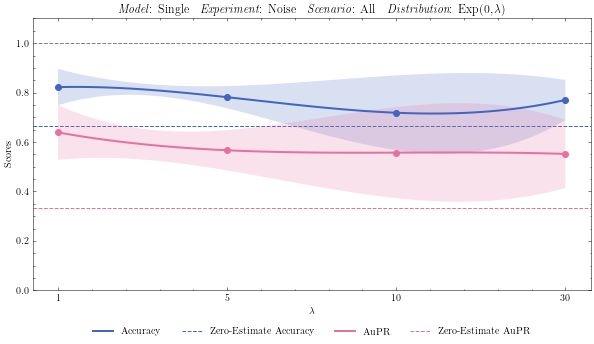

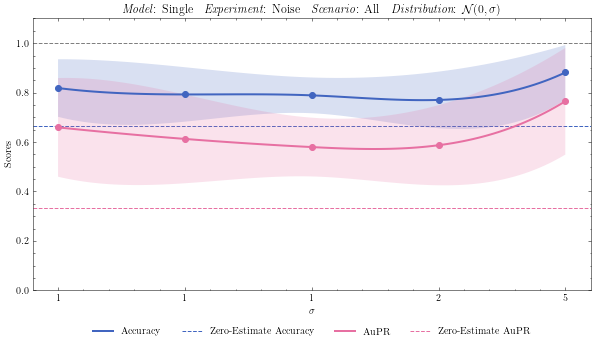

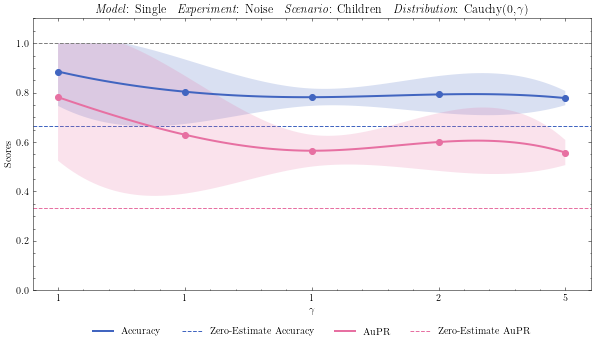

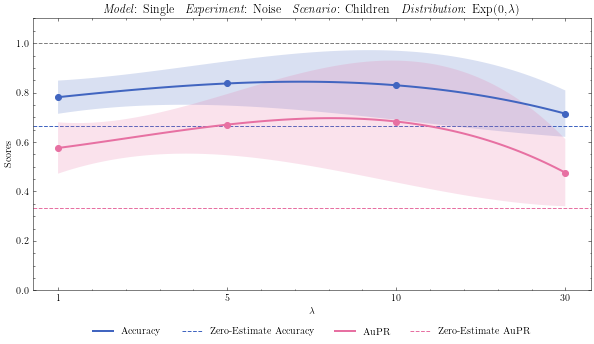

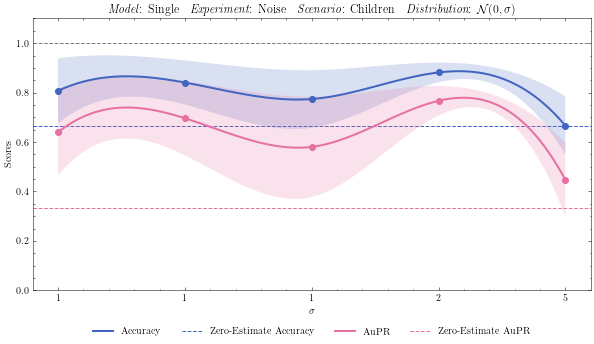

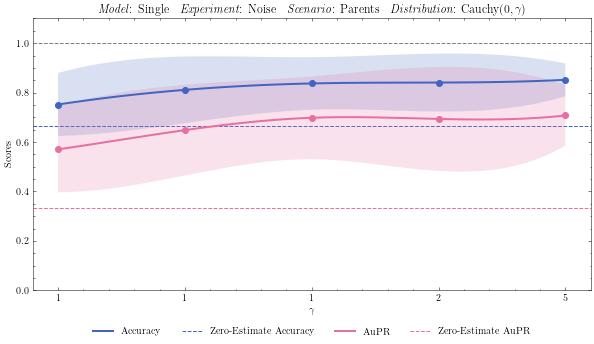

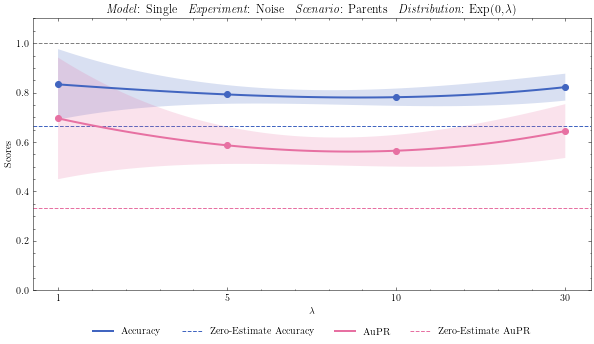

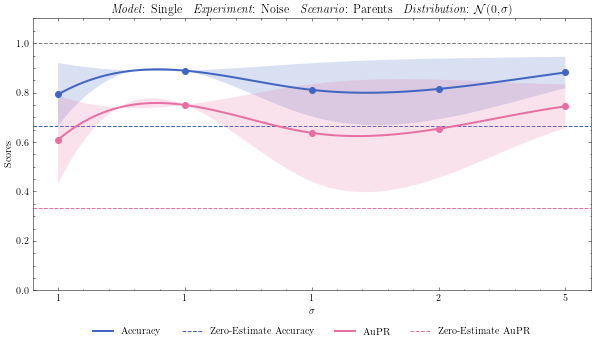

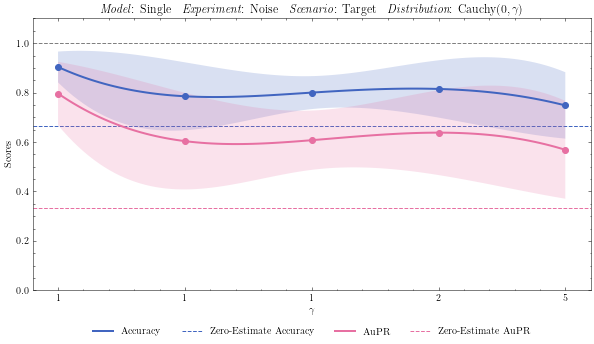

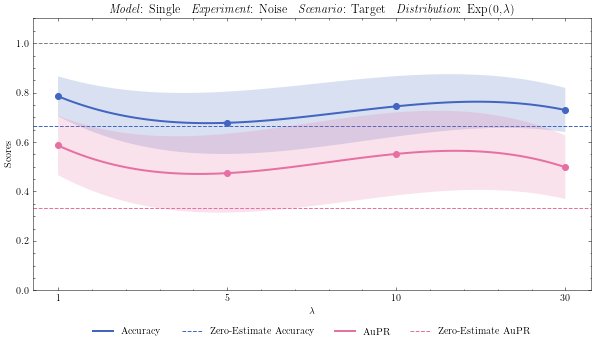

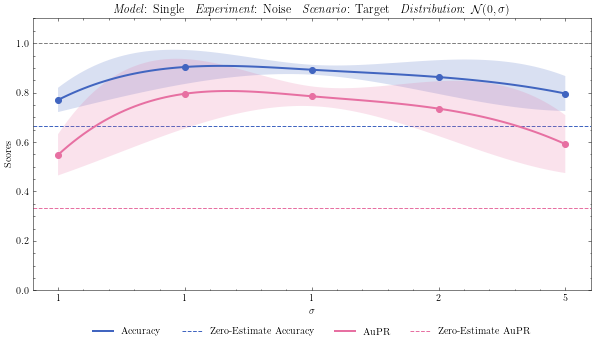

KeyError: 'Multi'

In [38]:
exp = "Noise"
distributions = {
    "normal": ("$\mathcal{N}(0, \sigma)$", "$\sigma$"), 
    "exponential": ("Exp$(0, \lambda)$", "$\lambda$"), 
    "cauchy": ("Cauchy$(0, \gamma)$", "$\gamma$")
}
scenarios = list(metrics[exp].keys())
dists = list(metrics[exp][scenarios[0]].keys())

for model in model_names:
    for scenario in scenarios:
        for dist in dists:
            for tau in taus:
                data = {}
                for metric in metrics_names:
                    data[metric] = {
                        arg: metrics[exp][scenario][dist][arg][model][tau][metric]
                        for arg in metrics[exp][scenario][dist].keys()
                    }

                steps = np.array([int(v.split(",")[1].split("=")[1]) if "," in v else int(v.split("=")[1]) for v in data[metric].keys()])
                sort = np.argsort(steps)
                sorted_steps = np.array(steps)[sort]
                labels = steps[sort]

                x = np.arange(len([int(label) for label in labels]))

                fig, ax = plt.subplots(figsize=(10, 5))

                prop_cycler = ax._get_lines.prop_cycler
                colors = [next(prop_cycler)["color"] for _ in range(len(metrics_names))]
                plt.gca().set_prop_cycle(None)

                for i, metric in enumerate(metrics_names):
                    means = np.array([data[metric][str(step)]["mean"] for step in data[metric].keys()])[sort]
                    stds = np.array([data[metric][str(step)]["std"] for step in data[metric].keys()])[sort]

                    xnew = np.linspace(np.min(x), np.max(x), 100, endpoint=True)
                    means_interp = interp1d(x, means, "cubic")(xnew)
                    stds_interp = interp1d(x, stds, "cubic")(xnew)

                    ax.plot(
                        x, 
                        means,
                        "o",
                        color=colors[i],
                        lw=2,
                        alpha=1,
                    )
                    ax.plot(
                        xnew, 
                        means_interp,
                        "-",
                        color=colors[i],
                        label=long_metric_names[metric],
                        lw=2,
                        alpha=1,
                    )
                    ax.fill_between(
                        xnew,
                        means_interp-stds_interp,
                        np.min([means_interp+stds_interp, np.ones_like(means_interp)], axis=0),
                        alpha=0.2,
                        facecolor=colors[i]
                    )


                    if zero_baseline[metric]["mean"] > 0:
                        ax.axhline(y=zero_baseline[metric]["mean"], color=colors[i], linestyle='--', label=f"Zero-Estimate {long_metric_names[metric]}", zorder=0)
                horiz_line = ax.axhline(y=1, color='grey', linestyle='--')

                ax.set_ylabel('Scores')
                ax.set_xlabel(distributions[dist][1])
                ax.set_ylim(0, 1.1)
                ax.set_title(r"\textit{Model}: " + model + 
                             r"\quad \textit{Experiment}: " + exp + 
                             r"\quad \textit{Scenario}: " + scenario + 
                             r"\quad \textit{Distribution}: " + distributions[dist][0])
                ax.set_xticks(x)
                ax.set_xticklabels(labels)
                ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                  ncol=5, fancybox=True, shadow=True)
                plt.savefig(f"/home/michael/Desktop/nonsense/{model}_{exp}_{scenario}_{tau}.pdf")
                plt.show()
